In [1]:
%config Completer.use_jedi = False

In [267]:
%load_ext autoreload
%autoreload 2

In [68]:
from arch.bootstrap import StationaryBootstrap
from arch.bootstrap import IndependentSamplesBootstrap
# from arch.bootstrap import bootstrapped_difference
from bootstrapped import bootstrap as bs
from bootstrapped import compare_functions as cf
import hdbscan
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import numpy as np
import os
import pandas as pd
import pickle
import random
from scipy.optimize import nnls
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import scipy
import scipy.cluster.hierarchy as sch
from scipy.stats import mannwhitneyu, normaltest
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import affinity_propagation
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannotations.Annotator import Annotator
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Utility functions

In [3]:
a = np.random.normal(size=(10, 3))
b = np.array([1, 2]).flatten()
a**b

ValueError: operands could not be broadcast together with shapes (10,3) (2,) 

In [ ]:
df_speciesAbun_split = geometric_avg(df_speciesAbun_prev, df_speciesAbun_next, p=0.1)
df_cons_abun_prod_split = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, \
                                                 df_speciesAbun=df_speciesAbun_split)

In [ ]:
df_cons_abun_prod_split

In [4]:
p_tmp_vec = 0.1 * np.ones((df_speciesMetab.shape[1]))
p_tmp_vec[20] = 0.1
sample_names_split, mat_cons_abun_split_list = \
    iterate_growth_ratio_pvec(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                              p_tmp_vec)

NameError: name 'df_speciesMetab' is not defined

In [5]:
sample_names_split_, mat_cons_abun_split_list_ = \
    iterate_growth_ratio(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                              0.1)

NameError: name 'iterate_growth_ratio' is not defined

In [6]:
for sample_ in sample_names_split:
    print(sample_)
    print(np.sum(np.abs(mat_cons_abun_split_list[sample_] - mat_cons_abun_split_list_[sample_])))

NameError: name 'sample_names_split' is not defined

In [7]:
mat_cons_abun_split_list[sample_] - mat_cons_abun_split_list_[sample_]

NameError: name 'mat_cons_abun_split_list' is not defined

In [8]:
def iterate_growth_ratio(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, p_):
    df_speciesAbun_split = geometric_avg(df_speciesAbun_prev, df_speciesAbun_next, p=p_)
    df_cons_abun_prod_split = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, \
                                                     df_speciesAbun=df_speciesAbun_split)
    sample_names_split, mat_cons_abun_split_list = \
        compute_species_metab_matrix_for_nnls(df_cons_abun_prod=df_cons_abun_prod_split, 
                                              df_speciesMetab=df_speciesMetab, 
                                              num_passages=6, num_bioRep=3, 
                                              sample_names=list(df_speciesAbun_split.columns.values))
    return sample_names_split, mat_cons_abun_split_list

def iterate_growth_ratio_pvec(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, p_vec):
    df_speciesAbun_split_dict = {}
    for i, p_ in enumerate(p_vec):
        df_speciesAbun_split_dict[i] = geometric_avg(df_speciesAbun_prev, df_speciesAbun_next, p=p_)
    
    df_cons_abun_prod_split = np.zeros((df_speciesAbun_prev.shape[1], df_speciesMetab.shape[1]))
    for row_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_split = np.zeros((df_speciesAbun_prev.shape[0], df_speciesMetab.shape[1]))
        for i, p_ in enumerate(p_vec):
            df_speciesAbun_split[:, i] = df_speciesAbun_split_dict[i].iloc[:, row_]
        df_cons_abun_prod_split[row_, :] = \
            compute_cons_abun_prod_new(df_speciesMetab=df_speciesMetab, \
                                       df_speciesAbun=df_speciesAbun_split)
    sample_names_split, mat_cons_abun_split_list = \
        compute_species_metab_matrix_for_nnls(df_cons_abun_prod=df_cons_abun_prod_split, 
                                              df_speciesMetab=df_speciesMetab, 
                                              num_passages=6, num_bioRep=3, 
                                              sample_names=list(df_speciesAbun_prev.columns.values))
    return sample_names_split, mat_cons_abun_split_list

def get_metab_names_orderedRi(Ri, df_metabNames, df_metabIds):
    metab_names_all = df_metabNames.iloc[:, 1].values
    metab_id_data = df_metabIds.iloc[:, 0].values - 1
    metab_names = metab_names_all[metab_id_data]
    
    id_order = np.argsort(-Ri)
    Ri_ordered = Ri.copy()[id_order]
    metab_names_ordered = metab_names[id_order]
    
    return id_order, Ri_ordered, metab_names_ordered

def create_abundance_header(num_bioRep=3, num_passages=6):
    '''Create header for the datafram with species abundance'''
    header_ = []
    for pass_ in range(num_passages):
        for rep_ in range(num_bioRep):
            header_.append('p' + str(pass_ + 1) + "_" + 'r' + str(rep_))
    return header_

def create_abundance_header_new(num_bioRep=3, num_passages=6):
    '''Create header for the datafram with species abundance'''
    header_ = []
    for rep_ in range(num_bioRep):
        for pass_ in range(num_passages):
            header_.append('p' + str(pass_ + 1) + "_" + 'r' + str(rep_))
    return header_

def expand_passage_by_rep(passage_='p1', num_bioRep=3):
    '''Expand passage name to include replicate numbers as well'''
    passage_rep = []
    for rep_ in range(num_bioRep):
        passage_rep.append(passage_ + "_" + "r" + str(rep_))
        
    return passage_rep

def compute_cons_abun_prod(df_speciesMetab, df_speciesAbun):
    '''Compute matrix product of species-metabolite consumption matrix and species abundance matrix'''        
    df_speciesAbun_T = df_speciesAbun.copy()
    df_speciesAbun_T = df_speciesAbun_T.transpose()
#     df_cons_abun_prod = df_speciesAbun_T.dot(df_speciesMetab)
    df_cons_abun_prod = np.matmul(np.array(df_speciesAbun_T.values), np.array(df_speciesMetab.values))
    return df_cons_abun_prod

def compute_cons_abun_prod_new(df_speciesMetab, df_speciesAbun):
    '''Compute matrix product of species-metabolite consumption matrix and species abundance matrix'''
    df_speciesAbun_T = df_speciesAbun.copy()
    df_speciesAbun_T = df_speciesAbun_T.transpose()
#     df_cons_abun_prod = df_speciesAbun_T.dot(df_speciesMetab)
    df_cons_abun_prod = \
        np.multiply(np.array(df_speciesAbun), np.array(df_speciesMetab.values)).sum(axis=0)
    return df_cons_abun_prod

def compute_species_metab_matrix_for_nnls(df_cons_abun_prod, df_speciesMetab, num_passages=6, num_bioRep=3, 
                                          sample_names=None):
    '''create one matrix of c_i^alpha / (sum_beta c_i^beta B_beta(k)) (species X metabolites) 
       for each passage and bioreplicate'''
    num_species_tmp = df_speciesMetab.shape[0]
    num_metabs_tmp = df_speciesMetab.shape[1]
    if sample_names is None:
        sample_names = create_abundance_header(num_passages=6, num_bioRep=3)
    mat_cons_abun_list = {}
    tmp_ones = np.ones((num_species_tmp, 1))
    for sample_ in sample_names:
#         df_denom = df_cons_abun_prod.loc[sample_, :]
        df_denom = df_cons_abun_prod[sample_names.index(sample_), :]
        tmp_mat = np.array(df_denom).reshape((1, num_metabs_tmp))
        mat_denom = np.matmul(tmp_ones, tmp_mat)
        mat_cons_abun_list[sample_] = np.divide(np.array(df_speciesMetab.copy().values), mat_denom)
        
    return sample_names, mat_cons_abun_list


def null_Ri_2(df_speciesMetab, df_cons_abun_prod_split):
    tmp = df_speciesMetab.sum(axis=1)
    tmp = np.array(df_speciesMetab.sum(axis=1)).mean()
    tmp = df_cons_abun_prod_split.mean(axis=0) / tmp
    return tmp


def get_rank(arr):
    # Get the sorted indices
    sorted_indices = np.argsort(arr)

    # Initialize an array to hold the ranks
    ranks = np.zeros_like(sorted_indices)

    # Rank the elements
    ranks[sorted_indices] = np.arange(len(arr))

    # Calculate the average rank for repeated values
    unique_arr, unique_counts = np.unique(arr, return_counts=True)
    repeat_indices = np.where(unique_counts > 1)[0]
    for idx in repeat_indices:
        repeat_mask = (arr == unique_arr[idx])
        repeat_ranks = ranks[repeat_mask]
        mean_rank = repeat_ranks.mean()
        ranks[repeat_mask] = mean_rank
    return ranks


def geometric_avg(mat_init, mat_final, p=0):
    mat_split = mat_init**p * mat_final**(1 - p)
    return mat_split

In [9]:
def post_process_hdbscan_clusters(cluster_labels):
    clust_labels, clust_counts = np.unique(cluster_labels, return_counts=True)
    cluster_labels_new = np.zeros((len(cluster_labels)))

    for label_ in clust_labels:
        if label_ >= 0:
            cluster_labels_new[cluster_labels == label_] = label_
        else:
            len_labels = len(cluster_labels[cluster_labels == label_])
            cluster_labels_new[cluster_labels == label_] = \
                np.arange(len(clust_labels) - 1, len(clust_labels) - 1 + len_labels)
    return cluster_labels_new.astype(int)

## Fit Ri, abundance and growth ratio functions

In [10]:
def remove_passages(pass_rm_list, num_passages=6, num_brep=3):
    pass_ex_list = []
    for pass_ in pass_rm_list:
        for rep_ in range(num_brep):
            pass_ex_list += [pass_ + rep_ * num_passages]
    pass_keep = list(set(range(num_passages * num_brep)) - set(pass_ex_list))
    return pass_keep

In [11]:
def compute_Ri_ss_goodness_of_fit(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                                  id_species, Ri_fit):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    lhs_ = []
    rhs_ = []
    sample_rm = []
    species_rm = []
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=0)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            abun_tmp = \
                df_speciesAbun_prev_tmp.iloc[id_species, sample_id].values.reshape((len(id_species), 1))
            b_train_sample = abun_tmp.flatten()
            abun_tmp = np.matmul(abun_tmp, np.ones((1, df_speciesMetab.shape[1])))
            A_train_sample = np.multiply(A_train_sample, abun_tmp)

            lhs_ = np.matmul(A_train_sample, Ri_fit).flatten()
            id_rm = np.where(lhs_ > 1)[0]
            sample_rm += [sample_] * len(id_rm)
            species_rm += list(id_rm)
            
            
            if count_ == 0:
                A_train = A_train_sample
                b_train = b_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
                b_train = np.hstack((b_train, b_train_sample))
#     b_train = np.ones((A_train.shape[0]))
    lhs_ = b_train.flatten()
    rhs_ = np.matmul(A_train, Ri_fit).flatten()
    return lhs_, rhs_, sample_rm, species_rm

In [159]:
def compute_Ri_hybrid(df_speciesMetab, df_speciesAbun_, df_speciesAbun_prev, \
                      df_speciesAbun_next, df_speciesAbun_ratio, num_passages, \
                      p_tmp, id_species):
    # steady state part
    df_speciesAbun_prev_tmp = df_speciesAbun_.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_.copy()
    num_species_tmp = df_speciesAbun_.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=0)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
                
      
    # dynamical part
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp_ratio = tmp.copy()
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]
            
            A_train = np.vstack((A_train, A_train_sample))
                
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_


def compute_Ri_ss(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                  p_tmp, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               p_tmp, num_passages, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp_ratio = tmp.copy()
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample
#                 b_train = tmp_ratio[id_keep].flatten()
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
#                 b_train = np.hstack((b_train, tmp_ratio[id_keep]))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_growth_ratio_iterate_blind(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                       ratio_means_, df_speciesMetab, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
#         pass_ = int(sample_.split("_")[0][1])
#         brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio


def compute_growth_ratio_iterate(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                 ratio_means_, df_speciesMetab, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [13]:
p_tmp_vec = 0.1 * np.ones((df_speciesMetab_tmp.shape[1]))
id_Ri_order = np.argsort(-Ri_noMicrocosm_ss_fit_avg[3].copy())
p_tmp_vec[id_Ri_order[0]] = 0.001

NameError: name 'df_speciesMetab_tmp' is not defined

In [14]:
df_growth_rate = compute_growth_ratio_iterate_new(df_speciesAbun_prev_tmp_.copy(), \
                                                 df_speciesAbun_next_tmp_.copy(), \
                                                 p_tmp_vec, Ri_avg.copy(), \
                                                 growth_rate_all[iter_id].copy(), \
                                                 ratio_means_.copy(), \
                                                 df_speciesMetab_tmp.copy(),
                                                 norm_=False)

NameError: name 'compute_growth_ratio_iterate_new' is not defined

In [15]:
df_growth_rate

NameError: name 'df_growth_rate' is not defined

In [16]:
growth_ratios_ = growth_rate_all[iter_id].copy()
df_speciesAbun_ratio_new = df_speciesAbun_prev_tmp_.copy()
df_speciesAbun_next_tmp_1 = df_speciesAbun_next_tmp_.copy()
for col_ in range(df_speciesAbun_prev_tmp_.shape[1]):
    df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
    df_speciesAbun_next_tmp_1.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
        df_speciesAbun_prev_tmp_.iloc[:, col_].values

NameError: name 'growth_rate_all' is not defined

In [17]:
df_speciesAbun_next_tmp_1

NameError: name 'df_speciesAbun_next_tmp_1' is not defined

In [18]:
sample_names_split, mat_cons_abun_split_list_tmp = \
    iterate_growth_ratio_pvec(df_speciesMetab.copy(), df_speciesAbun_prev_tmp_.copy(), \
                              df_speciesAbun_next_tmp_1.copy(), p_vec=p_tmp_vec)

NameError: name 'df_speciesMetab' is not defined

In [19]:
def compute_growth_ratio_iterate_new(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                     ratio_means_, df_speciesMetab, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio_pvec(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                                  df_speciesAbun_next.copy(), p_vec=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    num_metabs = df_speciesMetab.shape[1]
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        tmp_mat = tmp.flatten()
        tmp_mat = np.tile(tmp_mat, num_metabs).reshape((num_metabs, len(tmp_mat))).T
        p_tmp_mat = \
            np.tile(p_tmp.flatten(), len(tmp)).reshape((len(tmp), len(p_tmp)))
        A_tmp = np.multiply(A_train_sample[id_keep, :], tmp_mat**(1 - p_tmp_mat))
        vals_tmp = (np.matmul(A_tmp, Ri).flatten())
#         vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
#                                tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [20]:
a = np.arange(10).flatten()
np.hstack([a, a]).shape

(20,)

# Get Data

In [21]:
# directory with all data
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'jin_pollard'))

In [22]:
# species-metabolite consumption matrix, c_species^metabolite
file_speciesProd = os.path.join(data_dir, 
                                "species_metabolite_production_matrix.csv")
thresh_zero_prod = 0
df_speciesProd = pd.read_csv(file_speciesProd, sep=",", header=None)
df_speciesProd[df_speciesProd == 0] = thresh_zero_prod
# num_species, num_metabs = df_speciesProd.shape

In [23]:
# species-metabolite consumption matrix, c_species^metabolite
file_speciesMetab = os.path.join(data_dir, 
                                "species_metabolite_consumption_matrix.csv")
thresh_zero_metab = 0
df_speciesMetab = pd.read_csv(file_speciesMetab, sep=",", header=None)
df_speciesMetab[df_speciesMetab == 0] = thresh_zero_metab
num_species, num_metabs = df_speciesMetab.shape

In [24]:
# species abundances for all passages and bioreplicates
num_passages = 6
num_bioRep = 3
file_speciesAbun = os.path.join(data_dir, 
                                "species_abundances.csv")
df_speciesAbun = pd.read_csv(file_speciesAbun, sep=",", header=None)
df_speciesAbun.columns = create_abundance_header_new(num_bioRep=num_bioRep, num_passages=num_passages)
df_speciesAbun_raw = df_speciesAbun.copy()
thresh_zero = 1e-8
df_speciesAbun[df_speciesAbun == 0] = thresh_zero
df_speciesAbun_T = df_speciesAbun.copy()
df_speciesAbun_T = df_speciesAbun_T.transpose()

In [25]:
# species abundances for all passages and bioreplicates
num_passages = 6
num_bioRep = 3
file_speciesAbun_super_agar = os.path.join(data_dir, 
                                "species_abundances_plain_agar_supernatant.csv")
df_speciesAbun_super_agar = pd.read_csv(file_speciesAbun_super_agar, sep=",", header=None)
df_speciesAbun_super_agar.columns = \
    create_abundance_header_new(num_bioRep=num_bioRep, num_passages=num_passages)
df_speciesAbun_super_agar_raw = df_speciesAbun_super_agar.copy()
thresh_zero = 1e-8
df_speciesAbun_super_agar[df_speciesAbun_super_agar == 0] = thresh_zero
df_speciesAbun_super_agar_T = df_speciesAbun_super_agar.copy()
df_speciesAbun_super_agar_T = df_speciesAbun_super_agar_T.transpose()

SignificanceResult(statistic=0.7735208443503792, pvalue=1.877235066355581e-226)
PearsonRResult(statistic=0.6904302686235642, pvalue=2.2445882421165145e-161)


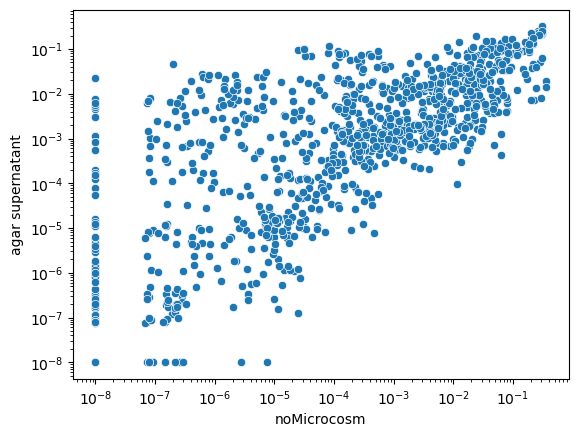

In [26]:
y = np.array(df_speciesAbun_super_agar).flatten()
x = np.array(df_speciesAbun).flatten()
plt_ = sns.scatterplot(x=x, y=y)
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)
plt_.set_xlabel("noMicrocosm")
plt_.set_ylabel("agar supernatant")
print(scipy.stats.spearmanr(x, y))
print(scipy.stats.pearsonr(x, y))

In [27]:
# species abundances for all passages and bioreplicates
num_passages = 6
num_bioRep = 3
file_speciesAbun_mucin = os.path.join(data_dir, 
                                "species_abundances_mucin_supernatant.csv")
df_speciesAbun_mucin = pd.read_csv(file_speciesAbun_mucin, sep=",", header=None)
df_speciesAbun_mucin.columns = \
    create_abundance_header_new(num_bioRep=num_bioRep, num_passages=num_passages)
df_speciesAbun_mucin_raw = df_speciesAbun_mucin.copy()
thresh_zero = 1e-8
df_speciesAbun_mucin[df_speciesAbun_mucin == 0] = thresh_zero
df_speciesAbun_mucin_T = df_speciesAbun_mucin.copy()
df_speciesAbun_mucin_T = df_speciesAbun_mucin_T.transpose()

SignificanceResult(statistic=0.9198071163033489, pvalue=0.0)
PearsonRResult(statistic=0.8890501181858015, pvalue=0.0)


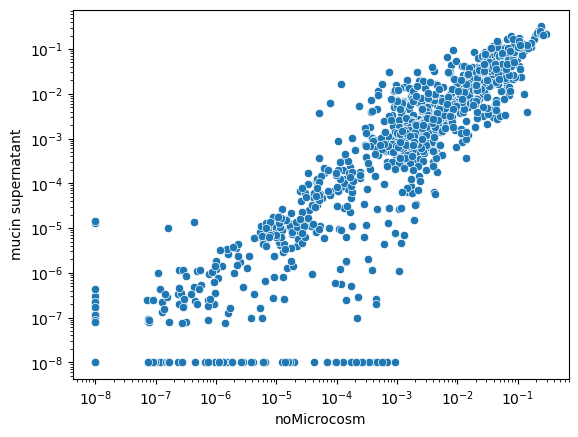

In [28]:
y = np.array(df_speciesAbun_super_agar).flatten()
x = np.array(df_speciesAbun_mucin).flatten()
plt_ = sns.scatterplot(x=x, y=y)
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)
plt_.set_xlabel("noMicrocosm")
plt_.set_ylabel("mucin supernatant")
print(scipy.stats.spearmanr(x, y))
print(scipy.stats.pearsonr(x, y))

In [29]:

file_speciesAbun = os.path.join(data_dir, 
                                "species_abundances_inoculum.csv")
df_speciesAbun_inoc = pd.read_csv(file_speciesAbun, sep=",", header=None)
df_speciesAbun_inoc.columns = ["inoculum"]
df_speciesAbun_inoc[df_speciesAbun_inoc == 0] = thresh_zero

In [30]:
# consumption, abundance product. Sum of species-metabolite consumption matrix, c_species^metabolite, for each 
# metabolite for each passage (and replicate) across all the species
# df_cons_abun_prod = df_speciesAbun_T.dot(df_speciesMetab)
df_cons_abun_prod = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, 
                                           df_speciesAbun=df_speciesAbun)
df_cons_abun_prod_avg = df_cons_abun_prod.mean(axis=0)
id_metabs_sorted = np.argsort(df_cons_abun_prod_avg)[::-1]

In [31]:
# metabolite names and indices of the selected metabolites (metabolites used for the 
# species-metabolite consumption matrix, c_species^metabolite)
file_metabNames = os.path.join(data_dir, 
                                "metabolites_list_FC.csv")
df_metabNames = pd.read_csv(file_metabNames, sep=",", header=0)

file_metabIds = os.path.join(data_dir, 
                                "metabolite_indices.csv")
df_metabIds = pd.read_csv(file_metabIds, sep=",", header=None)

metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]

In [32]:
# species names and indices of the selected species (metabolites used for the 
# species abundance matrix, B_species_k)
file_speciesNames = os.path.join(data_dir, 
                                "species_list.csv")
df_speciesNames = pd.read_csv(file_speciesNames, sep=",", header=0)

file_speciesIds = os.path.join(data_dir, 
                                "species_indices.csv")
df_speciesIds = pd.read_csv(file_speciesIds, sep=",", header=None)

In [33]:
passages_ = np.array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6'])
reps_ = np.array(['r0', 'r1', 'r2'])
df_speciesAbun_ratio = pd.DataFrame()
df_speciesAbun_ratio_corr = pd.DataFrame()
df_speciesAbun_new = pd.DataFrame()
df_speciesAbun_prev = pd.DataFrame()
df_speciesAbun_next = pd.DataFrame()
df_speciesAbun_split = pd.DataFrame()
count_ = 0
brep_vec = list(range(num_bioRep))
for rep_ in reps_:
    for pass_ in range(1, len(passages_)):
        col_1 = passages_[pass_ - 1] + "_" + rep_
        col_2 = passages_[pass_] + "_" + rep_
        
        df_speciesAbun_prev[col_2] = df_speciesAbun[col_1].values
        df_speciesAbun_next[col_2] = df_speciesAbun[col_2].values
        
        array_1 = np.array(df_speciesAbun[col_2].values / df_speciesAbun[col_1].values)
        array_2 = np.array(df_speciesAbun[col_2].values)
        array_3 = np.array(df_speciesAbun[col_1].values)
        
        df_speciesAbun_new[col_1] = df_speciesAbun[col_1].values
        df_speciesAbun_new[col_2] = df_speciesAbun[col_2].values
        df_speciesAbun_ratio[col_2] = array_1.copy()
        df_speciesAbun_ratio_corr[col_2] = array_1.copy()
        id_ = np.where((array_3 == thresh_zero) & (array_2 == thresh_zero))[0]
#         id_ = np.where((array_2 == thresh_zero))[0]
#         id_ = np.where(array_1 == 1)[0]
        
        if len(id_) > 0:
            df_speciesAbun_ratio.iloc[id_, count_] = -1
            rep_alt = list(set(reps_) - set([rep_]))
            ratio_vec = []
            for id_tmp in id_:
                abun_alt_ratio = []
                for rep__ in rep_alt:
                    col_1_ = passages_[pass_ - 1] + "_" + rep__
                    col_2_ = passages_[pass_] + "_" + rep__
                    val_1 = df_speciesAbun[col_1_].values[id_tmp]
                    val_2 = df_speciesAbun[col_2_].values[id_tmp]
                    if (val_1 != thresh_zero) | (val_2 != thresh_zero):
                        abun_alt_ratio.append(val_2 / val_1)
                if len(abun_alt_ratio) != 0:
                    df_speciesAbun_ratio_corr.iloc[id_tmp, count_] = \
                        np.exp(np.mean(np.log10(np.array(abun_alt_ratio))))
                else:
                    df_speciesAbun_ratio_corr.iloc[id_tmp, count_] = -1
                
        count_ += 1

In [34]:
df_speciesAbun_ratio_corr_2 = df_speciesAbun_ratio_corr.copy()
df_speciesAbun_ratio_corr_2[df_speciesAbun_ratio_corr_2 == -1] = 1

In [35]:
# previous and next abundances for supernatant agar
passages_ = np.array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6'])
reps_ = np.array(['r0', 'r1', 'r2'])
df_speciesAbun_super_agar_ratio = pd.DataFrame()
df_speciesAbun_super_agar_ratio_corr = pd.DataFrame()
df_speciesAbun_super_agar_new = pd.DataFrame()
df_speciesAbun_super_agar_prev = pd.DataFrame()
df_speciesAbun_super_agar_next = pd.DataFrame()
df_speciesAbun_super_agar_split = pd.DataFrame()
count_ = 0
brep_vec = list(range(num_bioRep))
for rep_ in reps_:
    for pass_ in range(1, len(passages_)):
        col_1 = passages_[pass_ - 1] + "_" + rep_
        col_2 = passages_[pass_] + "_" + rep_
        
        df_speciesAbun_super_agar_prev[col_2] = df_speciesAbun_super_agar[col_1].values
        df_speciesAbun_super_agar_next[col_2] = df_speciesAbun_super_agar[col_2].values
        
        array_1 = np.array(df_speciesAbun_super_agar[col_2].values / df_speciesAbun_super_agar[col_1].values)
        array_2 = np.array(df_speciesAbun_super_agar[col_2].values)
        array_3 = np.array(df_speciesAbun_super_agar[col_1].values)
        
        df_speciesAbun_super_agar_new[col_1] = df_speciesAbun_super_agar[col_1].values
        df_speciesAbun_super_agar_new[col_2] = df_speciesAbun_super_agar[col_2].values
        df_speciesAbun_super_agar_ratio[col_2] = array_1.copy()
        df_speciesAbun_super_agar_ratio_corr[col_2] = array_1.copy()
        id_ = np.where((array_3 == thresh_zero) & (array_2 == thresh_zero))[0]
#         id_ = np.where((array_2 == thresh_zero))[0]
#         id_ = np.where(array_1 == 1)[0]
        
        if len(id_) > 0:
            df_speciesAbun_super_agar_ratio.iloc[id_, count_] = -1
            rep_alt = list(set(reps_) - set([rep_]))
            ratio_vec = []
            for id_tmp in id_:
                Abun_super_agar_alt_ratio = []
                for rep__ in rep_alt:
                    col_1_ = passages_[pass_ - 1] + "_" + rep__
                    col_2_ = passages_[pass_] + "_" + rep__
                    val_1 = df_speciesAbun_super_agar[col_1_].values[id_tmp]
                    val_2 = df_speciesAbun_super_agar[col_2_].values[id_tmp]
                    if (val_1 != thresh_zero) | (val_2 != thresh_zero):
                        Abun_super_agar_alt_ratio.append(val_2 / val_1)
                if len(Abun_super_agar_alt_ratio) != 0:
                    df_speciesAbun_super_agar_ratio_corr.iloc[id_tmp, count_] = \
                        np.exp(np.mean(np.log10(np.array(Abun_super_agar_alt_ratio))))
                else:
                    df_speciesAbun_super_agar_ratio_corr.iloc[id_tmp, count_] = -1
                
        count_ += 1

In [36]:
# previous and next abundances for mucin agar
passages_ = np.array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6'])
reps_ = np.array(['r0', 'r1', 'r2'])
df_speciesAbun_mucin_ratio = pd.DataFrame()
df_speciesAbun_mucin_ratio_corr = pd.DataFrame()
df_speciesAbun_mucin_new = pd.DataFrame()
df_speciesAbun_mucin_prev = pd.DataFrame()
df_speciesAbun_mucin_next = pd.DataFrame()
df_speciesAbun_mucin_split = pd.DataFrame()
count_ = 0
brep_vec = list(range(num_bioRep))
for rep_ in reps_:
    for pass_ in range(1, len(passages_)):
        col_1 = passages_[pass_ - 1] + "_" + rep_
        col_2 = passages_[pass_] + "_" + rep_
        
        df_speciesAbun_mucin_prev[col_2] = df_speciesAbun_mucin[col_1].values
        df_speciesAbun_mucin_next[col_2] = df_speciesAbun_mucin[col_2].values
        
        array_1 = np.array(df_speciesAbun_mucin[col_2].values / df_speciesAbun_mucin[col_1].values)
        array_2 = np.array(df_speciesAbun_mucin[col_2].values)
        array_3 = np.array(df_speciesAbun_mucin[col_1].values)
        
        df_speciesAbun_mucin_new[col_1] = df_speciesAbun_mucin[col_1].values
        df_speciesAbun_mucin_new[col_2] = df_speciesAbun_mucin[col_2].values
        df_speciesAbun_mucin_ratio[col_2] = array_1.copy()
        df_speciesAbun_mucin_ratio_corr[col_2] = array_1.copy()
        id_ = np.where((array_3 == thresh_zero) & (array_2 == thresh_zero))[0]
#         id_ = np.where((array_2 == thresh_zero))[0]
#         id_ = np.where(array_1 == 1)[0]
        
        if len(id_) > 0:
            df_speciesAbun_mucin_ratio.iloc[id_, count_] = -1
            rep_alt = list(set(reps_) - set([rep_]))
            ratio_vec = []
            for id_tmp in id_:
                Abun_mucin_alt_ratio = []
                for rep__ in rep_alt:
                    col_1_ = passages_[pass_ - 1] + "_" + rep__
                    col_2_ = passages_[pass_] + "_" + rep__
                    val_1 = df_speciesAbun_mucin[col_1_].values[id_tmp]
                    val_2 = df_speciesAbun_mucin[col_2_].values[id_tmp]
                    if (val_1 != thresh_zero) | (val_2 != thresh_zero):
                        Abun_mucin_alt_ratio.append(val_2 / val_1)
                if len(Abun_mucin_alt_ratio) != 0:
                    df_speciesAbun_mucin_ratio_corr.iloc[id_tmp, count_] = \
                        np.exp(np.mean(np.log10(np.array(Abun_mucin_alt_ratio))))
                else:
                    df_speciesAbun_mucin_ratio_corr.iloc[id_tmp, count_] = -1
                
        count_ += 1

# distribution of consumption values for metabolites across strains

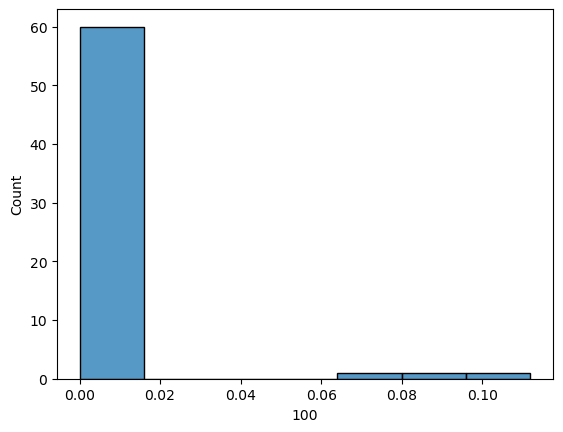

In [62]:
metab_ = 100
x = df_speciesMetab.iloc[:, metab_]
plt_ = sns.histplot(x[x >= 0])

In [80]:
def hierarchical_cluster_metabs(df_speciesMetab, n_clusters, metric="euclidean"):
    plt_ = sns.clustermap(df_speciesMetab, cmap="coolwarm", figsize=(7, 7), \
                          metric="euclidean")
    linkage_data = linkage(df_speciesMetab.T, method="ward", metric=metric)
#     dendrogram(linkage_data)
#     plt.show()
    
    h_cluster = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage="ward")
    cluster_labels_new = h_cluster.fit_predict(df_speciesMetab.T)
    
    return cluster_labels_new

/home/tarunm3/miniconda3/envs/pyg_env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


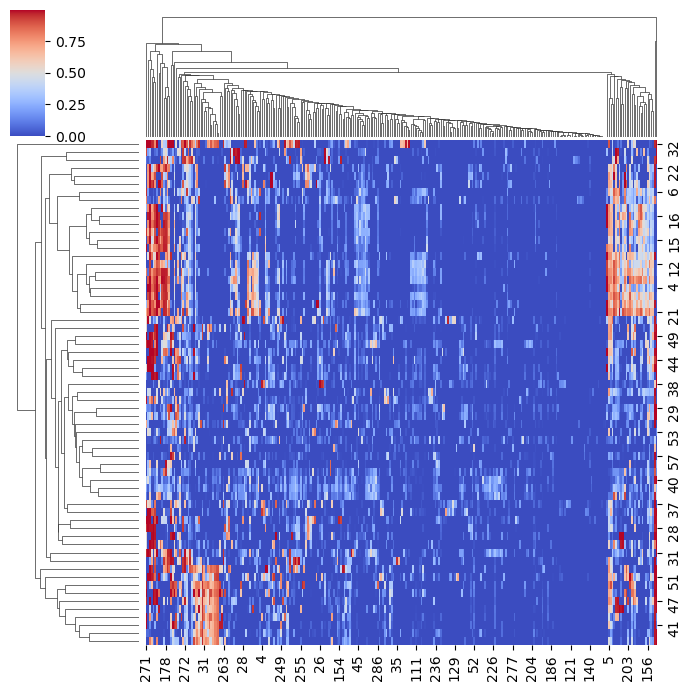

In [86]:
cluster_labels_new = hierarchical_cluster_metabs(df_speciesMetab, n_clusters=70, metric="euclidean")

In [87]:
clust_labels, clust_counts = np.unique(cluster_labels_new, return_counts=True)
print(clust_labels)
print(clust_counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
[33  3  2  7 11  6  3  5  3  5  6  4  4  8 10  3  2  2 72  3  7  3  8  2
  2  4  5  1  1  1  1  2  3  8  1  1  1  1  1  1  1  1  3  1  1  3  2  1
  4  1  1  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  7  1]


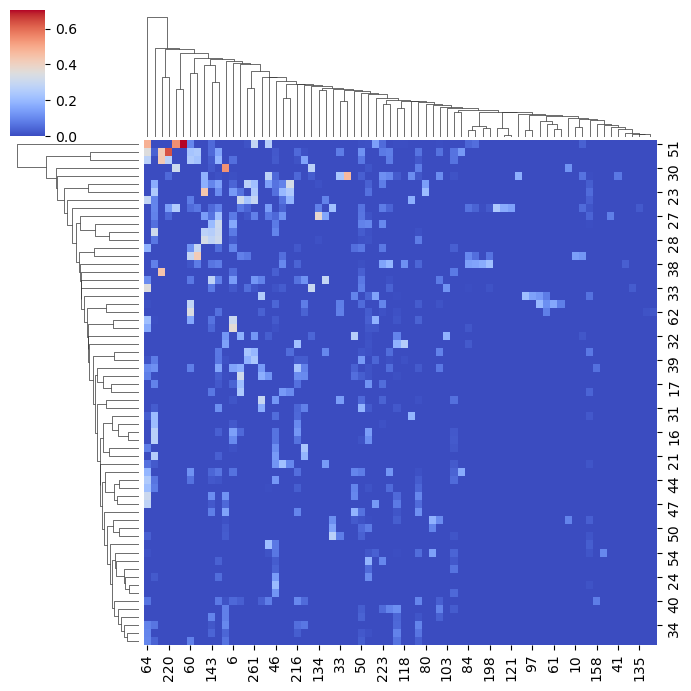

In [89]:
id_ = np.where(cluster_labels_new == 18)[0]
df_tmp = df_speciesMetab.copy()
df_tmp = df_tmp.iloc[:, id_]
plt_ = sns.clustermap(df_tmp, cmap="coolwarm", figsize=(7, 7), \
                      metric="euclidean")

/home/tarunm3/miniconda3/envs/pyg_env/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


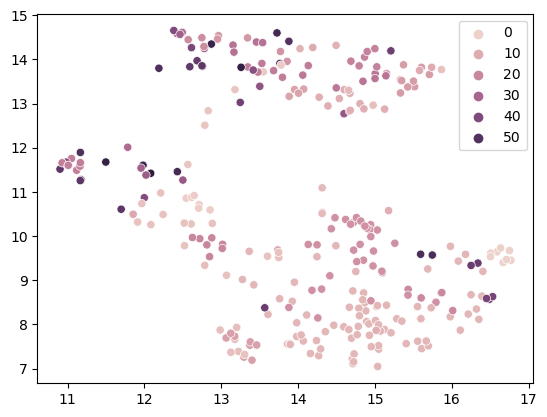

In [71]:
plt_ = sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=cluster_labels_new, \
                      cmap="viridis")

# 16 April 2023: For no-microcosm cluster metabolites and fit steady state Ri on the clustered metabolites

In [241]:
date_ = '20230416'
date_ = '20230426'
date_ = '20230427'
date_ = '20230515'
date_ = '20230517'
distance_metric = 'euclidean'
# distance_metric = 'correlation'
metab_cluster_mean_func = 'geometric'
metab_cluster_mean_func = "linear"
clustering_method = "hdbscan"
clustering_method = "hierarch_clust"
random_seed = 635
# random_seed = 9876
# random_seed = 7360
microcosm_type = "supernatantAgar"
microcosm_type = "mucin"
microcosm_type = "noMicrocosm"

In [242]:
if microcosm_type == "noMicrocosm":
    df_speciesAbun_mdl = df_speciesAbun.copy()
    df_speciesAbun_prev_mdl = df_speciesAbun_prev.copy()
    df_speciesAbun_next_mdl = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_mdl = df_speciesAbun_ratio.copy()
elif microcosm_type == "supernatantAgar":
    df_speciesAbun_mdl = df_speciesAbun_super_agar.copy()
    df_speciesAbun_prev_mdl = df_speciesAbun_super_agar_prev.copy()
    df_speciesAbun_next_mdl = df_speciesAbun_super_agar_next.copy()
    df_speciesAbun_ratio_mdl = df_speciesAbun_super_agar_ratio.copy()
elif microcosm_type == "mucin":
    df_speciesAbun_mdl = df_speciesAbun_mucin.copy()
    df_speciesAbun_prev_mdl = df_speciesAbun_mucin_prev.copy()
    df_speciesAbun_next_mdl = df_speciesAbun_mucin_next.copy()
    df_speciesAbun_ratio_mdl = df_speciesAbun_mucin_ratio.copy()

## Embed species metabolite consumption matrix using umap, project to 10 dimensional space for clustering later

In [243]:
dim_project = 20
n_clusters_kmean = 60
n_clusters_hclust = 70
X = df_speciesMetab.copy().T
reducer = umap.UMAP(metric=distance_metric, n_components=dim_project, random_state=random_seed)
embedding = reducer.fit_transform(X)

## Cluster umap projection using HDBSCAN

/home/tarunm3/miniconda3/envs/pyg_env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
[33  3  2  7 11  6  3  3  3  5  6  4  4  8 10  5  2  2 72  3  7  3  8  2
  2  4  5  1  1  1  1  2  3  8  1  1  1  1  1  1  1  1  3  1  1  3  2  1
  4  1  1  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  7  1]


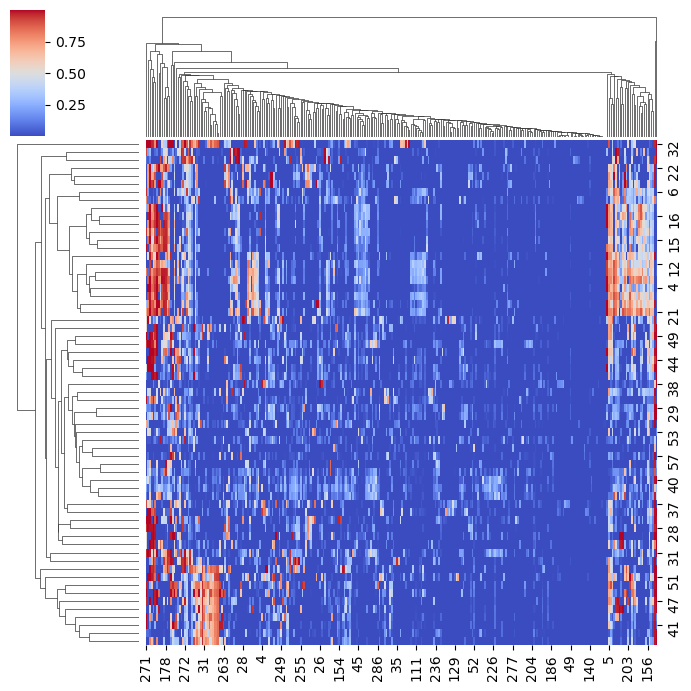

In [244]:
if clustering_method == 'hdbscan':
    print(f'clustering method = {clustering_method}')
    clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
    cluster_labels = clusterer.fit_predict(embedding)
elif clustering_method == 'kmeans':
    kmeans = KMeans(n_clusters=n_clusters_kmean, random_state=random_seed, \
                    n_init="auto").fit(embedding)
    cluster_labels = kmeans.labels_
elif clustering_method == "hierarch_clust":
    df_tmp = df_speciesMetab.copy()
    df_tmp[df_tmp == 0] = 1e-4
    cluster_labels = hierarchical_cluster_metabs(df_tmp.copy(), \
                                                 n_clusters=n_clusters_hclust, metric=distance_metric)

# Perform clustering

if np.min(cluster_labels) == -1:
    cluster_labels_new = post_process_hdbscan_clusters(cluster_labels)
else:
    cluster_labels_new = cluster_labels.copy()

clust_labels, clust_counts = np.unique(cluster_labels_new, return_counts=True)
print(clust_labels)
print(clust_counts)

df_metabs_clusters = pd.DataFrame()
df_metabs_clusters["cluster_labels"] = clust_labels
df_metabs_clusters["cluster_counts"] = clust_counts

cluster_metab_IDs = []
cluser_metab_names = []
for label_ in clust_labels:
    id_label = np.where(cluster_labels_new == label_)[0]
    cluster_metab_IDs.append(list(id_label))
    cluser_metab_names.append(list(metab_names[id_label]))  
    
df_metabs_clusters["cluster_metab_IDs"] = cluster_metab_IDs
df_metabs_clusters["cluser_metab_names"] = cluser_metab_names

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_cluster_metabolites_umap_{distance_metric}' + \
                                        f'_dim{dim_project}_randomSeed{random_seed}_clustMethod' + \
                                        f'_{clustering_method}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_metabolite_cluster_dataframe_umap_{distance_metric}.csv'))
df_metabs_clusters.to_csv(file_save, index=False)

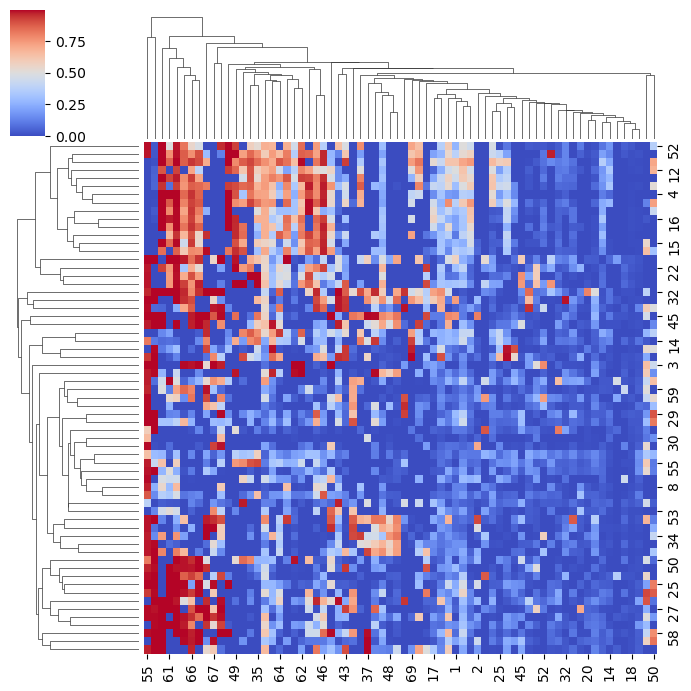

In [226]:
id_order = np.argsort(-df_metabs_clusters["Ri"].values)
cluster_labels = hierarchical_cluster_metabs(df_speciesMetab_cluster.iloc[:, id_order].copy(), \
                                             n_clusters=70, metric="euclidean")

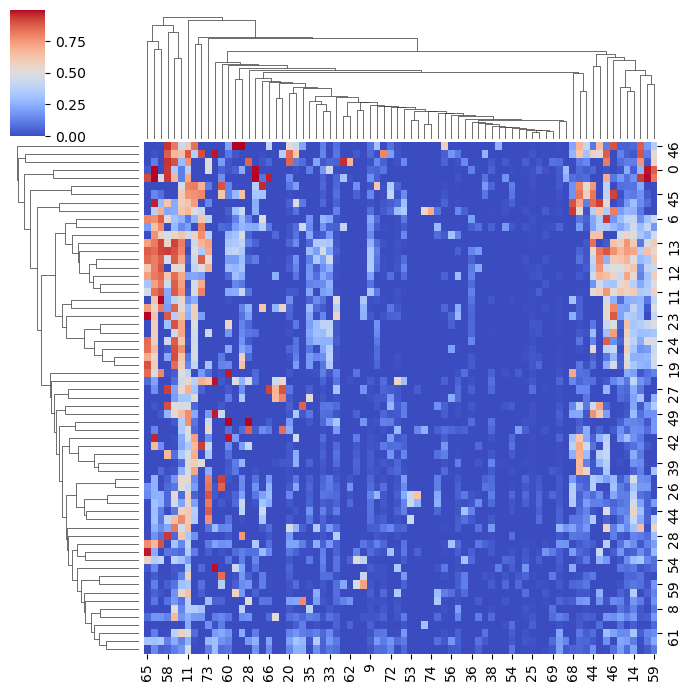

In [234]:
bin_thresh = 0.3
df_tmp = df_speciesMetab.copy()
df_tmp[df_tmp < bin_thresh] = 0
df_tmp[df_tmp >= bin_thresh] = 1
cluster_labels = hierarchical_cluster_metabs(df_speciesMetab_cluster.copy(), \
                                             n_clusters=n_clusters_hclust, metric=distance_metric)

In [245]:
df_speciesMetab_tmp = df_speciesMetab.copy()
df_speciesMetab_tmp[df_speciesMetab_tmp == 0] = 1e-6
df_speciesMetab_cluster = pd.DataFrame()
for metab_label in range(df_metabs_clusters.shape[0]):
    id_metabs = df_metabs_clusters.iloc[metab_label, 2]
    consm_vec = np.zeros((num_species))
    
    if metab_cluster_mean_func == "geometric":
        for id_ in id_metabs:
            consm_vec += np.log10(df_speciesMetab_tmp.iloc[:, id_].values)
        consm_vec /= len(id_metabs)
        df_speciesMetab_cluster[metab_label] = 10**consm_vec
    elif metab_cluster_mean_func == "linear":
        for id_ in id_metabs:
            consm_vec += df_speciesMetab.copy().iloc[:, id_].values
        consm_vec /= len(id_metabs)
        df_speciesMetab_cluster[metab_label] = consm_vec

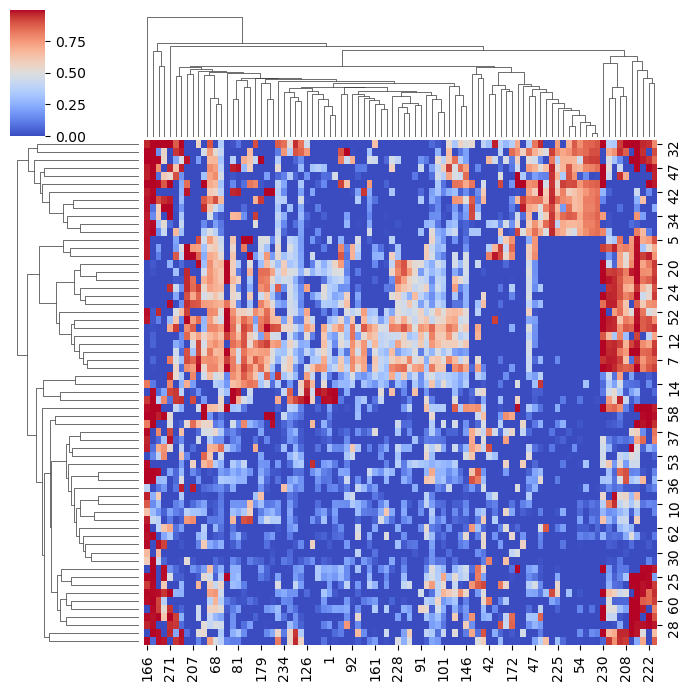

In [258]:
bin_thresh = 0.3
df_tmp = df_speciesMetab.copy()
df_tmp[df_tmp < bin_thresh] = 0
df_tmp[df_tmp >= bin_thresh] = 1

sum_ = np.sum(np.array(df_tmp), axis=0)
id_ = np.where(sum_ >= 10)[0]
len(id_)
df_tmp = df_tmp.iloc[:, id_]


cluster_labels = hierarchical_cluster_metabs(df_speciesMetab.iloc[:, id_].copy(), \
                                             n_clusters=n_clusters_hclust, metric=distance_metric)

136


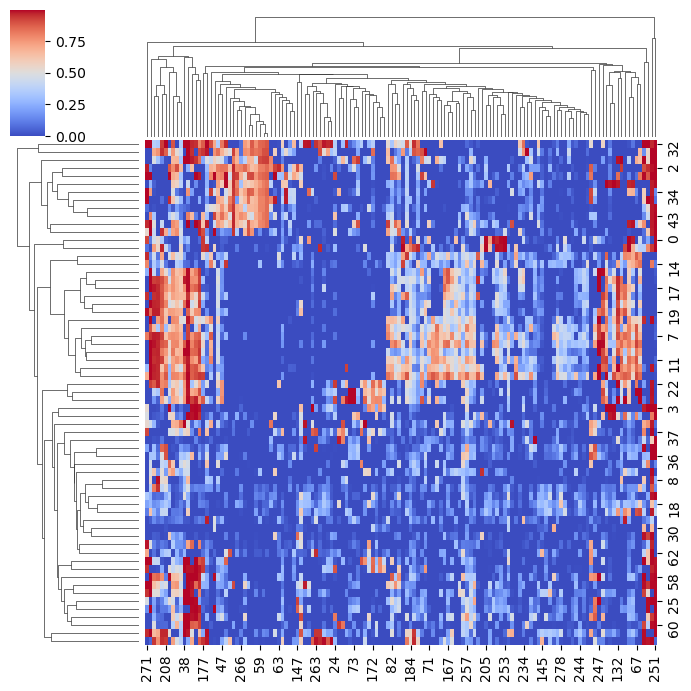

In [265]:
bin_thresh = 0.3
df_tmp = df_speciesMetab.copy()
df_tmp[df_tmp < bin_thresh] = 0
df_tmp[df_tmp >= bin_thresh] = 1

sum_ = np.sum(np.array(df_tmp), axis=0)
id_ = np.where(sum_ >= 5)[0]
len(id_)
df_tmp = df_tmp.iloc[:, id_]
print(len(id_))

cluster_labels = hierarchical_cluster_metabs(df_speciesMetab.iloc[:, id_].copy(), \
                                             n_clusters=n_clusters_hclust, metric=distance_metric)

## Fit steady state Ri for passages 456 and dynamic for 123

In [161]:
# Fit using no-microcosm agar
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
num_passages = 6
p_tmp = 0
Ri_noMicrocosm_hybrid_fit_all = {}
Ri_noMicrocosm_hybrid_fit_avg = {}
Ri_noMicrocosm_hybrid_fit_joint = {}
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
num_metabs = df_speciesMetab_tmp.shape[1]

# data for steady state fit
pass_rm = [0, 1, 2]
pass_keep = remove_passages(pass_rm, num_passages=6)
df_speciesAbun_tmp = df_speciesAbun_mdl.copy().iloc[:, pass_keep]

# data for dynamics fit
pass_rm = [2, 3, 4]
pass_keep = remove_passages(pass_rm, num_passages=5)
df_speciesAbun_prev_tmp = df_speciesAbun_prev_mdl.copy().iloc[:, pass_keep]
df_speciesAbun_next_tmp = df_speciesAbun_next_mdl.copy().iloc[:, pass_keep]
df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_mdl.copy().iloc[:, pass_keep]

for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count = {count_p}, p = {p_tmp}')
    Ri_noMicrocosm_hybrid_fit_all[count_p] = np.zeros((num_species, num_metabs))
    Ri_noMicrocosm_hybrid_fit_avg[count_p] = np.zeros((num_metabs))
    Ri_noMicrocosm_hybrid_fit_joint[count_p] = compute_Ri_ss(df_speciesMetab_tmp.copy(), \
                                                         df_speciesAbun_tmp.copy(), \
                                                         df_speciesAbun_tmp.copy(), \
                                                         0, \
                                                         range(num_species))
    Ri_noMicrocosm_hybrid_fit_joint[count_p] = \
        compute_Ri_hybrid(df_speciesMetab_tmp.copy(), df_speciesAbun_tmp, df_speciesAbun_prev_tmp, \
                          df_speciesAbun_next_tmp, df_speciesAbun_ratio_tmp, num_passages, \
                          p_tmp, range(num_species))
    count_species = 0
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_noMicrocosm_hybrid_fit_all[count_p][species_, :] = \
            compute_Ri_hybrid(df_speciesMetab_tmp.copy(), df_speciesAbun_tmp, df_speciesAbun_prev_tmp, \
                              df_speciesAbun_next_tmp, df_speciesAbun_ratio_tmp, num_passages, \
                              p_tmp, id_species)
        if np.sum(Ri_noMicrocosm_hybrid_fit_all[count_p][species_, :]) <= 1.5:
            Ri_noMicrocosm_hybrid_fit_avg[count_p] += \
                Ri_noMicrocosm_hybrid_fit_all[count_p][species_, :]
            count_species += 1


    Ri_noMicrocosm_hybrid_fit_avg[count_p] /= count_species
    
    
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                        f'_Ri_fit_hybrid' + \
                                        f'_cluster_metabolites_umap_{distance_metric}' + \
                                        f'_dim{dim_project}'+ \
                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                        f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                        f'_randomSeed{random_seed}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_Ri_fit_hybrid' + \
                                         f'_different_p_LeaveOneOutRi_cluster_metabolites' + \
                                         f'_umap_{distance_metric}' + \
                                         f'_dim{dim_project}'+ \
                                         f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                         f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                         f'_randomSeed{random_seed}.pickle'))

save_obj = {"Ri_noMicrocosm_hybrid_fit_all" : Ri_noMicrocosm_hybrid_fit_all, \
            "Ri_noMicrocosm_hybrid_fit_avg" : Ri_noMicrocosm_hybrid_fit_avg, \
            "Ri_noMicrocosm_hybrid_fit_joint" : Ri_noMicrocosm_hybrid_fit_joint}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_) 

count = 0, p = 0.001
count = 1, p = 0.01
count = 2, p = 0.05
count = 3, p = 0.06
count = 4, p = 0.07
count = 5, p = 0.08
count = 6, p = 0.09
count = 7, p = 0.1
count = 8, p = 0.125
count = 9, p = 0.15
count = 10, p = 0.175
count = 11, p = 0.2
count = 12, p = 0.3
count = 13, p = 0.4
count = 14, p = 0.5
count = 15, p = 0.55
count = 16, p = 0.6
count = 17, p = 0.65
count = 18, p = 0.7


In [182]:
count_p = 7

for count_p, p_tmp in enumerate(p_vec_new):
    print(f'p = {p_vec_new[count_p]}')
    lhs_, rhs_, samples_rm, species_rm = compute_Ri_ss_goodness_of_fit(df_speciesMetab_tmp, \
                                                                       df_speciesAbun_tmp, df_speciesAbun_tmp, \
                                                                       range(num_species), \
                                                                       Ri_noMicrocosm_hybrid_fit_avg[count_p])
    
    
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'RHS vs LHS for Ri fitted hybrid, p = {p_tmp} for dynamics', \
                 fontsize=20)
    fig.supylabel('RHS (log scale)', fontsize=30)
    fig.supxlabel('LHS (log scale)', fontsize=30)

    x = np.log10(lhs_)
    y = np.log10(rhs_)

    plt_ = sns.scatterplot(x=x, \
                           y=y, ax=axes)

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                       ax=axes)
    plt_.plot([-8, 0], [-8, 0], c="red")
    #             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)
    corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                               (y - np.mean(y)) / np.std(y))

    model = sm.OLS(rhs_, lhs_).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]
    rms_ = np.sqrt(np.mean(np.power(np.log10(lhs_) - np.log10(rhs_), 2)))


    plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope)], c="green")

    title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe[1]) + \
             f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe_log[1]) + \
             f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1]) + \
             f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                    '{:.3e}'.format(slope_pval) + f', RMSE = {np.round(rms_, 3)}'

    axes.set_title(title_, size=20)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                            'predictions', 'leaveOneOut', \
                                            f'{date_}_predict_abundance_blind_growth_ratio' + \
                                            f'_Ri_fit_hybrid' + \
                                            f'_cluster_metabolites_umap_{distance_metric}' + \
                                            f'_dim{dim_project}'+ \
                                            f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                            f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                            f'_randomSeed{random_seed}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'{date_}_RHS_vs_LHS_Ri_fit_hybrid_p{p_tmp}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

p = 0.001
p = 0.01
p = 0.05
p = 0.06
p = 0.07
p = 0.08
p = 0.09
p = 0.1
p = 0.125
p = 0.15
p = 0.175
p = 0.2
p = 0.3
p = 0.4
p = 0.5
p = 0.55
p = 0.6
p = 0.65
p = 0.7


0.11445871727947302
PearsonRResult(statistic=0.953785830009687, pvalue=3.295480447011138e-297)


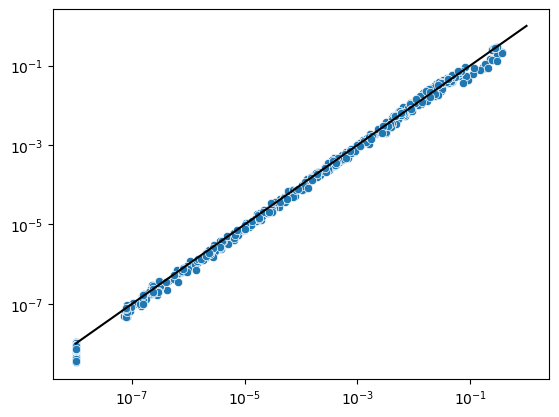

In [180]:
id_ = range(len(lhs_))
plt_ = sns.scatterplot(x=lhs_[id_], y=rhs_[id_])
print(np.sqrt(np.mean(np.power(np.log10(lhs_) - np.log10(rhs_), 2))))
plt_.plot([1e-8, 1e0], [1e-8, 1e0], c="black")
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)
print(scipy.stats.pearsonr(lhs_[id_], rhs_[id_]))

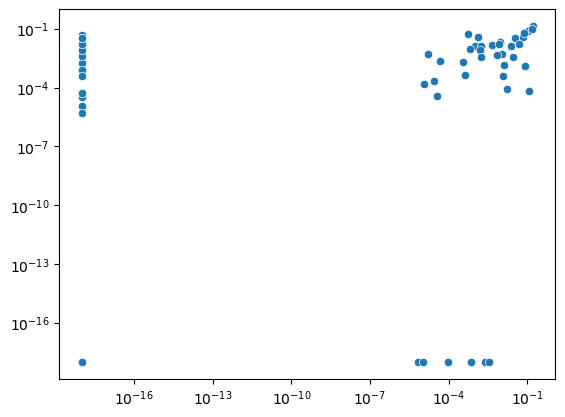

In [181]:
x = Ri_noMicrocosm_ss_fit_avg[3].copy()
y = Ri_noMicrocosm_hybrid_fit_avg[count_p].copy()
thresh_ = 1e-18
x[x == 0] = thresh_
y[y == 0] = thresh_

id_ = np.where((x >= thresh_) & (y >= thresh_))
plt_ = sns.scatterplot(x=x[id_], y=y[id_])
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)

## Predict abundance and growth ratio

In [188]:
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
#                     fac_ = 1 / np.sum(df_speciesAbun_prev_tmp_[col_].values)
#                     df_speciesAbun_prev_tmp_[col_] = fac_ * \
#                         df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_noMicrocosm_hubrid_fit_avg[count_p].copy()
#             Ri_avg = Ri_noMicrocosm_fit_avg[p_tmp].copy()
#             Ri_avg /= np.sum(Ri_avg)
#             Ri_avg = Ri_clust_to_all(Ri_noMicrocosm_fit_avg[p_tmp].copy(), \
#                                      df_metabs_clusters, df_speciesMetab.shape[1]) 
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#             fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
#                          f'Ri hubrid, cluster_metabolites, ' + \
#                          f'umap_{distance_metric} dim{dim_project}, ' + \
#                          f'cluster_meanFunc_{metab_cluster_mean_func}, ' + \
#                          f'cluster method {clustering_method}, {microcosm_type}' + \
#                          f', randomSeed{random_seed}', \
#                          fontsize=10)
            fig.supylabel('predicted abundance (log scale)', fontsize=25)
            fig.supxlabel('observed abundance (log scale)', fontsize=25)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, df_speciesMetab_tmp,
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_hubrid' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_hubrid' + \
                                                     f'_with_p{p_tmp}_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}' + \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values
#                 fac_ = 1 / np.sum(df_tmp[col_].values)
#                 df_tmp[col_] = fac_ * \
#                     df_tmp[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun_mdl.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where((x > 0) & (y > 0))[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]
            
            if (pass_ == 2) & (p_tmp == 0.1):
                id_sp = np.where((x <= -6) & (y >= -5))[0]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(10**y, 10**x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]
            
            model_log = sm.OLS(y, x).fit()
            slope_log = model_log.params[0]
            slope_log_pval = model_log.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 8, 
                                   "passage" : [pass_] * 8, 
                                   "p" : [p_tmp] * 8, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "slope_log", \
                                                    "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, slope_log, \
                                               corr_val_pe[0], abs_mean_error, \
                                               std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, slope_log_pval, \
                                             corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


#             plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")
            plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope * 1)], c="green")
            plt_.plot([-8, 0], [(slope_log * (-8)), (slope_log * 0)], c="blue")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)} pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                            '{:.3e}'.format(slope_log_pval) + \
                     f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=15)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_hubrid' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'{date_}_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_hubrid' + \
                                                     f'_p{p_tmp}_{norm_status}' + \
                                                     f'_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}'+ \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)
            
# Plot growth ratios
            
            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#             fig.suptitle(f'predicted vs observed growth ratio passage {pass_}->{pass_ + 1}, \n' + 
#                          f'Ri hubrid, cluster_metabolites, ' + \
#                          f'umap_{distance_metric} dim{dim_project}, ' + \
#                          f'cluster_meanFunc_{metab_cluster_mean_func}, ' + \
#                          f'cluster method {clustering_method}, {microcosm_type}' + \
#                          f', randomSeed{random_seed}', \
#                          fontsize=10)
            fig.supylabel('predicted growth ratio (log scale)', fontsize=25)
            fig.supxlabel('observed growth ratio (log scale)', fontsize=25)
            if pass_ > 0:
                pass_tmp = pass_ - 1
                df_speciesAbun_ratio_tmp_1 = \
                    df_speciesAbun_ratio_mdl.copy().iloc[:, [pass_tmp, pass_tmp + 5, pass_tmp + 10]]
                b_ = range(3)
                x = \
                    np.array(df_speciesAbun_ratio_tmp_1)
                x_new = -1 * np.ones(x.shape[0])
                for row_ in range(x.shape[0]):
                    id_tmp = np.where(x[row_, :] > 0)[0]
                    if len(id_tmp) > 0:
                        x_new[row_] = 10**np.mean(np.log10(x[row_, id_tmp]))
                id_tmp = np.where(x_new > 0)[0]
                x = x_new[id_tmp]
    #                 x = 10**(np.mean(np.log10(x), axis=1)).flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, :].flatten()
                y = y[id_tmp]
            else:
                x = np.array(df_speciesAbun_mdl.iloc[:, [pass_, pass_ + 6, pass_ + 12]])
                x = 10**np.mean(np.log10(x), axis=1).flatten()
                x /= np.array(df_speciesAbun_inoc).flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, :].flatten()

            id_ = np.where((x > 0) & (y > 0))[0]
#                 id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

#                 if (pass_ == 2) & (p_tmp == 0.1):
#                     id_sp = np.where((x <= -6) & (y >= -5))[0]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-4, 2], [-4, 2], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(10**y, 10**x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]
            
            model_log = sm.OLS(y, x).fit()
            slope_log = model_log.params[0]
            slope_log_pval = model_log.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
#                 df_tmp = \
#                     pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
#                                        "passage" : [pass_] * 7, 
#                                        "p" : [p_tmp] * 7, 
#                                        "metric_type" : ["corr_pearson_log", 
#                                                         "corr_spearman", "slope", "corr_pearson_linear", \
#                                                         "abs_median_error", \
#                                                         "std_error", "FNR"], 
#                                        "metric" : [corr_val_pe_log[0], 
#                                                    corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, \
#                                                    std_error, \
#                                                    frac_zero],
#                                        "pval" : [corr_val_pe_log[1], 
#                                                  corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
#                 df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-4, 2], [np.log10(slope * (1e-4)), np.log10(slope * 1e2)], c="green")
            plt_.plot([-4, 2], [(slope_log * (-4)), (slope_log * 2)], c="blue")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)} pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                            '{:.3e}'.format(slope_log_pval) + \
                     f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=15)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_hubrid' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_growth_ratio_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_}->{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'{date_}_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_hubrid' + \
                                                     f'_p{p_tmp}_{norm_status}' + \
                                                     f'_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}'+ \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [189]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=30)
    fig.supxlabel('p', fontsize=30)
    fig.supylabel('correlation or slope', fontsize=30)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                f'_Ri_fit_hybrid' + \
                                                f'_cluster_metabolites_umap_{distance_metric}' + \
                                                f'_dim{dim_project}'+ \
                                                f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                f'_randomSeed{random_seed}', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'{date_}_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                             f'_Ri_fit_hybrid_cluster_metabolites' + \
                                             f'_umap_{distance_metric}' + \
                                             f'_dim{dim_project}' + \
                                             f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                             f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                             f'_randomSeed{random_seed}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

# Fit dynamic Ri for passage transitions 1->2, and 2->3

In [190]:
# Fit using no-microcosm agar
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
num_passages = 6
p_tmp = 0
Ri_noMicrocosm_dynamic_fit_all = {}
Ri_noMicrocosm_dynamic_fit_avg = {}
Ri_noMicrocosm_dynamic_fit_joint = {}
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
num_metabs = df_speciesMetab_tmp.shape[1]

# data for steady state fit
pass_rm = [0, 1, 2]
pass_keep = remove_passages(pass_rm, num_passages=6)
df_speciesAbun_tmp = df_speciesAbun_mdl.copy().iloc[:, pass_keep]

# data for dynamics fit
pass_rm = [2, 3, 4]
pass_keep = remove_passages(pass_rm, num_passages=5)
df_speciesAbun_prev_tmp = df_speciesAbun_prev_mdl.copy().iloc[:, pass_keep]
df_speciesAbun_next_tmp = df_speciesAbun_next_mdl.copy().iloc[:, pass_keep]
df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_mdl.copy().iloc[:, pass_keep]

for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count = {count_p}, p = {p_tmp}')
    Ri_noMicrocosm_dynamic_fit_all[count_p] = np.zeros((num_species, num_metabs))
    Ri_noMicrocosm_dynamic_fit_avg[count_p] = np.zeros((num_metabs))
    Ri_noMicrocosm_dynamic_fit_joint[count_p] = compute_Ri_ss(df_speciesMetab_tmp.copy(), \
                                                         df_speciesAbun_tmp.copy(), \
                                                         df_speciesAbun_tmp.copy(), \
                                                         0, \
                                                         range(num_species))
#     Ri_noMicrocosm_dynamic_fit_joint[count_p] = \
#         compute_Ri_dynamic(df_speciesMetab_tmp.copy(), df_speciesAbun_tmp, df_speciesAbun_prev_tmp, \
#                           df_speciesAbun_next_tmp, df_speciesAbun_ratio_tmp, num_passages, \
#                           p_tmp, range(num_species))
    Ri_noMicrocosm_dynamic_fit_joint[count_p] = \
        compute_Ri(df_speciesMetab_tmp.copy(), df_speciesAbun_prev_tmp, \
                   df_speciesAbun_next_tmp, df_speciesAbun_ratio_tmp, \
                   p_tmp, num_passages, range(num_species))
    count_species = 0
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_noMicrocosm_dynamic_fit_all[count_p][species_, :] = \
            compute_Ri(df_speciesMetab_tmp.copy(), df_speciesAbun_prev_tmp, \
                       df_speciesAbun_next_tmp, df_speciesAbun_ratio_tmp, \
                       p_tmp, num_passages, id_species)
        if np.sum(Ri_noMicrocosm_dynamic_fit_all[count_p][species_, :]) <= 1.5:
            Ri_noMicrocosm_dynamic_fit_avg[count_p] += \
                Ri_noMicrocosm_dynamic_fit_all[count_p][species_, :]
            count_species += 1


    Ri_noMicrocosm_dynamic_fit_avg[count_p] /= count_species
    
    
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                        f'_Ri_fit_dynamic' + \
                                        f'_cluster_metabolites_umap_{distance_metric}' + \
                                        f'_dim{dim_project}'+ \
                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                        f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                        f'_randomSeed{random_seed}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_Ri_fit_dynamic' + \
                                         f'_different_p_LeaveOneOutRi_cluster_metabolites' + \
                                         f'_umap_{distance_metric}' + \
                                         f'_dim{dim_project}'+ \
                                         f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                         f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                         f'_randomSeed{random_seed}.pickle'))

save_obj = {"Ri_noMicrocosm_dynamic_fit_all" : Ri_noMicrocosm_dynamic_fit_all, \
            "Ri_noMicrocosm_dynamic_fit_avg" : Ri_noMicrocosm_dynamic_fit_avg, \
            "Ri_noMicrocosm_dynamic_fit_joint" : Ri_noMicrocosm_dynamic_fit_joint}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_) 

count = 0, p = 0.001
count = 1, p = 0.01
count = 2, p = 0.05
count = 3, p = 0.06
count = 4, p = 0.07
count = 5, p = 0.08
count = 6, p = 0.09
count = 7, p = 0.1
count = 8, p = 0.125
count = 9, p = 0.15
count = 10, p = 0.175
count = 11, p = 0.2
count = 12, p = 0.3
count = 13, p = 0.4
count = 14, p = 0.5
count = 15, p = 0.55
count = 16, p = 0.6
count = 17, p = 0.65
count = 18, p = 0.7


In [191]:
count_p = 7

for count_p, p_tmp in enumerate(p_vec_new):
    print(f'p = {p_vec_new[count_p]}')
    lhs_, rhs_, samples_rm, species_rm = compute_Ri_ss_goodness_of_fit(df_speciesMetab_tmp, \
                                                                       df_speciesAbun_tmp, df_speciesAbun_tmp, \
                                                                       range(num_species), \
                                                                       Ri_noMicrocosm_dynamic_fit_avg[count_p])
    
    
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'RHS vs LHS for Ri fitted dynamic, p = {p_tmp} for dynamics', \
                 fontsize=20)
    fig.supylabel('RHS (log scale)', fontsize=30)
    fig.supxlabel('LHS (log scale)', fontsize=30)

    x = np.log10(lhs_)
    y = np.log10(rhs_)

    plt_ = sns.scatterplot(x=x, \
                           y=y, ax=axes)

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                       ax=axes)
    plt_.plot([-8, 0], [-8, 0], c="red")
    #             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)
    corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                               (y - np.mean(y)) / np.std(y))

    model = sm.OLS(rhs_, lhs_).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]
    rms_ = np.sqrt(np.mean(np.power(np.log10(lhs_) - np.log10(rhs_), 2)))


    plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope)], c="green")

    title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe[1]) + \
             f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe_log[1]) + \
             f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1]) + \
             f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                    '{:.3e}'.format(slope_pval) + f', RMSE = {np.round(rms_, 3)}'

    axes.set_title(title_, size=20)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                            'predictions', 'leaveOneOut', \
                                            f'{date_}_predict_abundance_blind_growth_ratio' + \
                                            f'_Ri_fit_dynamic' + \
                                            f'_cluster_metabolites_umap_{distance_metric}' + \
                                            f'_dim{dim_project}'+ \
                                            f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                            f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                            f'_randomSeed{random_seed}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'{date_}_RHS_vs_LHS_Ri_fit_dynamic_p{p_tmp}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

p = 0.001
p = 0.01
p = 0.05
p = 0.06
p = 0.07
p = 0.08
p = 0.09
p = 0.1
p = 0.125
p = 0.15
p = 0.175
p = 0.2
p = 0.3
p = 0.4
p = 0.5
p = 0.55
p = 0.6
p = 0.65
p = 0.7


PearsonRResult(statistic=0.6429527261783085, pvalue=5.456699844442879e-05)
PearsonRResult(statistic=0.4228873725448524, pvalue=0.014210302543617862)


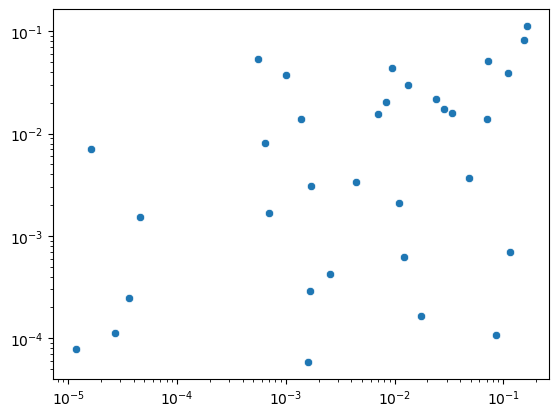

In [218]:
count_p = 7
x = Ri_noMicrocosm_ss_fit_avg[3].copy()
y = Ri_noMicrocosm_dynamic_fit_avg[count_p].copy()
thresh_ = 1e-18
x[x == 0] = thresh_
y[y == 0] = thresh_

id_ = np.where((x > thresh_) & (y > thresh_))
plt_ = sns.scatterplot(x=x[id_], y=y[id_])
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)
print(scipy.stats.pearsonr(x[id_], y[id_]))
print(scipy.stats.pearsonr(np.log10(x[id_]), np.log10(y[id_])))

In [219]:
id_order = np.argsort(-Ri_noMicrocosm_ss_fit_avg[3])
df_metabs_clusters["Ri"] = Ri_noMicrocosm_ss_fit_avg[3]
df_metabs_clusters.iloc[id_order[range(20)], :]
# Ri_noMicrocosm_ss_fit_avg[3][id_order[range(11)]]

,cluster_labels,cluster_counts,cluster_metab_IDs,cluser_metab_names,Ri
18,18,72,"[6, 10, 16, 18, 25, 27, 30, 33, 36, 40, 41, 46...","[VALINE, 1,3-DIAMINOPROPANE, 5-METHYLCYTOSINE,...",0.163702
55,55,1,[166],[5'-METHYLTHIOADENOSINE],0.154726
4,4,11,"[29, 34, 43, 44, 45, 48, 116, 189, 244, 268, 275]","[PHOSPHOCHOLINE, TRYPTOPHAN ETHYL ESTER, IS_CA...",0.114647
16,16,2,"[66, 81]","[CITRIC ACID, PYRUVIC ACID]",0.109479
29,29,1,[169],[ADENOSINE],0.085197
56,56,1,[217],[HYPOXANTHINE],0.072184
19,19,3,"[1, 155, 253]","[N-METHYL-ASPARTIC ACID, 4-AMINOBUTANOIC ACID,...",0.070172
67,67,1,[288],[URACIL],0.048510
0,0,33,"[2, 7, 11, 13, 17, 21, 22, 32, 35, 119, 120, 1...","[2-AMINO-2-METHYLPROPANOIC ACID, SUCROSE, 3-HY...",0.033586
34,34,1,[270],[RIBOFLAVIN],0.028150


In [195]:
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
#                     fac_ = 1 / np.sum(df_speciesAbun_prev_tmp_[col_].values)
#                     df_speciesAbun_prev_tmp_[col_] = fac_ * \
#                         df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_noMicrocosm_dynamic_fit_avg[count_p].copy()
#             Ri_avg = Ri_noMicrocosm_fit_avg[p_tmp].copy()
#             Ri_avg /= np.sum(Ri_avg)
#             Ri_avg = Ri_clust_to_all(Ri_noMicrocosm_fit_avg[p_tmp].copy(), \
#                                      df_metabs_clusters, df_speciesMetab.shape[1]) 
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#             fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
#                          f'Ri dynamic, cluster_metabolites, ' + \
#                          f'umap_{distance_metric} dim{dim_project}, ' + \
#                          f'cluster_meanFunc_{metab_cluster_mean_func}, ' + \
#                          f'cluster method {clustering_method}, {microcosm_type}' + \
#                          f', randomSeed{random_seed}', \
#                          fontsize=10)
            fig.supylabel('predicted abundance (log scale)', fontsize=25)
            fig.supxlabel('observed abundance (log scale)', fontsize=25)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, df_speciesMetab_tmp,
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_dynamic' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_dynamic' + \
                                                     f'_with_p{p_tmp}_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}' + \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values
#                 fac_ = 1 / np.sum(df_tmp[col_].values)
#                 df_tmp[col_] = fac_ * \
#                     df_tmp[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun_mdl.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where((x > 0) & (y > 0))[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]
            
            if (pass_ == 2) & (p_tmp == 0.1):
                id_sp = np.where((x <= -6) & (y >= -5))[0]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(10**y, 10**x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]
            
            model_log = sm.OLS(y, x).fit()
            slope_log = model_log.params[0]
            slope_log_pval = model_log.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 8, 
                                   "passage" : [pass_] * 8, 
                                   "p" : [p_tmp] * 8, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "slope_log", \
                                                    "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, slope_log, \
                                               corr_val_pe[0], abs_mean_error, \
                                               std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, slope_log_pval, \
                                             corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


#             plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")
            plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope * 1)], c="green")
            plt_.plot([-8, 0], [(slope_log * (-8)), (slope_log * 0)], c="blue")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)} pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                            '{:.3e}'.format(slope_log_pval) + \
                     f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=15)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_dynamic' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'{date_}_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_dynamic' + \
                                                     f'_p{p_tmp}_{norm_status}' + \
                                                     f'_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}'+ \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)
            
# Plot growth ratios
            
            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#             fig.suptitle(f'predicted vs observed growth ratio passage {pass_}->{pass_ + 1}, \n' + 
#                          f'Ri dynamic, cluster_metabolites, ' + \
#                          f'umap_{distance_metric} dim{dim_project}, ' + \
#                          f'cluster_meanFunc_{metab_cluster_mean_func}, ' + \
#                          f'cluster method {clustering_method}, {microcosm_type}' + \
#                          f', randomSeed{random_seed}', \
#                          fontsize=10)
            fig.supylabel('predicted growth ratio (log scale)', fontsize=25)
            fig.supxlabel('observed growth ratio (log scale)', fontsize=25)
            if pass_ > 0:
                pass_tmp = pass_ - 1
                df_speciesAbun_ratio_tmp_1 = \
                    df_speciesAbun_ratio_mdl.copy().iloc[:, [pass_tmp, pass_tmp + 5, pass_tmp + 10]]
                b_ = range(3)
                x = \
                    np.array(df_speciesAbun_ratio_tmp_1)
                x_new = -1 * np.ones(x.shape[0])
                for row_ in range(x.shape[0]):
                    id_tmp = np.where(x[row_, :] > 0)[0]
                    if len(id_tmp) > 0:
                        x_new[row_] = 10**np.mean(np.log10(x[row_, id_tmp]))
                id_tmp = np.where(x_new > 0)[0]
                x = x_new[id_tmp]
    #                 x = 10**(np.mean(np.log10(x), axis=1)).flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, :].flatten()
                y = y[id_tmp]
            else:
                x = np.array(df_speciesAbun_mdl.iloc[:, [pass_, pass_ + 6, pass_ + 12]])
                x = 10**np.mean(np.log10(x), axis=1).flatten()
                x /= np.array(df_speciesAbun_inoc).flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, :].flatten()

            id_ = np.where((x > 0) & (y > 0))[0]
#                 id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

#                 if (pass_ == 2) & (p_tmp == 0.1):
#                     id_sp = np.where((x <= -6) & (y >= -5))[0]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-4, 2], [-4, 2], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(10**y, 10**x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]
            
            model_log = sm.OLS(y, x).fit()
            slope_log = model_log.params[0]
            slope_log_pval = model_log.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
#                 df_tmp = \
#                     pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
#                                        "passage" : [pass_] * 7, 
#                                        "p" : [p_tmp] * 7, 
#                                        "metric_type" : ["corr_pearson_log", 
#                                                         "corr_spearman", "slope", "corr_pearson_linear", \
#                                                         "abs_median_error", \
#                                                         "std_error", "FNR"], 
#                                        "metric" : [corr_val_pe_log[0], 
#                                                    corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, \
#                                                    std_error, \
#                                                    frac_zero],
#                                        "pval" : [corr_val_pe_log[1], 
#                                                  corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
#                 df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-4, 2], [np.log10(slope * (1e-4)), np.log10(slope * 1e2)], c="green")
            plt_.plot([-4, 2], [(slope_log * (-4)), (slope_log * 2)], c="blue")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)} pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                            '{:.3e}'.format(slope_log_pval) + \
                     f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=15)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_dynamic' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_growth_ratio_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_}->{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'{date_}_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_dynamic' + \
                                                     f'_p{p_tmp}_{norm_status}' + \
                                                     f'_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}'+ \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [196]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=30)
    fig.supxlabel('p', fontsize=30)
    fig.supylabel('correlation or slope', fontsize=30)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                f'_Ri_fit_dynamic' + \
                                                f'_cluster_metabolites_umap_{distance_metric}' + \
                                                f'_dim{dim_project}'+ \
                                                f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                f'_randomSeed{random_seed}', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'{date_}_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                             f'_Ri_fit_dynamic_cluster_metabolites' + \
                                             f'_umap_{distance_metric}' + \
                                             f'_dim{dim_project}' + \
                                             f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                             f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                             f'_randomSeed{random_seed}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

# Fit dynamic Ri all passages

In [201]:
# Fit using no-microcosm agar
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
num_passages = 6
p_tmp = 0
Ri_noMicrocosm_dynamicAll_fit_all = {}
Ri_noMicrocosm_dynamicAll_fit_avg = {}
Ri_noMicrocosm_dynamicAll_fit_joint = {}
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
num_metabs = df_speciesMetab_tmp.shape[1]

# data for steady state fit
pass_rm = [0, 1, 2]
pass_keep = remove_passages(pass_rm, num_passages=6)
df_speciesAbun_tmp = df_speciesAbun_mdl.copy().iloc[:, pass_keep]

# data for dynamicAlls fit
pass_rm = []
pass_keep = remove_passages(pass_rm, num_passages=5)
df_speciesAbun_prev_tmp = df_speciesAbun_prev_mdl.copy().iloc[:, pass_keep]
df_speciesAbun_next_tmp = df_speciesAbun_next_mdl.copy().iloc[:, pass_keep]
df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_mdl.copy().iloc[:, pass_keep]

for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count = {count_p}, p = {p_tmp}')
    Ri_noMicrocosm_dynamicAll_fit_all[count_p] = np.zeros((num_species, num_metabs))
    Ri_noMicrocosm_dynamicAll_fit_avg[count_p] = np.zeros((num_metabs))
#     Ri_noMicrocosm_dynamicAll_fit_joint[count_p] = compute_Ri_ss(df_speciesMetab_tmp.copy(), \
#                                                          df_speciesAbun_tmp.copy(), \
#                                                          df_speciesAbun_tmp.copy(), \
#                                                          0, \
#                                                          range(num_species))
#     Ri_noMicrocosm_dynamicAll_fit_joint[count_p] = \
#         compute_Ri_dynamicAll(df_speciesMetab_tmp.copy(), df_speciesAbun_tmp, df_speciesAbun_prev_tmp, \
#                           df_speciesAbun_next_tmp, df_speciesAbun_ratio_tmp, num_passages, \
#                           p_tmp, range(num_species))
    Ri_noMicrocosm_dynamicAll_fit_joint[count_p] = \
        compute_Ri(df_speciesMetab_tmp.copy(), df_speciesAbun_prev_tmp, \
                   df_speciesAbun_next_tmp, df_speciesAbun_ratio_tmp, \
                   p_tmp, num_passages, range(num_species))
    count_species = 0
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_noMicrocosm_dynamicAll_fit_all[count_p][species_, :] = \
            compute_Ri(df_speciesMetab_tmp.copy(), df_speciesAbun_prev_tmp, \
                       df_speciesAbun_next_tmp, df_speciesAbun_ratio_tmp, \
                       p_tmp, num_passages, id_species)
        if np.sum(Ri_noMicrocosm_dynamicAll_fit_all[count_p][species_, :]) <= 1.5:
            Ri_noMicrocosm_dynamicAll_fit_avg[count_p] += \
                Ri_noMicrocosm_dynamicAll_fit_all[count_p][species_, :]
            count_species += 1


    Ri_noMicrocosm_dynamicAll_fit_avg[count_p] /= count_species
    
    
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                        f'_Ri_fit_dynamicAll' + \
                                        f'_cluster_metabolites_umap_{distance_metric}' + \
                                        f'_dim{dim_project}'+ \
                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                        f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                        f'_randomSeed{random_seed}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_Ri_fit_dynamicAll' + \
                                         f'_different_p_LeaveOneOutRi_cluster_metabolites' + \
                                         f'_umap_{distance_metric}' + \
                                         f'_dim{dim_project}'+ \
                                         f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                         f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                         f'_randomSeed{random_seed}.pickle'))

save_obj = {"Ri_noMicrocosm_dynamicAll_fit_all" : Ri_noMicrocosm_dynamicAll_fit_all, \
            "Ri_noMicrocosm_dynamicAll_fit_avg" : Ri_noMicrocosm_dynamicAll_fit_avg, \
            "Ri_noMicrocosm_dynamicAll_fit_joint" : Ri_noMicrocosm_dynamicAll_fit_joint}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_) 

count = 0, p = 0.001
count = 1, p = 0.01
count = 2, p = 0.05
count = 3, p = 0.06
count = 4, p = 0.07
count = 5, p = 0.08
count = 6, p = 0.09
count = 7, p = 0.1
count = 8, p = 0.125
count = 9, p = 0.15
count = 10, p = 0.175
count = 11, p = 0.2
count = 12, p = 0.3
count = 13, p = 0.4
count = 14, p = 0.5
count = 15, p = 0.55
count = 16, p = 0.6
count = 17, p = 0.65
count = 18, p = 0.7


In [202]:
count_p = 7

for count_p, p_tmp in enumerate(p_vec_new):
    print(f'p = {p_vec_new[count_p]}')
    lhs_, rhs_, samples_rm, species_rm = compute_Ri_ss_goodness_of_fit(df_speciesMetab_tmp, \
                                                                       df_speciesAbun_tmp, df_speciesAbun_tmp, \
                                                                       range(num_species), \
                                                                       Ri_noMicrocosm_dynamicAll_fit_avg[count_p])
    
    
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'RHS vs LHS for Ri fitted dynamicAll, p = {p_tmp} for dynamicAlls', \
                 fontsize=20)
    fig.supylabel('RHS (log scale)', fontsize=30)
    fig.supxlabel('LHS (log scale)', fontsize=30)

    x = np.log10(lhs_)
    y = np.log10(rhs_)

    plt_ = sns.scatterplot(x=x, \
                           y=y, ax=axes)

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                       ax=axes)
    plt_.plot([-8, 0], [-8, 0], c="red")
    #             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)
    corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                               (y - np.mean(y)) / np.std(y))

    model = sm.OLS(rhs_, lhs_).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]
    rms_ = np.sqrt(np.mean(np.power(np.log10(lhs_) - np.log10(rhs_), 2)))


    plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope)], c="green")

    title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe[1]) + \
             f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe_log[1]) + \
             f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1]) + \
             f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                    '{:.3e}'.format(slope_pval) + f', RMSE = {np.round(rms_, 3)}'

    axes.set_title(title_, size=20)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                            'predictions', 'leaveOneOut', \
                                            f'{date_}_predict_abundance_blind_growth_ratio' + \
                                            f'_Ri_fit_dynamicAll' + \
                                            f'_cluster_metabolites_umap_{distance_metric}' + \
                                            f'_dim{dim_project}'+ \
                                            f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                            f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                            f'_randomSeed{random_seed}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'{date_}_RHS_vs_LHS_Ri_fit_dynamicAll_p{p_tmp}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

p = 0.001
p = 0.01
p = 0.05
p = 0.06
p = 0.07
p = 0.08
p = 0.09
p = 0.1
p = 0.125
p = 0.15
p = 0.175
p = 0.2
p = 0.3
p = 0.4
p = 0.5
p = 0.55
p = 0.6
p = 0.65
p = 0.7


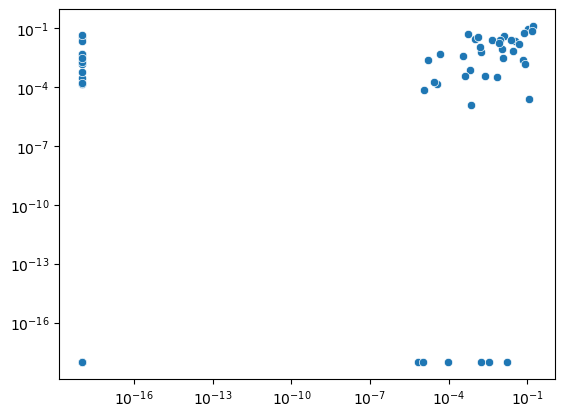

In [207]:
count_p = 7
x = Ri_noMicrocosm_ss_fit_avg[3].copy()
y = Ri_noMicrocosm_dynamicAll_fit_avg[count_p].copy()
thresh_ = 1e-18
x[x == 0] = thresh_
y[y == 0] = thresh_

id_ = np.where((x >= thresh_) & (y >= thresh_))
plt_ = sns.scatterplot(x=x[id_], y=y[id_])
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)

In [203]:
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
#                     fac_ = 1 / np.sum(df_speciesAbun_prev_tmp_[col_].values)
#                     df_speciesAbun_prev_tmp_[col_] = fac_ * \
#                         df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_noMicrocosm_dynamicAll_fit_avg[count_p].copy()
#             Ri_avg = Ri_noMicrocosm_fit_avg[p_tmp].copy()
#             Ri_avg /= np.sum(Ri_avg)
#             Ri_avg = Ri_clust_to_all(Ri_noMicrocosm_fit_avg[p_tmp].copy(), \
#                                      df_metabs_clusters, df_speciesMetab.shape[1]) 
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#             fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
#                          f'Ri dynamicAll, cluster_metabolites, ' + \
#                          f'umap_{distance_metric} dim{dim_project}, ' + \
#                          f'cluster_meanFunc_{metab_cluster_mean_func}, ' + \
#                          f'cluster method {clustering_method}, {microcosm_type}' + \
#                          f', randomSeed{random_seed}', \
#                          fontsize=10)
            fig.supylabel('predicted abundance (log scale)', fontsize=25)
            fig.supxlabel('observed abundance (log scale)', fontsize=25)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, df_speciesMetab_tmp,
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_dynamicAll' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_dynamicAll' + \
                                                     f'_with_p{p_tmp}_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}' + \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values
#                 fac_ = 1 / np.sum(df_tmp[col_].values)
#                 df_tmp[col_] = fac_ * \
#                     df_tmp[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun_mdl.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where((x > 0) & (y > 0))[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]
            
            if (pass_ == 2) & (p_tmp == 0.1):
                id_sp = np.where((x <= -6) & (y >= -5))[0]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(10**y, 10**x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]
            
            model_log = sm.OLS(y, x).fit()
            slope_log = model_log.params[0]
            slope_log_pval = model_log.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 8, 
                                   "passage" : [pass_] * 8, 
                                   "p" : [p_tmp] * 8, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "slope_log", \
                                                    "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, slope_log, \
                                               corr_val_pe[0], abs_mean_error, \
                                               std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, slope_log_pval, \
                                             corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


#             plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")
            plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope * 1)], c="green")
            plt_.plot([-8, 0], [(slope_log * (-8)), (slope_log * 0)], c="blue")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)} pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                            '{:.3e}'.format(slope_log_pval) + \
                     f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=15)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_dynamicAll' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'{date_}_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_dynamicAll' + \
                                                     f'_p{p_tmp}_{norm_status}' + \
                                                     f'_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}'+ \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)
            
# Plot growth ratios
            
            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#             fig.suptitle(f'predicted vs observed growth ratio passage {pass_}->{pass_ + 1}, \n' + 
#                          f'Ri dynamicAll, cluster_metabolites, ' + \
#                          f'umap_{distance_metric} dim{dim_project}, ' + \
#                          f'cluster_meanFunc_{metab_cluster_mean_func}, ' + \
#                          f'cluster method {clustering_method}, {microcosm_type}' + \
#                          f', randomSeed{random_seed}', \
#                          fontsize=10)
            fig.supylabel('predicted growth ratio (log scale)', fontsize=25)
            fig.supxlabel('observed growth ratio (log scale)', fontsize=25)
            if pass_ > 0:
                pass_tmp = pass_ - 1
                df_speciesAbun_ratio_tmp_1 = \
                    df_speciesAbun_ratio_mdl.copy().iloc[:, [pass_tmp, pass_tmp + 5, pass_tmp + 10]]
                b_ = range(3)
                x = \
                    np.array(df_speciesAbun_ratio_tmp_1)
                x_new = -1 * np.ones(x.shape[0])
                for row_ in range(x.shape[0]):
                    id_tmp = np.where(x[row_, :] > 0)[0]
                    if len(id_tmp) > 0:
                        x_new[row_] = 10**np.mean(np.log10(x[row_, id_tmp]))
                id_tmp = np.where(x_new > 0)[0]
                x = x_new[id_tmp]
    #                 x = 10**(np.mean(np.log10(x), axis=1)).flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, :].flatten()
                y = y[id_tmp]
            else:
                x = np.array(df_speciesAbun_mdl.iloc[:, [pass_, pass_ + 6, pass_ + 12]])
                x = 10**np.mean(np.log10(x), axis=1).flatten()
                x /= np.array(df_speciesAbun_inoc).flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, :].flatten()

            id_ = np.where((x > 0) & (y > 0))[0]
#                 id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

#                 if (pass_ == 2) & (p_tmp == 0.1):
#                     id_sp = np.where((x <= -6) & (y >= -5))[0]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-4, 2], [-4, 2], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(10**y, 10**x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]
            
            model_log = sm.OLS(y, x).fit()
            slope_log = model_log.params[0]
            slope_log_pval = model_log.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
#                 df_tmp = \
#                     pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
#                                        "passage" : [pass_] * 7, 
#                                        "p" : [p_tmp] * 7, 
#                                        "metric_type" : ["corr_pearson_log", 
#                                                         "corr_spearman", "slope", "corr_pearson_linear", \
#                                                         "abs_median_error", \
#                                                         "std_error", "FNR"], 
#                                        "metric" : [corr_val_pe_log[0], 
#                                                    corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, \
#                                                    std_error, \
#                                                    frac_zero],
#                                        "pval" : [corr_val_pe_log[1], 
#                                                  corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
#                 df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-4, 2], [np.log10(slope * (1e-4)), np.log10(slope * 1e2)], c="green")
            plt_.plot([-4, 2], [(slope_log * (-4)), (slope_log * 2)], c="blue")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)} pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                            '{:.3e}'.format(slope_log_pval) + \
                     f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=15)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_dynamicAll' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_growth_ratio_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_}->{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'{date_}_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_dynamicAll' + \
                                                     f'_p{p_tmp}_{norm_status}' + \
                                                     f'_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}'+ \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [204]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=30)
    fig.supxlabel('p', fontsize=30)
    fig.supylabel('correlation or slope', fontsize=30)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                f'_Ri_fit_dynamicAll' + \
                                                f'_cluster_metabolites_umap_{distance_metric}' + \
                                                f'_dim{dim_project}'+ \
                                                f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                f'_randomSeed{random_seed}', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'{date_}_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                             f'_Ri_fit_dynamicAll_cluster_metabolites' + \
                                             f'_umap_{distance_metric}' + \
                                             f'_dim{dim_project}' + \
                                             f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                             f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                             f'_randomSeed{random_seed}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

# Fit steady state Ri

In [205]:
# Fit using no-microcosm agar
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
num_passages = 6
p_tmp = 0
Ri_noMicrocosm_steadyState_fit_all = {}
Ri_noMicrocosm_steadyState_fit_avg = {}
Ri_noMicrocosm_steadyState_fit_joint = {}
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
num_metabs = df_speciesMetab_tmp.shape[1]

# data for steady state fit
pass_rm = [0, 1, 2]
pass_keep = remove_passages(pass_rm, num_passages=6)
df_speciesAbun_tmp = df_speciesAbun_mdl.copy().iloc[:, pass_keep]

# data for steadyStates fit
pass_rm = []
pass_keep = remove_passages(pass_rm, num_passages=5)
df_speciesAbun_prev_tmp = df_speciesAbun_prev_mdl.copy().iloc[:, pass_keep]
df_speciesAbun_next_tmp = df_speciesAbun_next_mdl.copy().iloc[:, pass_keep]
df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_mdl.copy().iloc[:, pass_keep]

for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count = {count_p}, p = {p_tmp}')
    Ri_noMicrocosm_steadyState_fit_all[count_p] = np.zeros((num_species, num_metabs))
    Ri_noMicrocosm_steadyState_fit_avg[count_p] = np.zeros((num_metabs))
    Ri_noMicrocosm_steadyState_fit_joint[count_p] = compute_Ri_ss(df_speciesMetab_tmp.copy(), \
                                                         df_speciesAbun_tmp.copy(), \
                                                         df_speciesAbun_tmp.copy(), \
                                                         0, \
                                                         range(num_species))
#     Ri_noMicrocosm_steadyState_fit_joint[count_p] = \
#         compute_Ri_steadyState(df_speciesMetab_tmp.copy(), df_speciesAbun_tmp, df_speciesAbun_prev_tmp, \
#                           df_speciesAbun_next_tmp, df_speciesAbun_ratio_tmp, num_passages, \
#                           p_tmp, range(num_species))
#     Ri_noMicrocosm_steadyState_fit_joint[count_p] = \
#         compute_Ri(df_speciesMetab_tmp.copy(), df_speciesAbun_prev_tmp, \
#                    df_speciesAbun_next_tmp, df_speciesAbun_ratio_tmp, \
#                    p_tmp, num_passages, range(num_species))
    count_species = 0
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_noMicrocosm_steadyState_fit_all[count_p][species_, :] = \
            compute_Ri_ss(df_speciesMetab_tmp.copy(), df_speciesAbun_tmp, \
                         df_speciesAbun_tmp, \
                         0, id_species)
        if np.sum(Ri_noMicrocosm_steadyState_fit_all[count_p][species_, :]) <= 1.5:
            Ri_noMicrocosm_steadyState_fit_avg[count_p] += \
                Ri_noMicrocosm_steadyState_fit_all[count_p][species_, :]
            count_species += 1


    Ri_noMicrocosm_steadyState_fit_avg[count_p] /= count_species
    
    
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                        f'_Ri_fit_steadyState' + \
                                        f'_cluster_metabolites_umap_{distance_metric}' + \
                                        f'_dim{dim_project}'+ \
                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                        f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                        f'_randomSeed{random_seed}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_Ri_fit_steadyState' + \
                                         f'_different_p_LeaveOneOutRi_cluster_metabolites' + \
                                         f'_umap_{distance_metric}' + \
                                         f'_dim{dim_project}'+ \
                                         f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                         f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                         f'_randomSeed{random_seed}.pickle'))

save_obj = {"Ri_noMicrocosm_steadyState_fit_all" : Ri_noMicrocosm_steadyState_fit_all, \
            "Ri_noMicrocosm_steadyState_fit_avg" : Ri_noMicrocosm_steadyState_fit_avg, \
            "Ri_noMicrocosm_steadyState_fit_joint" : Ri_noMicrocosm_steadyState_fit_joint}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_) 

count = 0, p = 0.001
count = 1, p = 0.01
count = 2, p = 0.05
count = 3, p = 0.06
count = 4, p = 0.07
count = 5, p = 0.08
count = 6, p = 0.09
count = 7, p = 0.1
count = 8, p = 0.125
count = 9, p = 0.15
count = 10, p = 0.175
count = 11, p = 0.2
count = 12, p = 0.3
count = 13, p = 0.4
count = 14, p = 0.5
count = 15, p = 0.55
count = 16, p = 0.6
count = 17, p = 0.65
count = 18, p = 0.7


In [206]:
count_p = 7

for count_p, p_tmp in enumerate(p_vec_new):
    print(f'p = {p_vec_new[count_p]}')
    lhs_, rhs_, samples_rm, species_rm = compute_Ri_ss_goodness_of_fit(df_speciesMetab_tmp, \
                                                                       df_speciesAbun_tmp, df_speciesAbun_tmp, \
                                                                       range(num_species), \
                                                                       Ri_noMicrocosm_steadyState_fit_avg[count_p])
    
    
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'RHS vs LHS for Ri fitted steadyState, p = {p_tmp} for steadyStates', \
                 fontsize=20)
    fig.supylabel('RHS (log scale)', fontsize=30)
    fig.supxlabel('LHS (log scale)', fontsize=30)

    x = np.log10(lhs_)
    y = np.log10(rhs_)

    plt_ = sns.scatterplot(x=x, \
                           y=y, ax=axes)

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                       ax=axes)
    plt_.plot([-8, 0], [-8, 0], c="red")
    #             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)
    corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                               (y - np.mean(y)) / np.std(y))

    model = sm.OLS(rhs_, lhs_).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]
    rms_ = np.sqrt(np.mean(np.power(np.log10(lhs_) - np.log10(rhs_), 2)))


    plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope)], c="green")

    title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe[1]) + \
             f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe_log[1]) + \
             f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1]) + \
             f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                    '{:.3e}'.format(slope_pval) + f', RMSE = {np.round(rms_, 3)}'

    axes.set_title(title_, size=20)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                            'predictions', 'leaveOneOut', \
                                            f'{date_}_predict_abundance_blind_growth_ratio' + \
                                            f'_Ri_fit_steadyState' + \
                                            f'_cluster_metabolites_umap_{distance_metric}' + \
                                            f'_dim{dim_project}'+ \
                                            f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                            f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                            f'_randomSeed{random_seed}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'{date_}_RHS_vs_LHS_Ri_fit_steadyState_p{p_tmp}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

p = 0.001
p = 0.01
p = 0.05
p = 0.06
p = 0.07
p = 0.08
p = 0.09
p = 0.1
p = 0.125
p = 0.15
p = 0.175
p = 0.2
p = 0.3
p = 0.4
p = 0.5
p = 0.55
p = 0.6
p = 0.65
p = 0.7


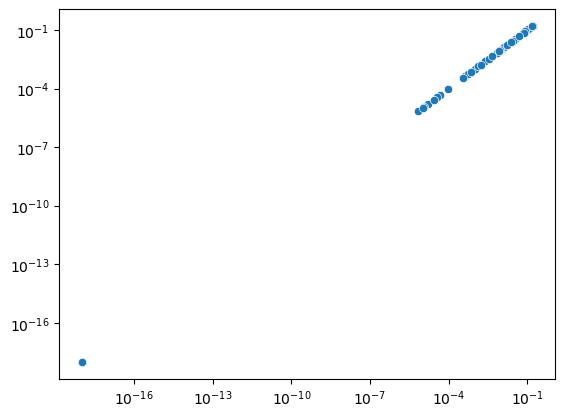

In [208]:
count_p = 7
x = Ri_noMicrocosm_ss_fit_avg[3].copy()
y = Ri_noMicrocosm_steadyState_fit_avg[count_p].copy()
thresh_ = 1e-18
x[x == 0] = thresh_
y[y == 0] = thresh_

id_ = np.where((x >= thresh_) & (y >= thresh_))
plt_ = sns.scatterplot(x=x[id_], y=y[id_])
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)

In [209]:
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
#                     fac_ = 1 / np.sum(df_speciesAbun_prev_tmp_[col_].values)
#                     df_speciesAbun_prev_tmp_[col_] = fac_ * \
#                         df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_noMicrocosm_steadyState_fit_avg[count_p].copy()
#             Ri_avg = Ri_noMicrocosm_fit_avg[p_tmp].copy()
#             Ri_avg /= np.sum(Ri_avg)
#             Ri_avg = Ri_clust_to_all(Ri_noMicrocosm_fit_avg[p_tmp].copy(), \
#                                      df_metabs_clusters, df_speciesMetab.shape[1]) 
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#             fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
#                          f'Ri steadyState, cluster_metabolites, ' + \
#                          f'umap_{distance_metric} dim{dim_project}, ' + \
#                          f'cluster_meanFunc_{metab_cluster_mean_func}, ' + \
#                          f'cluster method {clustering_method}, {microcosm_type}' + \
#                          f', randomSeed{random_seed}', \
#                          fontsize=10)
            fig.supylabel('predicted abundance (log scale)', fontsize=25)
            fig.supxlabel('observed abundance (log scale)', fontsize=25)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, df_speciesMetab_tmp,
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_steadyState' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_steadyState' + \
                                                     f'_with_p{p_tmp}_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}' + \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values
#                 fac_ = 1 / np.sum(df_tmp[col_].values)
#                 df_tmp[col_] = fac_ * \
#                     df_tmp[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun_mdl.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where((x > 0) & (y > 0))[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]
            
            if (pass_ == 2) & (p_tmp == 0.1):
                id_sp = np.where((x <= -6) & (y >= -5))[0]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(10**y, 10**x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]
            
            model_log = sm.OLS(y, x).fit()
            slope_log = model_log.params[0]
            slope_log_pval = model_log.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 8, 
                                   "passage" : [pass_] * 8, 
                                   "p" : [p_tmp] * 8, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "slope_log", \
                                                    "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, slope_log, \
                                               corr_val_pe[0], abs_mean_error, \
                                               std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, slope_log_pval, \
                                             corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


#             plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")
            plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope * 1)], c="green")
            plt_.plot([-8, 0], [(slope_log * (-8)), (slope_log * 0)], c="blue")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)} pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                            '{:.3e}'.format(slope_log_pval) + \
                     f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=15)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_steadyState' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'{date_}_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_steadyState' + \
                                                     f'_p{p_tmp}_{norm_status}' + \
                                                     f'_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}'+ \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)
            
# Plot growth ratios
            
            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#             fig.suptitle(f'predicted vs observed growth ratio passage {pass_}->{pass_ + 1}, \n' + 
#                          f'Ri steadyState, cluster_metabolites, ' + \
#                          f'umap_{distance_metric} dim{dim_project}, ' + \
#                          f'cluster_meanFunc_{metab_cluster_mean_func}, ' + \
#                          f'cluster method {clustering_method}, {microcosm_type}' + \
#                          f', randomSeed{random_seed}', \
#                          fontsize=10)
            fig.supylabel('predicted growth ratio (log scale)', fontsize=25)
            fig.supxlabel('observed growth ratio (log scale)', fontsize=25)
            if pass_ > 0:
                pass_tmp = pass_ - 1
                df_speciesAbun_ratio_tmp_1 = \
                    df_speciesAbun_ratio_mdl.copy().iloc[:, [pass_tmp, pass_tmp + 5, pass_tmp + 10]]
                b_ = range(3)
                x = \
                    np.array(df_speciesAbun_ratio_tmp_1)
                x_new = -1 * np.ones(x.shape[0])
                for row_ in range(x.shape[0]):
                    id_tmp = np.where(x[row_, :] > 0)[0]
                    if len(id_tmp) > 0:
                        x_new[row_] = 10**np.mean(np.log10(x[row_, id_tmp]))
                id_tmp = np.where(x_new > 0)[0]
                x = x_new[id_tmp]
    #                 x = 10**(np.mean(np.log10(x), axis=1)).flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, :].flatten()
                y = y[id_tmp]
            else:
                x = np.array(df_speciesAbun_mdl.iloc[:, [pass_, pass_ + 6, pass_ + 12]])
                x = 10**np.mean(np.log10(x), axis=1).flatten()
                x /= np.array(df_speciesAbun_inoc).flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, :].flatten()

            id_ = np.where((x > 0) & (y > 0))[0]
#                 id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

#                 if (pass_ == 2) & (p_tmp == 0.1):
#                     id_sp = np.where((x <= -6) & (y >= -5))[0]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-4, 2], [-4, 2], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(10**y, 10**x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]
            
            model_log = sm.OLS(y, x).fit()
            slope_log = model_log.params[0]
            slope_log_pval = model_log.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
#                 df_tmp = \
#                     pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
#                                        "passage" : [pass_] * 7, 
#                                        "p" : [p_tmp] * 7, 
#                                        "metric_type" : ["corr_pearson_log", 
#                                                         "corr_spearman", "slope", "corr_pearson_linear", \
#                                                         "abs_median_error", \
#                                                         "std_error", "FNR"], 
#                                        "metric" : [corr_val_pe_log[0], 
#                                                    corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, \
#                                                    std_error, \
#                                                    frac_zero],
#                                        "pval" : [corr_val_pe_log[1], 
#                                                  corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
#                 df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-4, 2], [np.log10(slope * (1e-4)), np.log10(slope * 1e2)], c="green")
            plt_.plot([-4, 2], [(slope_log * (-4)), (slope_log * 2)], c="blue")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)} pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f', slope_log = {np.round(slope_log, 3)} pvalue = ' + \
                            '{:.3e}'.format(slope_log_pval) + \
                     f'\n abs_median_error = {np.round(abs_mean_error, 3)}' + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=15)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_steadyState' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_growth_ratio_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_}->{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'{date_}_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_steadyState' + \
                                                     f'_p{p_tmp}_{norm_status}' + \
                                                     f'_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}'+ \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [210]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=30)
    fig.supxlabel('p', fontsize=30)
    fig.supylabel('correlation or slope', fontsize=30)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                f'_Ri_fit_steadyState' + \
                                                f'_cluster_metabolites_umap_{distance_metric}' + \
                                                f'_dim{dim_project}'+ \
                                                f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                f'_randomSeed{random_seed}', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'{date_}_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                             f'_Ri_fit_steadyState_cluster_metabolites' + \
                                             f'_umap_{distance_metric}' + \
                                             f'_dim{dim_project}' + \
                                             f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                             f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                             f'_randomSeed{random_seed}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

## Fit steady state Ri with clustered metabolite consuption matrix

In [118]:
# Fit using no-microcosm agar
passages_exclude = [[], [0], [0, 1], [0, 1, 2]]
num_passages = 6
p_tmp = 0
Ri_noMicrocosm_ss_fit_all = {}
Ri_noMicrocosm_ss_fit_avg = {}
Ri_noMicrocosm_ss_fit_joint = {}
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
num_metabs = df_speciesMetab_tmp.shape[1]
for count_p, pass_rm in enumerate(passages_exclude):
    print(f'count_p = {count_p}, pass_rmp = {pass_rm}')
#     pass_ex_list = []
#     for pass_ in pass_rm:
#         pass_ex_list += [pass_, pass_ + num_passages, pass_ + 2 * num_passages]
#     pass_keep = list(set(range(df_speciesAbun.shape[1])) - set(pass_ex_list))
    pass_keep = remove_passages(pass_rm)
    df_speciesAbun_tmp = df_speciesAbun_mdl.copy().iloc[:, pass_keep]
    
    Ri_noMicrocosm_ss_fit_all[count_p] = np.zeros((num_species, num_metabs))
    Ri_noMicrocosm_ss_fit_avg[count_p] = np.zeros((num_metabs))
    Ri_noMicrocosm_ss_fit_joint[count_p] = compute_Ri_ss(df_speciesMetab_tmp.copy(), \
                                                         df_speciesAbun_tmp.copy(), \
                                                         df_speciesAbun_tmp.copy(), \
                                                         0, \
                                                         range(num_species))
    count_species = 0
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_noMicrocosm_ss_fit_all[count_p][species_, :] = compute_Ri_ss(df_speciesMetab_tmp.copy(), \
                                                                     df_speciesAbun_tmp.copy(), \
                                                                     df_speciesAbun_tmp.copy(), \
                                                                     0, \
                                                                     id_species)
        if np.sum(Ri_noMicrocosm_ss_fit_all[count_p][species_, :]) <= 1.5:
            Ri_noMicrocosm_ss_fit_avg[count_p] += Ri_noMicrocosm_ss_fit_all[count_p][species_, :]
            count_species += 1
        
        
    Ri_noMicrocosm_ss_fit_avg[count_p] /= count_species
    
    
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                        f'_Ri_fit_ss_passages456' + \
                                        f'_cluster_metabolites_umap_{distance_metric}' + \
                                        f'_dim{dim_project}'+ \
                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                        f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                        f'_randomSeed{random_seed}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_Ri_fit_ss_passages456' + \
                                         f'_different_p_LeaveOneOutRi_cluster_metabolites' + \
                                         f'_umap_{distance_metric}' + \
                                         f'_dim{dim_project}'+ \
                                         f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                         f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                         f'_randomSeed{random_seed}.pickle'))

save_obj = {"Ri_noMicrocosm_ss_fit_all" : Ri_noMicrocosm_ss_fit_all, \
            "Ri_noMicrocosm_ss_fit_avg" : Ri_noMicrocosm_ss_fit_avg, \
            "Ri_noMicrocosm_ss_fit_joint" : Ri_noMicrocosm_ss_fit_joint}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_) 

count_p = 0, pass_rmp = []
count_p = 1, pass_rmp = [0]
count_p = 2, pass_rmp = [0, 1]
count_p = 3, pass_rmp = [0, 1, 2]


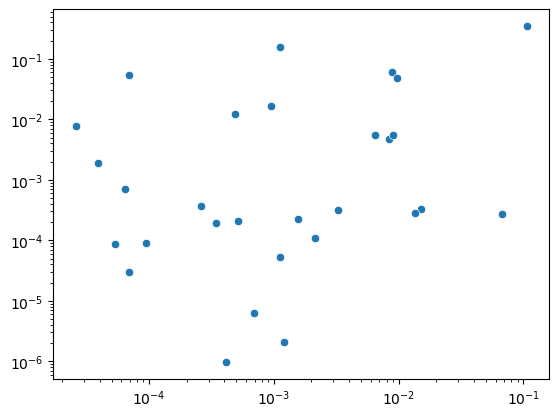

In [187]:
x = Ri_noMicrocosm_ss_fit_avg[3].copy()
y = Ri_noMicrocosm_fit_avg[0.4].copy()
thresh_ = 1e-18
x[x == 0] = thresh_
y[y == 0] = thresh_

id_ = np.where((x > thresh_) & (y > thresh_))
plt_ = sns.scatterplot(x=x[id_], y=y[id_])
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)

In [38]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                        f'_Ri_fit_ss_passages456' + \
                                        f'_cluster_metabolites_umap_{distance_metric}' + \
                                        f'_dim{dim_project}'+ \
                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                        f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                        f'_randomSeed{random_seed}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_Ri_fit_ss_passages456' + \
                                         f'_different_p_LeaveOneOutRi_cluster_metabolites' + \
                                         f'_umap_{distance_metric}' + \
                                         f'_dim{dim_project}'+ \
                                         f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                         f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                         f'_randomSeed{random_seed}.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_noMicrocosm_ss_fit_all = save_obj["Ri_noMicrocosm_ss_fit_all"]
Ri_noMicrocosm_ss_fit_avg = save_obj["Ri_noMicrocosm_ss_fit_avg"]
Ri_noMicrocosm_ss_fit_joint = save_obj["Ri_noMicrocosm_ss_fit_joint"]

In [119]:
lhs_, rhs_, samples_rm, species_rm = compute_Ri_ss_goodness_of_fit(df_speciesMetab_tmp, \
                                                                   df_speciesAbun_tmp, df_speciesAbun_tmp, \
                                                                   range(num_species), \
                                                                   Ri_noMicrocosm_ss_fit_avg[3])
# lhs_, rhs_, samples_rm, species_rm = compute_Ri_ss_goodness_of_fit(df_speciesMetab_tmp, \
#                                                                    df_speciesAbun_tmp, df_speciesAbun_tmp, \
#                                                                    range(num_species), \
#                                                                    Ri_noMicrocosm_ss_fit_joint[3])
# lhs_, rhs_, samples_rm, species_rm = compute_Ri_ss_goodness_of_fit(df_speciesMetab_tmp, \
#                                                                    df_speciesAbun_tmp, df_speciesAbun_tmp, \
#                                                                    range(num_species), \
#                                                                    Ri_noMicrocosm_fit_avg[0.2])

In [120]:
df_speciesAbun_tmp_ss = df_speciesAbun_tmp.copy()

0.07695579063847094
PearsonRResult(statistic=0.9780757534903769, pvalue=0.0)


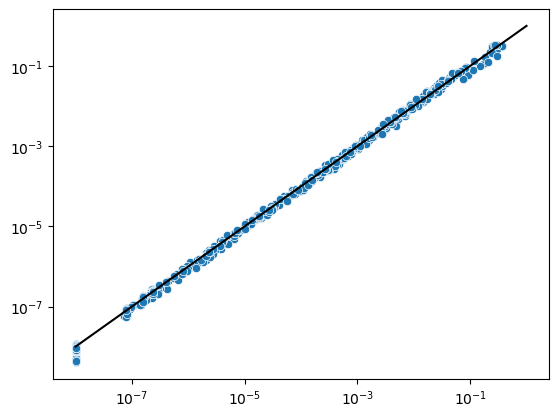

In [121]:
id_ = range(len(lhs_))
plt_ = sns.scatterplot(x=lhs_[id_], y=rhs_[id_])
print(np.sqrt(np.mean(np.power(np.log10(lhs_) - np.log10(rhs_), 2))))
plt_.plot([1e-8, 1e0], [1e-8, 1e0], c="black")
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)
print(scipy.stats.pearsonr(lhs_[id_], rhs_[id_]))

# Simulated for updating Ri fit using steady state

In [143]:
# def neighborhood_fn(current_solution, norm_temp):
#     neighbor = np.zeros_like(current_solution)
#     for id_, coord_ in enumerate(current_solution):
#         neighbor[id_] = np.power(10, np.random.normal(np.log10(coord_), sqrt(norm_temp), 1))
    
#     return neighbor
pass_ = 0
Ri_avg = Ri_noMicrocosm_ss_fit_avg[3].copy()

df_speciesAbun_prev_tmp_ = df_speciesAbun_prev_mdl.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
df_speciesAbun_next_tmp_ = df_speciesAbun_next_mdl.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
df_speciesAbun_ratio_new = df_speciesAbun_ratio_mdl.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

p_tmp = 0.1
sample_names_split, mat_cons_abun_split_list_tmp = \
    iterate_growth_ratio(df_speciesMetab_tmp.copy(), df_speciesAbun_prev_tmp_.copy(), \
                         df_speciesAbun_next_tmp_.copy(), p_=p_tmp)

def objective_fn(Ri, pass_=0):
    id_species = range(df_speciesAbun_prev_tmp_.shape[0])
    count_ = 0
    error_ = 0
#     df_growth_ratio = pd.DataFrame()
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        error_ += np.sqrt(np.mean(np.power((vals_tmp - tmp.flatten()), 2)))
        
#         df_growth_ratio[sample_] = vals_tmp
        
        
    error_ /= len(sample_names_split)
    return error_

def objective_fn_new(Ri_avg, pass_=0):
    num_iter = 10
    growth_rate_all = np.zeros((num_iter, num_species))
    growth_rate_all = {}
    growth_rate_all[0] = pd.DataFrame()
    df_speciesAbun_prev_tmp_ = df_speciesAbun_prev_mdl.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
    df_speciesAbun_next_tmp_ = df_speciesAbun_next_mdl.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
    df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio_mdl.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
    ratio_means_ = {}
    for col_ in df_speciesAbun_prev_tmp_.columns.values:
        growth_rate_all[0][col_] = np.ones((num_species))
#         growth_rate_all[0][col_] = df_speciesAbun_ratio_tmp_[col_].values
        ratio_means_[col_] = np.mean(np.log10(df_speciesAbun_ratio_tmp_[col_].values))
#     p_tmp = 0.2
    for iter_ in range(num_iter):
        if iter_ == 0:
            iter_id = iter_
        else:
            iter_id = iter_ - 1
        if iter_ <= -1:
            df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                          df_speciesAbun_next_tmp_.copy(), \
                                                          p_tmp, Ri_avg.copy(), \
                                                          growth_rate_all[iter_id].copy(), ratio_means_.copy())
        else:
#             df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
#                                                           df_speciesAbun_next_tmp_.copy(), \
#                                                           p_tmp, Ri_avg.copy(), \
#                                                           growth_rate_all[iter_id].copy(), ratio_means_.copy(), 
#                                                           norm_=False)
            df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                          df_speciesAbun_next_tmp_.copy(), \
                                                          p_tmp, Ri_avg.copy(), \
                                                          growth_rate_all[iter_id].copy(), \
                                                          ratio_means_.copy(), \
                                                          df_speciesMetab_tmp.copy(),
                                                          norm_=False)
        growth_rate_all[iter_] = df_growth_rate.copy()
        
    x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, :].flatten())
    y=np.log10(np.array(growth_rate_all[num_iter - 1])[:, :].flatten())
    # y=np.random.permutation(x)
    y[y <= -5] = -5
    id_ = np.where((y > -100))[0]
    x = x[id_]
    y = y[id_]

#     corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
#     corr_val_pe_log = scipy.stats.pearsonr(x, y)
#     corr_val_sp = scipy.stats.spearmanr(x, y)

#     model = sm.OLS(y, x).fit()
#     slope = model.params[0]
#     slope_pval = model.pvalues[0]
    
    error_1 = np.median(np.abs(x - y))
    
    lhs_, rhs_, samples_rm, species_rm = compute_Ri_ss_goodness_of_fit(df_speciesMetab_tmp, \
                                                                       df_speciesAbun_tmp_ss, \
                                                                       df_speciesAbun_tmp_ss, \
                                                                       range(num_species), \
                                                                       Ri_avg)
    error_2 = np.sqrt(np.mean(np.power(np.log10(lhs_) - np.log10(rhs_), 2)))
    
    return error_1
    

# Simulated Annealing function
def simulated_annealing(initial_solution, neighborhood_fn, objective_fn, temperature, cooling_rate, \
                        stopping_temperature):
    # Initialize the current solution and best solution
    current_solution = initial_solution.copy()
    best_solution = initial_solution.copy()
    max_temp = temperature

    # Start the search until the stopping temperature is reached
    iter_ = 0
    while temperature > stopping_temperature:
        # Generate a random neighbor
        neighbor = random.choice(neighborhood_fn(current_solution, temperature / max_temp))
#         neighbor = neighborhood_fn(current_solution, temperature / max_temp)

        # Calculate the objective function difference between the current solution and the neighbor
        delta = objective_fn_new(neighbor) - objective_fn_new(current_solution)
#         print(f'temperature = {temperature}, delta = {delta}')
        if iter_ % 100 == 0:
            print(f"iteration # = {iter_}, temperature = {temperature}, delta = {delta}")

        # If the neighbor is better, move to it
        if delta < 0:
            current_solution = neighbor[:]
        # If the neighbor is worse, move to it with a probability based on the temperature
        else:
            probability = math.exp(-delta / temperature)
            if random.random() < probability:
                current_solution = neighbor[:]

        # Update the best solution if necessary
        if objective_fn_new(current_solution) < objective_fn_new(best_solution):
            best_solution = current_solution[:]

        # Cool the temperature
        temperature *= cooling_rate
        
        iter_ += 1

    # Return the best solution found
    return best_solution

# Define the objective function to calculate the value of a solution
def value_fn(solution):
    return sum(solution)

# Define the neighborhood function to change one element in the solution
def neighborhood_fn(solution, norm_temp):
    neighborhoods = []
    for i, sol_ in enumerate(solution):
        neighbor = solution.copy()
#         neighbor[i] = random.randint(0, 9)
#         neighbor[i] = np.exp(np.random.normal(np.log(sol_), np.sqrt(norm_temp), 1))
#         if neighbor[i] <= 1e-4:
        select_ = random.choice(np.array([0, 1]))
        if select_ == 0:
            lower_lim = np.log10(sol_) - (np.log10(sol_) + 12) * norm_temp
            upper_lim = np.log10(sol_) + (0 - np.log10(sol_)) * norm_temp
            neighbor[i] = np.power(10, np.random.uniform(lower_lim, upper_lim, 1))[0]
        #         if neighbor[i] >= 1:
        #             neighbor[i] = 0.99
            neighbor /= np.sum(neighbor)
        else:
            j = random.choice(np.array(list(set(list(np.arange(len(neighbor)))) - set([i])), \
                                       dtype=np.int64))
            val_ = neighbor[i]
            neighbor[i] = neighbor[j]
            neighbor[j] = val_
        neighborhoods.append(neighbor)
    return neighborhoods

# Set the initial solution and parameters for the Simulated Annealing algorithm
initial_solution = Ri_noMicrocosm_ss_fit_avg[3].copy()
# initial_solution = Ri_noMicrocosm_fit_avg[0.3]
zero_thresh = 1e-15
initial_solution[initial_solution == 0] = zero_thresh
temperature = 1000
cooling_rate = 0.98
stopping_temperature = 1e-8

# Run the Simulated Annealing algorithm to find the best solution
best_solution = simulated_annealing(initial_solution, neighborhood_fn, objective_fn, temperature, \
                                    cooling_rate, stopping_temperature)

# Print the best solution and its value
print("Best solution found:", best_solution)
print("Value of best solution:", objective_fn_new(best_solution))


iteration # = 0, temperature = 1000, delta = -0.051613575332564166
iteration # = 100, temperature = 132.61955589475298, delta = -1.0755167867415594e-09
iteration # = 200, temperature = 17.587946605721505, delta = 0.008300171950869517
iteration # = 300, temperature = 2.3325056679514122, delta = 0.018766826600636444
iteration # = 400, temperature = 0.3093358658057103, delta = -0.06989521410548094
iteration # = 500, temperature = 0.0410239851454722, delta = -1.838847756285844e-07
iteration # = 600, temperature = 0.005440582691025469, delta = 1.7386092565629951e-13
iteration # = 700, temperature = 0.0007215276602924775, delta = 2.220446049250313e-16
iteration # = 800, temperature = 9.568867787376848e-05, delta = 3.465221443121891e-10
iteration # = 900, temperature = 1.2690189963775249e-05, delta = 0.1060907958624202
iteration # = 1000, temperature = 1.682967357215924e-06, delta = -7.482903185973555e-14
iteration # = 1100, temperature = 2.2319438349934193e-07, delta = 0.08396299092418424
it

In [273]:
set([9])

{9}

In [148]:
p_tmp = 0.1
objective_fn_new(best_solution)

0.6297073258136394

In [149]:
lhs_, rhs_, samples_rm, species_rm = compute_Ri_ss_goodness_of_fit(df_speciesMetab_tmp, \
                                                                   df_speciesAbun_tmp_ss, \
                                                                   df_speciesAbun_tmp_ss, \
                                                                   range(num_species), \
                                                                   best_solution)
error_2 = np.sqrt(np.mean(np.power(np.log10(lhs_) - np.log10(rhs_), 2)))
print(error_2)

0.21887511826571354


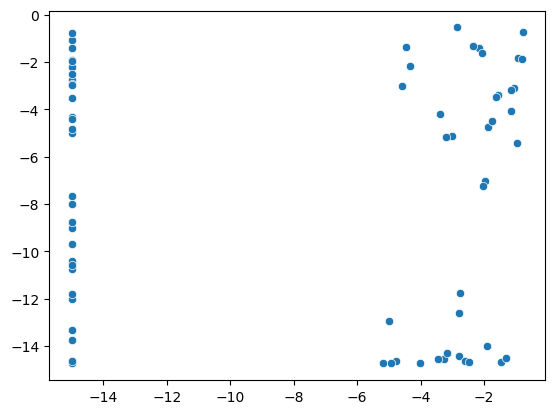

In [150]:
x = Ri_noMicrocosm_ss_fit_avg[3].copy()
# x = Ri_noMicrocosm_fit_avg[0.3].copy()
x[x == 0] = 1e-15
plt_ = sns.scatterplot(x=np.log10(x), y=np.log10(best_solution))

In [327]:
metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0]]
id_order = np.argsort(-best_solution)
metab_names[id_order[range(10)]]
print(best_solution[id_order])

[3.31204576e-01 1.84066735e-01 1.49450642e-01 9.52323870e-02
 7.31567442e-02 3.32366842e-02 1.98723660e-02 1.50419345e-02
 1.44235392e-02 1.17080525e-02 9.94000942e-03 9.04096314e-03
 8.33557271e-03 8.03528069e-03 6.52484215e-03 6.23596982e-03
 4.60954263e-03 4.04001331e-03 2.19059829e-03 1.80187688e-03
 1.71258818e-03 1.43167236e-03 1.16523240e-03 1.04466924e-03
 8.81583646e-04 8.05801444e-04 6.13397531e-04 5.82883124e-04
 5.40781694e-04 5.17095122e-04 4.80629920e-04 4.80455844e-04
 3.29204938e-04 2.78968301e-04 1.98065945e-04 1.95431771e-04
 1.83522744e-04 1.46441186e-04 9.60073084e-05 8.79566583e-05
 3.64666352e-05 2.75807809e-05 9.37414921e-06 3.02239798e-06
 1.69181786e-06 6.73454107e-07 3.88275870e-07 7.69140455e-08
 3.37961189e-09 1.74882906e-09 5.48092080e-10 3.43602311e-10
 7.11223486e-11 4.56350318e-11 1.91442380e-11 5.36372711e-12
 4.18658810e-12 2.70875780e-12 2.04359095e-12 1.19112232e-12
 1.91486454e-13 5.43800008e-14 2.59878051e-14 1.31079894e-14
 3.93288918e-15 3.327295

In [328]:
df_metabs_clusters.iloc[id_order[range(10)], :]

,cluster_labels,cluster_counts,cluster_metab_IDs,cluser_metab_names
49,49,1,[108],"[IS_TRYPTOPHAN-2,4,5,6,7-D5]"
68,68,1,[227],[MALIC ACID]
29,29,1,[9],[BETA-ALANINE]
65,65,1,[207],[GLYCEROL 2-PHOSPHATE]
55,55,1,[147],[2-AMINOBENZOIC ACID]
39,39,1,[55],[IS_PROGESTERONE-D9]
35,35,1,[45],[IS_METHIONINE-METHYL-D3]
60,60,1,[193],"[CYTIDINE 2',3'-CYCLIC MONOPHOSPHATE]"
56,56,1,[152],[3'-CMP]
38,38,1,[50],[IS_N-BENZOYL-D5-GLYCINE]


In [131]:
id_order = np.argsort(-Ri_noMicrocosm_ss_fit_avg[3])
df_metabs_clusters["Ri"] = Ri_noMicrocosm_ss_fit_avg[3]
df_metabs_clusters.iloc[id_order[range(20)], :]
# Ri_noMicrocosm_ss_fit_avg[3][id_order[range(11)]]

,cluster_labels,cluster_counts,cluster_metab_IDs,cluser_metab_names,Ri
18,18,72,"[6, 10, 16, 18, 25, 27, 30, 33, 36, 40, 41, 46...","[VALINE, 1,3-DIAMINOPROPANE, 5-METHYLCYTOSINE,...",0.163702
55,55,1,[166],[5'-METHYLTHIOADENOSINE],0.154726
4,4,11,"[29, 34, 43, 44, 45, 48, 116, 189, 244, 268, 275]","[PHOSPHOCHOLINE, TRYPTOPHAN ETHYL ESTER, IS_CA...",0.114647
16,16,2,"[66, 81]","[CITRIC ACID, PYRUVIC ACID]",0.109479
29,29,1,[169],[ADENOSINE],0.085197
56,56,1,[217],[HYPOXANTHINE],0.072184
19,19,3,"[1, 155, 253]","[N-METHYL-ASPARTIC ACID, 4-AMINOBUTANOIC ACID,...",0.070172
67,67,1,[288],[URACIL],0.048510
0,0,33,"[2, 7, 11, 13, 17, 21, 22, 32, 35, 119, 120, 1...","[2-AMINO-2-METHYLPROPANOIC ACID, SUCROSE, 3-HY...",0.033586
34,34,1,[270],[RIBOFLAVIN],0.028150


In [129]:
Ri_noMicrocosm_ss_fit_avg[3][id_order[range(9)]]

array([0.1637022 , 0.15472603, 0.11464699, 0.10947876, 0.08519652,
       0.07218445, 0.07017245, 0.04850998, 0.03358634])

In [340]:
id_order = np.argsort(-Ri_noMicrocosm_fit_avg[0.4])
df_metabs_clusters.iloc[id_order[range(20)], 3].values

array([list(['FRUCTOSE 6-PHOSPHATE', '5-AMINOPENTANOIC ACID', 'BENZALDEHYDE', 'MALEAMIC ACID', '3-DEHYDROSHIKIMIC ACID', 'METHYL BETA-GALACTOSIDE', 'ACETYLCHOLINE', 'DEOXYURIDINE']),
       list(['CINNAMALDEHYDE']),
       list(['GALACTOSAMINE', 'PIPECOLIC ACID', 'CROTONIC ACID', '3-FUROIC ACID', '2-METHYLBUTYRYLGLYCINE', '3-METHOXYTYRAMINE', "CYTIDINE 5'-DIPHOSPHOCHOLINE", '2,6-DIAMINOHEPTANEDIOIC ACID', 'N-ACETYLTRYPTOPHAN', 'PHENYLACETYLGLYCINE', 'PYRIDOXINE', 'SN-GLYCERO-3-PHOSPHOCHOLINE']),
       list(["3'-CMP"]), list(['2-(4-HYDROXYPHENYL)PROPIONIC ACID']),
       list(['GLYCEROL 2-PHOSPHATE']), list(['PUTRESCINE']),
       list(['2-HYDROXY-2-METHYLBUTYRIC ACID', '4-GUANIDINOBUTANOIC ACID', 'HOMOSERINE', 'CITRULLINE', 'CYSTATHIONINE', 'ORNITHINE', 'PTERIN', 'TRYPTOPHAN']),
       list(['LACTIC ACID']),
       list(['SARCOSINE', '8-HYDROXYQUINOLINE', 'THIOACETIC ACID', 'IS_LEUCINE-5,5,5-D3', 'IS_N-BENZOYL-D5-GLYCINE', 'IS_4-CHLORO-PHENYLALANINE', 'IS_4-BROMO-PHENYLALANINE', 'IS_D

In [133]:
num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, \
             0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]

df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
for norm_status in norm_status_vec:
    for pass_ in [0]:
        df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

        df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})
    
        df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})

        for count_p, p_tmp in enumerate(p_vec_new):
            if count_p <= 200:
                growth_rate_all = {}
                growth_rate_all[0] = pd.DataFrame()
                Ri_avg = Ri_noMicrocosm_ss_fit_avg[3].copy()
#                 Ri_avg = best_solution.copy()

                fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
                fig.suptitle(f'predicted vs observed growth ratios passage {pass_ + 1}->{pass_ + 2}, \n' + 
                             f'Ri fit with p = {p_tmp}, no-Microcosm ' + \
                             f'cluster_metabolites, umap{distance_metric}, ' + \
                             f'cluster meanFunc {metab_cluster_mean_func}', \
                             fontsize=15)
                fig.supxlabel('predicted growth ratio (log scale)', fontsize=15)
                fig.supylabel('observed growth ratio (log scale)', fontsize=15)
                plt_rows = 2
                plt_cols = 4

                ratio_means_ = {}
                for col_ in df_speciesAbun_prev_tmp_.columns.values:
                    growth_rate_all[0][col_] = np.ones((num_species))
                    x = df_speciesAbun_ratio_tmp_[col_].values
                    ratio_means_[col_] = np.mean(np.log10(x[x != -1]))

                for iter_ in range(num_iter):
                    if iter_ == 0:
                        iter_id = iter_
                    else:
                        iter_id = iter_ - 1
                    if norm_status == "norm":    
                        iter_thresh = -1
                    else:
                        iter_thresh = -1

                    if norm_status == "norm":
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy())
                    else:
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy(), \
                                                                      df_speciesMetab_tmp.copy(),
                                                                      norm_=False)

                    growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                        f'_Ri_fit_ss_passages456' + \
                                                        f'_cluster_metabolites_umap_{distance_metric}' + \
                                                        f'_dim{dim_project}'+ \
                                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                        f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                        f'_randomSeed{random_seed}_SA', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, \
                                                        'predicted_growth_ratios', \
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                    os.makedirs(save_dir)
                file_save = os.path.abspath(os.path.join(save_dir, 
                                                         f'predicted_growth_ratios_with_p{p_tmp}' + \
                                                         f'_cluster_metabolites_umap_{distance_metric}' + \
                                                         f'_cluster_meanFunc_{metab_cluster_mean_func}.pickle'))


                with open(file_save, "wb") as file_:
                    pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)

                b_ = range(3)
                x = np.array(df_speciesAbun_ratio_tmp_.copy())[:, b_].flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, b_].flatten()
                id_ = np.where(x > 0)[0]
                id_zero = np.where((x <= thresh_zero))[0]
                x = np.log10(x[id_])
                y = np.log10(y[id_])
                # y=np.random.permutation(x)
                y[y <= -5] = -5
                id_ = np.where((y > -100))[0]
                x = x[id_]
                y = y[id_]
                
#                 rolling mean
                id_order = np.argsort(x)
                x_order = (x.copy())[id_order]
                y_order = (y.copy())[id_order]
                df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
                window_size = 20
                rolling_avg = df_tmp['y'].rolling(window_size).mean().values
                id_not_nan = np.where(~np.isnan(rolling_avg))[0]
                id_nan = np.where(np.isnan(rolling_avg))[0]

                plt_ = sns.scatterplot(x=x, \
                                       y=y, ax=axes)

                plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                                   ax=axes)
                plt_.plot([-4, 2], [-4, 2], c="red")
#                 plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

                corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
                corr_val_pe_log = scipy.stats.pearsonr(x, y)
                corr_val_sp = scipy.stats.spearmanr(x, y)
                corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                           (y - np.mean(y)) / np.std(y))
                mean_error = np.abs(np.median(y - x))
                abs_mean_error = np.median(np.abs(y - x))
                cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
                std_error = np.std(np.abs(y - x))

                id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

                frac_zero = len(id_notzero_zero) / len(x)

                model = sm.OLS(y, x).fit()
                slope = model.params[0]
                slope_pval = model.pvalues[0]

                df_tmp = \
                    pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                       "passage" : [pass_] * 7, 
                                       "p" : [p_tmp] * 7, 
                                       "metric_type" : ["corr_pearson_log", 
                                                        "corr_spearman", "slope", "corr_pearson_linear", \
                                                        "abs_median_error", \
                                                        "std_error", "FNR"], 
                                       "metric" : [corr_val_pe_log[0], 
                                                   corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, std_error, \
                                                   frac_zero],
                                       "pval" : [corr_val_pe_log[1], 
                                                 corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
                df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


                plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

                title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe[1]) + \
                         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe_log[1]) + \
                         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_sp[1]) + \
                         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                                '{:.3e}'.format(slope_pval) + \
                         f'\n fit with p = {p_tmp}'

                axes.set_title(title_, size=10)

                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                        f'_Ri_fit_ss_passages456' + \
                                                        f'_cluster_metabolites_umap_{distance_metric}' + \
                                                        f'_dim{dim_project}'+ \
                                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                        f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                        f'_randomSeed{random_seed}_SA', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, 
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                   os.makedirs(save_dir)

                save_file = os.path.abspath(os.path.join(save_dir, 
                                                         f'{date_}_predicted_vs_observed_growth_ratios_' + \
                                                         f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme_' + \
                                                         f'_Ri_fit_with_p{p_tmp}_{norm_status}' + \
                                                         f'_cluster_metabolites_umap_{distance_metric}' + \
                                                         f'_cluster_meanFunc_{metab_cluster_mean_func}.png'))
                fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
                plt.close(fig.figure)

In [135]:
for pass_ in [0]:    
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed growth ratios \n' + \
                 f' passage {pass_ + 1}->{pass_ + 2}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]

    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                   hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                f'_Ri_fit_ss_passages456' + \
                                                f'_cluster_metabolites_umap_{distance_metric}' + \
                                                f'_dim{dim_project}'+ \
                                                f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                f'_randomSeed{random_seed}_SA', \
                                                'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}to{pass_ + 2}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'{date_}_corr_slope_predicted_vs_observed_growth_ratios_' + \
                                             f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
                                             f'_cluster_metabolites_umap_{distance_metric}' + \
                                             f'_cluster_meanFunc_{metab_cluster_mean_func}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

In [136]:
fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
fig.suptitle(f'RHS vs LHS for Ri fitted at steady state, passages 4, 5 and 6', \
             fontsize=20)
fig.supylabel('RHS (log scale)', fontsize=30)
fig.supxlabel('LHS (log scale)', fontsize=30)

x = np.log10(lhs_)
y = np.log10(rhs_)

plt_ = sns.scatterplot(x=x, \
                       y=y, ax=axes)

plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                   ax=axes)
plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
corr_val_pe_log = scipy.stats.pearsonr(x, y)
corr_val_sp = scipy.stats.spearmanr(x, y)
corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                           (y - np.mean(y)) / np.std(y))

model = sm.OLS(rhs_, lhs_).fit()
slope = model.params[0]
slope_pval = model.pvalues[0]
rms_ = np.sqrt(np.mean(np.power(np.log10(lhs_) - np.log10(rhs_), 2)))


plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope)], c="green")

title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe[1]) + \
         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe_log[1]) + \
         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_sp[1]) + \
         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                '{:.3e}'.format(slope_pval) + f', RMSE = {np.round(rms_, 3)}'

axes.set_title(title_, size=20)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                        f'_Ri_fit_ss_passages456' + \
                                        f'_cluster_metabolites_umap_{distance_metric}' + \
                                        f'_dim{dim_project}'+ \
                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                        f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                        f'_randomSeed{random_seed}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)

save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_RHS_vs_LHS_Ri_fit_ss_passages456.png'))
fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(fig.figure)

In [137]:
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.325, 0.35, \
             0.375, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
#                     fac_ = 1 / np.sum(df_speciesAbun_prev_tmp_[col_].values)
#                     df_speciesAbun_prev_tmp_[col_] = fac_ * \
#                         df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_noMicrocosm_ss_fit_avg[3].copy()
#             Ri_avg = best_solution.copy()
#             Ri_avg /= np.sum(Ri_avg)
#             Ri_avg = Ri_clust_to_all(Ri_noMicrocosm_fit_avg[p_tmp].copy(), \
#                                      df_metabs_clusters, df_speciesMetab.shape[1]) 
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri ss passages456, cluster_metabolites, ' + \
                         f'umap_{distance_metric} dim{dim_project}, ' + \
                         f'cluster_meanFunc_{metab_cluster_mean_func}, ' + \
                         f'cluster method {clustering_method}, {microcosm_type}' + \
                         f', randomSeed{random_seed}', \
                         fontsize=10)
            fig.supylabel('predicted abundance (log scale)', fontsize=25)
            fig.supxlabel('observed abundance (log scale)', fontsize=25)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, df_speciesMetab_tmp,
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_ss_passages456' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}_SA', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_ss_passages456' + \
                                                     f'_with_p{p_tmp}_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}' + \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values
#                 fac_ = 1 / np.sum(df_tmp[col_].values)
#                 df_tmp[col_] = fac_ * \
#                     df_tmp[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun_mdl.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where((x > 0) & (y > 0))[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]
            
            if (pass_ == 2) & (p_tmp == 0.1):
                id_sp = np.where((x <= -6) & (y >= -5))[0]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, \
                                               std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=15)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_ss_passages456' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}_SA', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'{date_}_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_ss_passages456' + \
                                                     f'_p{p_tmp}_{norm_status}' + \
                                                     f'_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}'+ \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


## Blindly predict abundance

In [139]:
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.325, 0.35, \
             0.375, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
#                     fac_ = 1 / np.sum(df_speciesAbun_prev_tmp_[col_].values)
#                     df_speciesAbun_prev_tmp_[col_] = fac_ * \
#                         df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_noMicrocosm_ss_fit_avg[3].copy()
#             Ri_avg = Ri_noMicrocosm_fit_avg[p_tmp].copy()
#             Ri_avg /= np.sum(Ri_avg)
#             Ri_avg = Ri_clust_to_all(Ri_noMicrocosm_fit_avg[p_tmp].copy(), \
#                                      df_metabs_clusters, df_speciesMetab.shape[1]) 
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri ss passages456, cluster_metabolites, ' + \
                         f'umap_{distance_metric} dim{dim_project}, ' + \
                         f'cluster_meanFunc_{metab_cluster_mean_func}, ' + \
                         f'cluster method {clustering_method}, {microcosm_type}' + \
                         f', randomSeed{random_seed}', \
                         fontsize=10)
            fig.supylabel('predicted abundance (log scale)', fontsize=25)
            fig.supxlabel('observed abundance (log scale)', fontsize=25)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, df_speciesMetab_tmp,
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_ss_passages456' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_ss_passages456' + \
                                                     f'_with_p{p_tmp}_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}' + \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values
#                 fac_ = 1 / np.sum(df_tmp[col_].values)
#                 df_tmp[col_] = fac_ * \
#                     df_tmp[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun_mdl.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where((x > 0) & (y > 0))[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]
            
            if (pass_ == 2) & (p_tmp == 0.1):
                id_sp = np.where((x <= -6) & (y >= -5))[0]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(10**y, 10**x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, \
                                               std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


#             plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")
            plt_.plot([-8, 0], [np.log10(slope * (1e-8)), np.log10(slope * 1)], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=15)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_ss_passages456' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'{date_}_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_ss_passages456' + \
                                                     f'_p{p_tmp}_{norm_status}' + \
                                                     f'_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}'+ \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)
            
# Plot growth ratios
            
            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed growth ratio passage {pass_}->{pass_ + 1}, \n' + 
                         f'Ri ss passages456, cluster_metabolites, ' + \
                         f'umap_{distance_metric} dim{dim_project}, ' + \
                         f'cluster_meanFunc_{metab_cluster_mean_func}, ' + \
                         f'cluster method {clustering_method}, {microcosm_type}' + \
                         f', randomSeed{random_seed}', \
                         fontsize=10)
            fig.supylabel('predicted growth ratio (log scale)', fontsize=25)
            fig.supxlabel('observed growth ratio (log scale)', fontsize=25)
            if pass_ > 0:
                pass_tmp = pass_ - 1
                df_speciesAbun_ratio_tmp_1 = \
                    df_speciesAbun_ratio_mdl.copy().iloc[:, [pass_tmp, pass_tmp + 5, pass_tmp + 10]]
                b_ = range(3)
                x = \
                    np.array(df_speciesAbun_ratio_tmp_1)
                x_new = -1 * np.ones(x.shape[0])
                for row_ in range(x.shape[0]):
                    id_tmp = np.where(x[row_, :] > 0)[0]
                    if len(id_tmp) > 0:
                        x_new[row_] = 10**np.mean(np.log10(x[row_, id_tmp]))
                id_tmp = np.where(x_new > 0)[0]
                x = x_new[id_tmp]
    #                 x = 10**(np.mean(np.log10(x), axis=1)).flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, :].flatten()
                y = y[id_tmp]
            else:
                x = np.array(df_speciesAbun_mdl.iloc[:, [pass_, pass_ + 6, pass_ + 12]])
                x = 10**np.mean(np.log10(x), axis=1).flatten()
                x /= np.array(df_speciesAbun_inoc).flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, :].flatten()

            id_ = np.where((x > 0) & (y > 0))[0]
#                 id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

#                 if (pass_ == 2) & (p_tmp == 0.1):
#                     id_sp = np.where((x <= -6) & (y >= -5))[0]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-4, 2], [-4, 2], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(10**y, 10**x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
#                 df_tmp = \
#                     pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
#                                        "passage" : [pass_] * 7, 
#                                        "p" : [p_tmp] * 7, 
#                                        "metric_type" : ["corr_pearson_log", 
#                                                         "corr_spearman", "slope", "corr_pearson_linear", \
#                                                         "abs_median_error", \
#                                                         "std_error", "FNR"], 
#                                        "metric" : [corr_val_pe_log[0], 
#                                                    corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, \
#                                                    std_error, \
#                                                    frac_zero],
#                                        "pval" : [corr_val_pe_log[1], 
#                                                  corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
#                 df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-4, 2], [np.log10(slope * (1e-4)), np.log10(slope * 1e2)], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=15)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_ss_passages456' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_growth_ratio_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_}->{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'{date_}_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_ss_passages456' + \
                                                     f'_p{p_tmp}_{norm_status}' + \
                                                     f'_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}'+ \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [359]:
pass_ = 0
x = np.array(df_speciesAbun_mdl.iloc[:, [pass_, pass_ + 6, pass_ + 12]])
x = 10**np.mean(np.log10(x), axis=1).flatten()
x / np.array(df_speciesAbun_inoc).flatten()

array([4.03566466e+00, 2.68108240e+01, 7.45193521e-01, 1.50058132e-02,
       1.65987111e+00, 5.74164287e-01, 5.00868002e+00, 1.45795846e+00,
       8.26479994e-01, 2.88950761e-02, 1.47362660e-01, 4.60870274e-01,
       3.42494909e-01, 1.81395080e+00, 6.92525876e-02, 1.08838551e+00,
       2.57474439e+00, 2.47000323e-03, 7.25187998e-01, 1.94223398e+00,
       9.79837851e-01, 9.05802906e-01, 2.32865698e+00, 5.87853996e-01,
       2.12638309e-01, 8.19183711e-03, 7.89673478e-03, 4.29270554e-03,
       2.74639421e-04, 1.14076356e-01, 3.52048678e-03, 6.47048564e-01,
       2.82172010e-01, 1.73490596e-01, 2.07317086e-02, 1.10571521e-02,
       4.30013043e-01, 1.01058039e-04, 1.67812080e-01, 7.12344475e-02,
       5.73255895e-02, 1.49311374e-02, 1.35492897e-01, 5.34345524e-05,
       1.00096539e+00, 5.64947207e-01, 2.93800445e-02, 2.20770851e-03,
       7.34784124e+00, 4.89402613e+00, 5.68047724e-02, 5.79732361e-01,
       3.80356858e-01, 2.23134465e-01, 8.22727745e-02, 7.73850665e-01,
      

In [140]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=30)
    fig.supxlabel('p', fontsize=30)
    fig.supylabel('correlation or slope', fontsize=30)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                f'_Ri_fit_ss_passages456_cluster_metabolites' + \
                                                f'_umap_{distance_metric}'+ \
                                                f'_dim{dim_project}' + \
                                                f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                f'_randomSeed{random_seed}', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'{date_}_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                             f'_Ri_fit_ss_passages456_cluster_metabolites' + \
                                             f'_umap_{distance_metric}' + \
                                             f'_dim{dim_project}' + \
                                             f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                             f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                             f'_randomSeed{random_seed}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

In [ ]:
with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)

In [ ]:
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.325, 0.35, \
             0.375, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
#             if pass_ == 0:
#                 df_speciesAbun_prev_tmp_ = \
#                     df_speciesAbun_inoc.copy().iloc[:, :]
#             else:
#                 df_tmp = growth_rate_all[num_iter - 1].copy()
# #                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
#                 for col_ in df_tmp.columns.values:
#                     df_speciesAbun_prev_tmp_[col_] = \
#                         df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
# #                     fac_ = 1 / np.sum(df_speciesAbun_prev_tmp_[col_].values)
# #                     df_speciesAbun_prev_tmp_[col_] = fac_ * \
# #                         df_speciesAbun_prev_tmp_[col_].values
#             df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


#             growth_rate_all = {}
#             growth_rate_all[0] = pd.DataFrame()
            df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
            df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
            df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
            Ri_avg = Ri_noMicrocosm_ss_fit_avg[3].copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_ss_passages456' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_ss_passages456' + \
                                                     f'_with_p{p_tmp}_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}' + \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.pickle'))
            with open(file_save, "rb") as file_:
                growth_rate_all = pickle.load(file_)

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values
#                 fac_ = 1 / np.sum(df_tmp[col_].values)
#                 df_tmp[col_] = fac_ * \
#                     df_tmp[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun_mdl.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where((x > 0) & (y > 0))[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]
            
            if (pass_ == 2) & (p_tmp == 0.1):
                id_sp = np.where((x <= -6) & (y >= -5))[0]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, \
                                               std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=15)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_ss_passages456' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                    f'_randomSeed{random_seed}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'{date_}_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_ss_passages456' + \
                                                     f'_p{p_tmp}_{norm_status}' + \
                                                     f'_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}'+ \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}_randomSeed{random_seed}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


## Predict growth ratio for transition from passage 1 to 2

In [341]:
num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]

df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
for norm_status in norm_status_vec:
    for pass_ in [0]:
        df_speciesAbun_prev_tmp_ = df_speciesAbun_prev_mdl.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_next_tmp_ = df_speciesAbun_next_mdl.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio_mdl.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

        df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})
    
        df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})

        for count_p, p_tmp in enumerate(p_vec_new):
            if count_p <= 200:
                growth_rate_all = {}
                growth_rate_all[0] = pd.DataFrame()
                Ri_avg = Ri_noMicrocosm_ss_fit_avg[3].copy()

                fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
                fig.suptitle(f'predicted vs observed growth ratios passage {pass_ + 1}->{pass_ + 2}, \n' + 
                             f'Ri fit with p = {p_tmp}, no-Microcosm ' + \
                             f'cluster_metabolites, umap{distance_metric}, ' + \
                             f'cluster meanFunc {metab_cluster_mean_func}', \
                             fontsize=15)
                fig.supxlabel('predicted growth ratio (log scale)', fontsize=15)
                fig.supylabel('observed growth ratio (log scale)', fontsize=15)
                plt_rows = 2
                plt_cols = 4

                ratio_means_ = {}
                for col_ in df_speciesAbun_prev_tmp_.columns.values:
                    growth_rate_all[0][col_] = np.ones((num_species))
                    x = df_speciesAbun_ratio_tmp_[col_].values
                    ratio_means_[col_] = np.mean(np.log10(x[x != -1]))

                for iter_ in range(num_iter):
                    if iter_ == 0:
                        iter_id = iter_
                    else:
                        iter_id = iter_ - 1
                    if norm_status == "norm":    
                        iter_thresh = -1
                    else:
                        iter_thresh = -1

                    if norm_status == "norm":
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy())
                    else:
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy(), \
                                                                      df_speciesMetab_tmp.copy(),
                                                                      norm_=False)

                    growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                        f'_Ri_fit_ss_passages456' + \
                                                        f'_cluster_metabolites_umap_{distance_metric}' + \
                                                        f'_dim{dim_project}'+ \
                                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                        f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                        f'_randomSeed{random_seed}', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, \
                                                        'predicted_growth_ratios', \
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                    os.makedirs(save_dir)
                file_save = os.path.abspath(os.path.join(save_dir, 
                                                         f'predicted_growth_ratios_with_p{p_tmp}' + \
                                                         f'_cluster_metabolites_umap_{distance_metric}' + \
                                                         f'_cluster_meanFunc_{metab_cluster_mean_func}.pickle'))


                with open(file_save, "wb") as file_:
                    pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)

                b_ = range(3)
                x = np.array(df_speciesAbun_ratio_tmp_.copy())[:, b_].flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, b_].flatten()
                id_ = np.where(x > 0)[0]
                id_zero = np.where((x <= thresh_zero))[0]
                x = np.log10(x[id_])
                y = np.log10(y[id_])
                # y=np.random.permutation(x)
                y[y <= -5] = -5
                id_ = np.where((y > -100))[0]
                x = x[id_]
                y = y[id_]
                
#                 rolling mean
                id_order = np.argsort(x)
                x_order = (x.copy())[id_order]
                y_order = (y.copy())[id_order]
                df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
                window_size = 20
                rolling_avg = df_tmp['y'].rolling(window_size).mean().values
                id_not_nan = np.where(~np.isnan(rolling_avg))[0]
                id_nan = np.where(np.isnan(rolling_avg))[0]

                plt_ = sns.scatterplot(x=x, \
                                       y=y, ax=axes)

                plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                                   ax=axes)
                plt_.plot([-4, 2], [-4, 2], c="red")
                plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

                corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
                corr_val_pe_log = scipy.stats.pearsonr(x, y)
                corr_val_sp = scipy.stats.spearmanr(x, y)
                corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                           (y - np.mean(y)) / np.std(y))
                mean_error = np.abs(np.median(y - x))
                abs_mean_error = np.median(np.abs(y - x))
                cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
                std_error = np.std(np.abs(y - x))

                id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

                frac_zero = len(id_notzero_zero) / len(x)

                model = sm.OLS(y, x).fit()
                slope = model.params[0]
                slope_pval = model.pvalues[0]

                df_tmp = \
                    pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                       "passage" : [pass_] * 7, 
                                       "p" : [p_tmp] * 7, 
                                       "metric_type" : ["corr_pearson_log", 
                                                        "corr_spearman", "slope", "corr_pearson_linear", \
                                                        "abs_median_error", \
                                                        "std_error", "FNR"], 
                                       "metric" : [corr_val_pe_log[0], 
                                                   corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, std_error, \
                                                   frac_zero],
                                       "pval" : [corr_val_pe_log[1], 
                                                 corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
                df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


                plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

                title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe[1]) + \
                         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe_log[1]) + \
                         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_sp[1]) + \
                         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                                '{:.3e}'.format(slope_pval) + \
                         f'\n fit with p = {p_tmp}'

                axes.set_title(title_, size=10)

                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                        f'_Ri_fit_ss_passages456' + \
                                                        f'_cluster_metabolites_umap_{distance_metric}' + \
                                                        f'_dim{dim_project}'+ \
                                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                        f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                        f'_randomSeed{random_seed}', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, 
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                   os.makedirs(save_dir)

                save_file = os.path.abspath(os.path.join(save_dir, 
                                                         f'{date_}_predicted_vs_observed_growth_ratios_' + \
                                                         f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme_' + \
                                                         f'_Ri_fit_with_p{p_tmp}_{norm_status}' + \
                                                         f'_cluster_metabolites_umap_{distance_metric}' + \
                                                         f'_cluster_meanFunc_{metab_cluster_mean_func}.png'))
                fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
                plt.close(fig.figure)

# Predict growth ratio for passage 1->2 transition with different p_i for the most abundant Ri

In [ ]:
p_tmp_vec = 0.1 * np.ones((df_speciesMetab.shape[1]))
p_tmp_vec[20] = 0.1
sample_names_split, mat_cons_abun_split_list = \
    iterate_growth_ratio_pvec(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                              p_tmp_vec)

In [110]:
id_Ri_order = np.argsort(-Ri_noMicrocosm_ss_fit_avg[3].copy())

In [113]:
Ri_noMicrocosm_ss_fit_avg[3].copy()[id_Ri_order[0]]

array([2.69683128e-01, 2.03568158e-01, 1.19176429e-01, 6.88359588e-02,
       3.77958733e-02, 3.77372846e-02, 3.56908394e-02, 3.48655487e-02,
       2.00282697e-02, 1.74208936e-02, 1.54388856e-02, 1.53556990e-02,
       1.31178030e-02, 1.13573122e-02, 1.04318557e-02, 9.52091781e-03,
       6.79207764e-03, 5.60162167e-03, 4.48423173e-03, 3.55469043e-03,
       3.44327756e-03, 2.47102693e-03, 1.78318936e-03, 1.37726148e-03,
       1.07873481e-03, 9.23257263e-04, 8.23251960e-04, 8.21949191e-04,
       7.73672614e-04, 5.94511630e-04, 5.35058084e-04, 5.13519798e-04,
       4.92900815e-04, 4.82938346e-04, 4.61393937e-04, 4.28272546e-04,
       4.19986768e-04, 3.95738302e-04, 3.77125646e-04, 3.75087371e-04,
       3.68669317e-04, 1.83201198e-04, 1.01390814e-04, 9.69133952e-05,
       3.90964282e-05, 3.42296818e-05, 1.61112977e-05, 1.36334744e-05,
       5.26665981e-06, 2.07266879e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [165]:
num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]

p_tmp_vec = 0.1 * np.ones((df_speciesMetab_tmp.shape[1]))
id_Ri_order = np.argsort(-Ri_noMicrocosm_ss_fit_avg[3].copy())

df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
for norm_status in norm_status_vec:
    for pass_ in [0]:
        df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

        df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})
    
        df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})

        for count_p, p_tmp in enumerate(p_vec_new):
            if count_p <= 200:
                growth_rate_all = {}
                growth_rate_all[0] = pd.DataFrame()
                Ri_avg = Ri_noMicrocosm_ss_fit_avg[3].copy()
                p_tmp_vec[id_Ri_order[range(5)]] = p_tmp

                fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
                fig.suptitle(f'predicted vs observed growth ratios passage {pass_ + 1}->{pass_ + 2}, \n' + 
                             f'Ri fit with p = {p_tmp}, no-Microcosm ' + \
                             f'cluster_metabolites, umap{distance_metric}, ' + \
                             f'cluster meanFunc {metab_cluster_mean_func}', \
                             fontsize=15)
                fig.supxlabel('predicted growth ratio (log scale)', fontsize=15)
                fig.supylabel('observed growth ratio (log scale)', fontsize=15)
                plt_rows = 2
                plt_cols = 4

                ratio_means_ = {}
                for col_ in df_speciesAbun_prev_tmp_.columns.values:
                    growth_rate_all[0][col_] = np.ones((num_species))
                    x = df_speciesAbun_ratio_tmp_[col_].values
                    ratio_means_[col_] = np.mean(np.log10(x[x != -1]))

                for iter_ in range(num_iter):
                    if iter_ == 0:
                        iter_id = iter_
                    else:
                        iter_id = iter_ - 1
                    if norm_status == "norm":    
                        iter_thresh = -1
                    else:
                        iter_thresh = -1

                    if norm_status == "norm":
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy())
                    else:
                        df_growth_rate = compute_growth_ratio_iterate_new(df_speciesAbun_prev_tmp_.copy(), \
                                                                         df_speciesAbun_next_tmp_.copy(), \
                                                                         p_tmp_vec, Ri_avg.copy(), \
                                                                         growth_rate_all[iter_id].copy(), \
                                                                         ratio_means_.copy(), \
                                                                         df_speciesMetab_tmp.copy(),
                                                                         norm_=False)

                    growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                        f'_Ri_fit_ss_passages456' + \
                                                        f'_cluster_metabolites_umap_{distance_metric}' + \
                                                        f'_dim{dim_project}'+ \
                                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                        f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                        f'_randomSeed{random_seed}_diff_p_Ri_top', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, \
                                                        'predicted_growth_ratios', \
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                    os.makedirs(save_dir)
                file_save = os.path.abspath(os.path.join(save_dir, 
                                                         f'predicted_growth_ratios_with_p{p_tmp}' + \
                                                         f'_cluster_metabolites_umap_{distance_metric}' + \
                                                         f'_cluster_meanFunc_{metab_cluster_mean_func}.pickle'))


                with open(file_save, "wb") as file_:
                    pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)

                b_ = range(3)
                x = np.array(df_speciesAbun_ratio_tmp_.copy())[:, b_].flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, b_].flatten()
                id_ = np.where(x > 0)[0]
                id_zero = np.where((x <= thresh_zero))[0]
                x = np.log10(x[id_])
                y = np.log10(y[id_])
                # y=np.random.permutation(x)
                y[y <= -5] = -5
                id_ = np.where((y > -100))[0]
                x = x[id_]
                y = y[id_]
                
#                 rolling mean
                id_order = np.argsort(x)
                x_order = (x.copy())[id_order]
                y_order = (y.copy())[id_order]
                df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
                window_size = 20
                rolling_avg = df_tmp['y'].rolling(window_size).mean().values
                id_not_nan = np.where(~np.isnan(rolling_avg))[0]
                id_nan = np.where(np.isnan(rolling_avg))[0]

                plt_ = sns.scatterplot(x=x, \
                                       y=y, ax=axes)

                plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                                   ax=axes)
                plt_.plot([-4, 2], [-4, 2], c="red")
#                 plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

                corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
                corr_val_pe_log = scipy.stats.pearsonr(x, y)
                corr_val_sp = scipy.stats.spearmanr(x, y)
                corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                           (y - np.mean(y)) / np.std(y))
                mean_error = np.abs(np.median(y - x))
                abs_mean_error = np.median(np.abs(y - x))
                cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
                std_error = np.std(np.abs(y - x))

                id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

                frac_zero = len(id_notzero_zero) / len(x)

                model = sm.OLS(y, x).fit()
                slope = model.params[0]
                slope_pval = model.pvalues[0]

                df_tmp = \
                    pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                       "passage" : [pass_] * 7, 
                                       "p" : [p_tmp] * 7, 
                                       "metric_type" : ["corr_pearson_log", 
                                                        "corr_spearman", "slope", "corr_pearson_linear", \
                                                        "abs_median_error", \
                                                        "std_error", "FNR"], 
                                       "metric" : [corr_val_pe_log[0], 
                                                   corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, std_error, \
                                                   frac_zero],
                                       "pval" : [corr_val_pe_log[1], 
                                                 corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
                df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


                plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

                title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe[1]) + \
                         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe_log[1]) + \
                         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_sp[1]) + \
                         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                                '{:.3e}'.format(slope_pval) + \
                         f'\n fit with p = {p_tmp}'

                axes.set_title(title_, size=10)

                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                        f'_Ri_fit_ss_passages456' + \
                                                        f'_cluster_metabolites_umap_{distance_metric}' + \
                                                        f'_dim{dim_project}'+ \
                                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                        f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                        f'_randomSeed{random_seed}_diff_p_Ri_top', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, 
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                   os.makedirs(save_dir)

                save_file = os.path.abspath(os.path.join(save_dir, 
                                                         f'{date_}_predicted_vs_observed_growth_ratios_' + \
                                                         f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme_' + \
                                                         f'_Ri_fit_with_p{p_tmp}_{norm_status}' + \
                                                         f'_cluster_metabolites_umap_{distance_metric}' + \
                                                         f'_cluster_meanFunc_{metab_cluster_mean_func}.png'))
                fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
                plt.close(fig.figure)

In [163]:
p_tmp_vec
print(Ri_avg[p_tmp_vec == 0.7])
print(np.max(Ri_avg))

[0.26968313]
0.2696831276403883


In [342]:
for pass_ in [0]:    
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed growth ratios \n' + \
                 f' passage {pass_ + 1}->{pass_ + 2}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]

    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                   hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                f'_Ri_fit_ss_passages456' + \
                                                f'_cluster_metabolites_umap_{distance_metric}' + \
                                                f'_dim{dim_project}'+ \
                                                f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                f'_clusterMethod_{clustering_method}_{microcosm_type}' + \
                                                f'_randomSeed{random_seed}', \
                                                'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}to{pass_ + 2}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'{date_}_corr_slope_predicted_vs_observed_growth_ratios_' + \
                                             f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
                                             f'_cluster_metabolites_umap_{distance_metric}' + \
                                             f'_cluster_meanFunc_{metab_cluster_mean_func}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

## For no microcosm fit Ri dynamic (all passages) with clustered metabolite consuption matrix

In [174]:
date_ = "20230416"
dim_project = 20

In [1078]:
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.325, 0.35, \
             0.375, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
num_passages = 6
Ri_noMicrocosm_fit_all = {}
Ri_noMicrocosm_fit_avg = {}
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
# df_speciesMetab_tmp = df_speciesMetab.copy()
num_metabs = df_speciesMetab_tmp.shape[1]
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}, p = {p_tmp}')
    Ri_noMicrocosm_fit_all[p_tmp] = np.zeros((num_species, num_metabs))
    Ri_noMicrocosm_fit_avg[p_tmp] = np.zeros((num_metabs))
    count_species = 0
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_noMicrocosm_fit_all[p_tmp][species_, :] = compute_Ri(df_speciesMetab_tmp.copy(), \
                                                                df_speciesAbun_prev_mdl.copy(), \
                                                                df_speciesAbun_next_mdl.copy(), \
                                                                df_speciesAbun_ratio_mdl.copy(), \
                                                                p_tmp, num_passages, \
                                                                id_species)
        if np.sum(Ri_noMicrocosm_fit_all[p_tmp][species_, :]) <= 5:
            Ri_noMicrocosm_fit_avg[p_tmp] += Ri_noMicrocosm_fit_all[p_tmp][species_, :]
            count_species += 1
            
        
    Ri_noMicrocosm_fit_avg[p_tmp] /= count_species
    Ri_noMicrocosm_fit_avg[p_tmp] /= np.sum(Ri_noMicrocosm_fit_avg[p_tmp])

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                        f'_Ri_fit_dynamic_all_passages' + \
                                        f'_cluster_metabolites_umap_{distance_metric}' + \
                                        f'_dim{dim_project}'+ \
                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                        f'_clusterMethod_{clustering_method}_{microcosm_type}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_cluster_metabolites' + \
                                         f'_umap_{distance_metric}' + \
                                         f'_dim{dim_project}'+ \
                                         f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                         f'_clusterMethod_{clustering_method}_{microcosm_type}.pickle'))

save_obj = {"Ri_noMicrocosm_fit_all" : Ri_noMicrocosm_fit_all, \
            "Ri_noMicrocosm_fit_avg" : Ri_noMicrocosm_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, p = 0.001
count_p = 1, p = 0.01
count_p = 2, p = 0.05
count_p = 3, p = 0.06
count_p = 4, p = 0.07
count_p = 5, p = 0.08
count_p = 6, p = 0.09
count_p = 7, p = 0.1
count_p = 8, p = 0.2
count_p = 9, p = 0.3
count_p = 10, p = 0.325
count_p = 11, p = 0.35
count_p = 12, p = 0.375
count_p = 13, p = 0.4
count_p = 14, p = 0.5
count_p = 15, p = 0.55
count_p = 16, p = 0.6
count_p = 17, p = 0.65
count_p = 18, p = 0.7


In [40]:
date_ = "20230416"
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                        f'_Ri_fit_dynamic_all_passages' + \
                                        f'_cluster_metabolites_umap_{distance_metric}' + \
                                        f'_dim{dim_project}'+ \
                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                        f'_clusterMethod_{clustering_method}_{microcosm_type}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_cluster_metabolites' + \
                                         f'_umap_{distance_metric}' + \
                                         f'_dim{dim_project}'+ \
                                         f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                         f'_clusterMethod_{clustering_method}_{microcosm_type}.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_noMicrocosm_fit_all = save_obj["Ri_noMicrocosm_fit_all"]
Ri_noMicrocosm_fit_avg = save_obj["Ri_noMicrocosm_fit_avg"]

In [178]:
len(Ri_noMicrocosm_fit_avg[0.4])

76

## Fit abundance blindly

In [31]:
p_vec_new = list(Ri_noMicrocosm_fit_avg.keys())

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
#                     fac_ = 1 / np.sum(df_speciesAbun_prev_tmp_[col_].values)
#                     df_speciesAbun_prev_tmp_[col_] = fac_ * \
#                         df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_noMicrocosm_fit_avg[p_tmp].copy()
#             Ri_avg /= np.sum(Ri_avg)
#             Ri_avg = Ri_clust_to_all(Ri_noMicrocosm_fit_avg[p_tmp].copy(), \
#                                      df_metabs_clusters, df_speciesMetab.shape[1]) 
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri dynamical all passages cluster_metabolites, ' + \
                         f'umap_{distance_metric} dim{dim_project}, ' + \
                         f'cluster_meanFunc_{metab_cluster_mean_func}, ' + \
                         f'cluster method {clustering_method}, {microcosm_type}', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, df_speciesMetab_tmp,
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_dynamic_all_passages' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_dynamical' + \
                                                     f'_with_p{p_tmp}_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}' + \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values
#                 fac_ = 1 / np.sum(df_tmp[col_].values)
#                 df_tmp[col_] = fac_ * \
#                     df_tmp[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun_mdl.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where((x > 0) & (y > 0))[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, \
                                               std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_Ri_fit_dynamic_all_passages' + \
                                                    f'_cluster_metabolites_umap_{distance_metric}' + \
                                                    f'_dim{dim_project}'+ \
                                                    f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                    f'_clusterMethod_{clustering_method}_{microcosm_type}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'{date_}_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_dynamic_all_passages' + \
                                                     f'_p{p_tmp}_{norm_status}' + \
                                                     f'_cluster_metabolites' + \
                                                     f'_umap_{distance_metric}' + \
                                                     f'_dim{dim_project}'+ \
                                                     f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                     f'_clusterMethod_{clustering_method}' + \
                                                     f'_{microcosm_type}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [32]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                f'_Ri_fit_dynamic_all_passages_cluster_metabolites' + \
                                                f'_umap_{distance_metric}'+ \
                                                f'_dim{dim_project}' + \
                                                f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                f'_clusterMethod_{clustering_method}_{microcosm_type}', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'{date_}_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                             f'_Ri_fit_dynamic_all_passages_cluster_metabolites' + \
                                             f'_umap_{distance_metric}' + \
                                             f'_dim{dim_project}' + \
                                             f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                             f'_clusterMethod_{clustering_method}_{microcosm_type}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

## Predict growth ratio for transition from passage 1 to 2

In [33]:
num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
p_vec_new = list(Ri_noMicrocosm_fit_avg.keys())

df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
for norm_status in norm_status_vec:
    for pass_ in [0]:
        df_speciesAbun_prev_tmp_ = df_speciesAbun_prev_mdl.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_next_tmp_ = df_speciesAbun_next_mdl.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio_mdl.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

        df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})
    
        df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})

        for count_p, p_tmp in enumerate(p_vec_new):
            if count_p <= 200:
                growth_rate_all = {}
                growth_rate_all[0] = pd.DataFrame()
                Ri_avg = Ri_noMicrocosm_fit_avg[p_tmp].copy()

                fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
                fig.suptitle(f'predicted vs observed growth ratios passage {pass_ + 1}->{pass_ + 2}, \n' + 
                             f'Ri fit with p = {p_tmp}, ' + \
                             f'cluster_metabolites, umap{distance_metric} dim{dim_project} ' + \
                             f'cluster meanFunc {metab_cluster_mean_func} ' + \
                             f'clusterMethod_{clustering_method}, {microcosm_type}', \
                             fontsize=15)
                fig.supylabel('predicted growth ratio (log scale)', fontsize=15)
                fig.supxlabel('observed growth ratio (log scale)', fontsize=15)
                plt_rows = 2
                plt_cols = 4

                ratio_means_ = {}
                for col_ in df_speciesAbun_prev_tmp_.columns.values:
                    growth_rate_all[0][col_] = np.ones((num_species))
                    x = df_speciesAbun_ratio_tmp_[col_].values
                    ratio_means_[col_] = np.mean(np.log10(x[x != -1]))

                for iter_ in range(num_iter):
                    if iter_ == 0:
                        iter_id = iter_
                    else:
                        iter_id = iter_ - 1
                    if norm_status == "norm":    
                        iter_thresh = -1
                    else:
                        iter_thresh = -1

                    if norm_status == "norm":
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy())
                    else:
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy(), \
                                                                      df_speciesMetab_tmp.copy(),
                                                                      norm_=False)

                    growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        f'{date_}_predict_abundance_blind_growth_ratio_' + \
                                                        f'Ri_fit_dynamic_all_passages_cluster_metabolites' + \
                                                        f'_umap_{distance_metric}'+ \
                                                        f'_dim{dim_project}' + \
                                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                        f'_clusterMethod_{clustering_method}_{microcosm_type}', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, \
                                                        'predicted_growth_ratios', \
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                    os.makedirs(save_dir)
                file_save = os.path.abspath(os.path.join(save_dir, 
                                                         f'predicted_growth_ratios_with_p{p_tmp}' + \
                                                         f'_cluster_metabolites_umap_{distance_metric}' + \
                                                         f'_dim{dim_project}' + \
                                                         f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                         f'_clusterMethod_{clustering_method}' + \
                                                         f'_{microcosm_type}.pickle'))


                with open(file_save, "wb") as file_:
                    pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)

                b_ = range(3)
                x = np.array(df_speciesAbun_ratio_tmp_.copy())[:, b_].flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, b_].flatten()
                id_ = np.where(x > 0)[0]
                id_zero = np.where((x <= thresh_zero))[0]
                x = np.log10(x[id_])
                y = np.log10(y[id_])
                # y=np.random.permutation(x)
                y[y <= -5] = -5
                id_ = np.where((y > -100))[0]
                x = x[id_]
                y = y[id_]
                
#                 rolling mean
                id_order = np.argsort(x)
                x_order = (x.copy())[id_order]
                y_order = (y.copy())[id_order]
                df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
                window_size = 20
                rolling_avg = df_tmp['y'].rolling(window_size).mean().values
                id_not_nan = np.where(~np.isnan(rolling_avg))[0]
                id_nan = np.where(np.isnan(rolling_avg))[0]

                plt_ = sns.scatterplot(x=x, \
                                       y=y, ax=axes)

                plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                                   ax=axes)
                plt_.plot([-4, 2], [-4, 2], c="red")
#                 plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

                corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
                corr_val_pe_log = scipy.stats.pearsonr(x, y)
                corr_val_sp = scipy.stats.spearmanr(x, y)
                corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                           (y - np.mean(y)) / np.std(y))
                mean_error = np.abs(np.median(y - x))
                abs_mean_error = np.median(np.abs(y - x))
                cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
                std_error = np.std(np.abs(y - x))

                id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

                frac_zero = len(id_notzero_zero) / len(x)

                model = sm.OLS(y, x).fit()
                slope = model.params[0]
                slope_pval = model.pvalues[0]

                df_tmp = \
                    pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                       "passage" : [pass_] * 7, 
                                       "p" : [p_tmp] * 7, 
                                       "metric_type" : ["corr_pearson_log", 
                                                        "corr_spearman", "slope", "corr_pearson_linear", \
                                                        "abs_median_error", \
                                                        "std_error", "FNR"], 
                                       "metric" : [corr_val_pe_log[0], 
                                                   corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, std_error, \
                                                   frac_zero],
                                       "pval" : [corr_val_pe_log[1], 
                                                 corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
                df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


                plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

                title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe[1]) + \
                         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe_log[1]) + \
                         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_sp[1]) + \
                         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                                '{:.3e}'.format(slope_pval) + \
                         f'\n fit with p = {p_tmp}'

                axes.set_title(title_, size=10)

                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                        f'_Ri_fit_dynamic_all_passages_cluster_metabolites' + \
                                                        f'_umap_{distance_metric}'+ \
                                                        f'_dim{dim_project}' + \
                                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                        f'_clusterMethod_{clustering_method}_{microcosm_type}', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, 
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                   os.makedirs(save_dir)

                save_file = os.path.abspath(os.path.join(save_dir, 
                                                         f'{date_}_predicted_vs_observed_growth_ratios_' + \
                                                         f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
                                                         f'_Ri_fit_with_p{p_tmp}_{norm_status}' + \
                                                         f'_cluster_metabolites_umap_{distance_metric}' + \
                                                         f'_dim{dim_project}' + \
                                                         f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                         f'_clusterMethod_{clustering_method}' + \
                                                         f'_{microcosm_type}.png'))
                fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
                plt.close(fig.figure)

In [34]:
for pass_ in [0]:    
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed growth ratios \n' + \
                 f' passage {pass_ + 1}->{pass_ + 2}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]

    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                   hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                f'_Ri_fit_dynamic_all_passages_cluster_metabolites' + \
                                                f'_umap_{distance_metric}'+ \
                                                f'_dim{dim_project}' + \
                                                f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                                f'_clusterMethod_{clustering_method}_{microcosm_type}', \
                                                'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                norm_status, 
                                                f'passage_{pass_ + 1}to{pass_ + 2}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'{date_}_corr_slope_predicted_vs_observed_growth_ratios_' + \
                                             f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
                                             f'_cluster_metabolites_umap_{distance_metric}' + \
                                             f'_dim{dim_project}' + \
                                             f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                             f'_clusterMethod_{clustering_method}_{microcosm_type}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

## Plot correlation heatmap ordered in decreasing order for Ri

In [1034]:
blue_white_red = LinearSegmentedColormap.from_list('blue_white_red', \
                                                   [(-1, 'blue'), (0, 'white'), (1, 'red')])

palette_ =  sns.diverging_palette(h_neg=240, h_pos=10, s=99, l=55, sep=3, as_cmap=True, center='light')

for p_tmp in p_vec_new:
    x = Ri_noMicrocosm_fit_avg.copy()[p_tmp]
    rank_x = get_rank(-x)
    id_order = np.argsort(rank_x)

    ind = []
    df_tmp = df_metabs_clusters.copy().iloc[id_order, :]
    for row_ in range(df_tmp.shape[0]):
        ind += df_tmp.iloc[row_, 2]

    df_tmp = df_speciesMetab.copy()
    df_tmp.columns = list(metab_names.copy())
    corr = df_tmp.corr()
    corr = corr.iloc[ind, ind]
#     corr[(corr > -0.5) & (corr < 0.5)] = 0
    # corr[corr < 0.4] = 0
    fig, ax = plt.subplots(figsize=(40, 30))
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    #     cax = ax.matshow(corr, cmap='RdYlGn')
    cax = ax.matshow(corr, cmap=palette_, vmin=-1, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=8);
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=8);

    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                            'predictions', 'leaveOneOut', \
                                            f'{date_}_predict_abundance_blind_growth_ratio' + \
                                            f'_Ri_fit_dynamic_all_passages_cluster_metabolites' + \
                                            f'_umap_{distance_metric}' + \
                                            f'_dim{dim_project}' + \
                                            f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                            f'_clusterMethod_{clustering_method}_{microcosm_type}', \
                                            'metabolite_consumption_matrix_correlation_heatmap'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)
    file_save = os.path.abspath(os.path.join(save_dir, 
                                             f'metabolite_consumption_matrix_correlation_cluster_p{p_tmp}' + \
                                             f'_Ri_fit_dynamic_all_passages_cluster_metabolites' + \
                                             f'_umap_{distance_metric}' + \
                                             f'_dim{dim_project}' + \
                                             f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                             f'_clusterMethod_{clustering_method}_{microcosm_type}.png'))
    plt.tight_layout()

    plt.savefig(file_save, dpi=300, transparent=False, facecolor="white")
    plt.close()

KeyboardInterrupt: 

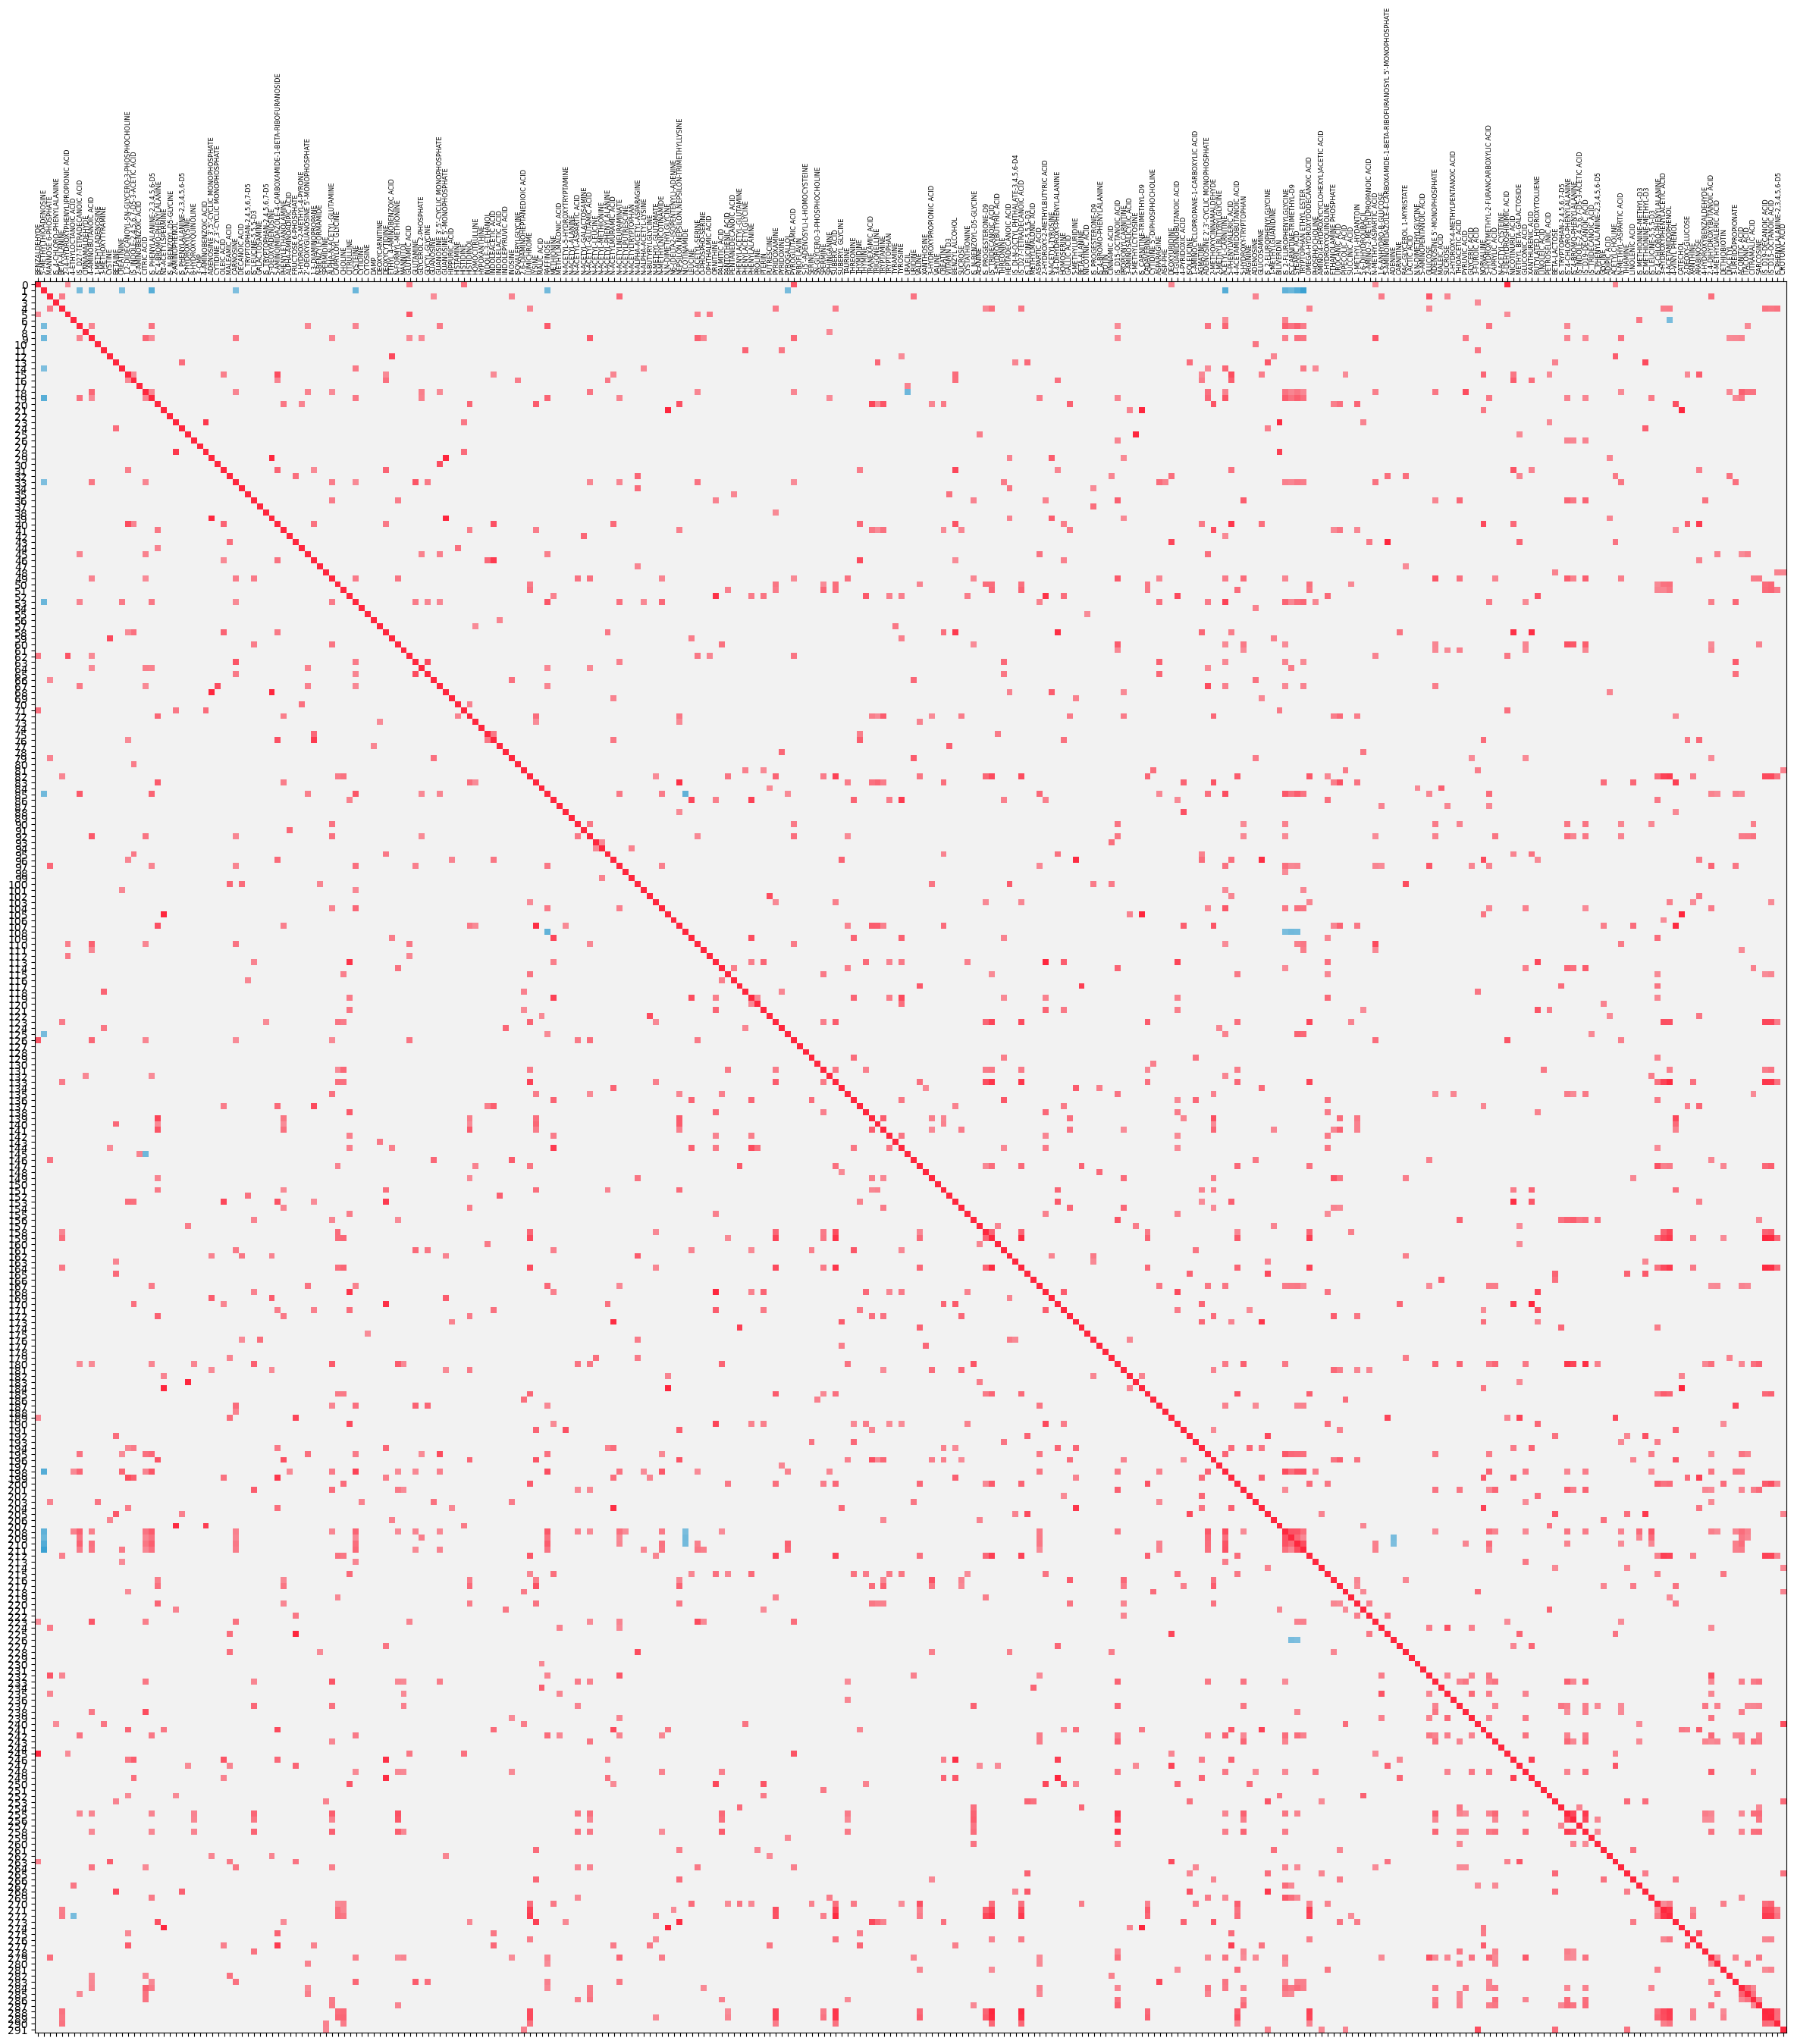

In [410]:
blue_white_red = LinearSegmentedColormap.from_list('blue_white_red', \
                                                   [(-1, 'blue'), (0, 'white'), (1, 'red')])

palette_ =  sns.diverging_palette(h_neg=240, h_pos=10, s=99, l=55, sep=3, as_cmap=True, center='light')
corr_thresh = 0.5

for p_tmp in p_vec_new:
    x = Ri_noMicrocosm_fit_avg.copy()[p_tmp]
    rank_x = get_rank(-x)
    id_order = np.argsort(rank_x)

    ind = []
    df_tmp = df_metabs_clusters.copy().iloc[id_order, :]
    for row_ in range(df_tmp.shape[0]):
        ind += df_tmp.iloc[row_, 2]

    df_tmp = df_speciesMetab.copy()
    df_tmp.columns = list(metab_names.copy())
    corr = df_tmp.corr()
    corr = corr.iloc[ind, ind]
    corr[(corr > -corr_thresh) & (corr < corr_thresh)] = 0
    # corr[corr < 0.4] = 0
    fig, ax = plt.subplots(figsize=(30, 30))
    #     cax = ax.matshow(corr, cmap='RdYlGn')
    cax = ax.matshow(corr, cmap=palette_, vmin=-1, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6);
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=6);

    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                            'predictions', 'leaveOneOut', \
                                            f'{date_}_predict_abundance_blind_growth_ratio' + \
                                            f'_noMicrocosm_' + \
                                            f'Ri_fit_dynamic_all_passages_cluster_metabolites' + \
                                            f'_umap_{distance_metric}' + \
                                            f'_dim{dim_project}' + \
                                            f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                            f'_clusterMethod_{clustering_method}', \
                                            f'metabolite_consumption_matrix_correlation_heatmap' + \
                                            f'_corrThresh{corr_thresh}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)
    file_save = os.path.abspath(os.path.join(save_dir, 
                                             f'metabolite_consumption_matrix_correlation_cluster_p{p_tmp}' + \
                                             f'_noMicrocosm_Ri_fit_dynamic_all_passages_cluster_metabolites' + \
                                             f'_umap_{distance_metric}' + \
                                             f'_dim{dim_project}' + \
                                             f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                             f'_clusterMethod_{clustering_method}' + \
                                             f'_corrThresh{corr_thresh}.png'))

    plt.savefig(file_save, dpi=300, transparent=False, facecolor="white")
    plt.close()

In [ ]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                        f'_noMicrocosm_' + \
                                        f'Ri_fit_dynamic_all_passages' + \
                                        f'_cluster_metabolites_umap_{distance_metric}' + \
                                        f'_dim{dim_project}'+ \
                                        f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                        f'_clusterMethod_{clustering_method}_randomSeed_635'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_noMicrocosm_cluster_metabolites' + \
                                         f'_umap_{distance_metric}' + \
                                         f'_dim{dim_project}'+ \
                                         f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                         f'_clusterMethod_{clustering_method}.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_noMicrocosm_fit_all = save_obj["Ri_noMicrocosm_fit_all"]
Ri_noMicrocosm_fit_avg = save_obj["Ri_noMicrocosm_fit_avg"]

In [1064]:
p_tmp = 0.4
x = Ri_noMicrocosm_fit_avg.copy()[p_tmp]
rank_x = get_rank(-x)
id_order = np.argsort(rank_x)
print(np.sum(x))

1.0


In [1065]:
df_tmp = df_metabs_clusters.copy().iloc[id_order, :]
df_tmp['Ri'] = x[id_order]
df_tmp.iloc[range(40), :]

,cluster_labels,cluster_counts,cluster_metab_IDs,cluser_metab_names,Ri
22,22,8,"[61, 65, 83, 86, 97, 100, 125, 199]","[FRUCTOSE 6-PHOSPHATE, 5-AMINOPENTANOIC ACID, ...",0.184233
18,18,12,"[0, 18, 80, 85, 150, 151, 194, 224, 242, 261, ...","[GALACTOSAMINE, PIPECOLIC ACID, CROTONIC ACID,...",0.115875
47,47,1,[90],[4-HYDROXYBENZALDEHYDE],0.102623
1,1,4,"[1, 126, 155, 253]","[N-METHYL-ASPARTIC ACID, N-METHYL-ASPARTIC ACI...",0.095024
37,37,1,[49],"[IS_TRYPTOPHAN-2,4,5,6,7-D5]",0.087634
56,56,1,[152],[3'-CMP],0.053838
42,42,1,[66],[CITRIC ACID],0.052997
34,34,1,[35],[CYSTINE],0.048592
35,35,1,[45],[IS_METHIONINE-METHYL-D3],0.046372
74,74,1,[265],[PUTRESCINE],0.046205


In [1048]:
df_tmp_noMicro.head(n=10)
df_tmp_superAgar.head(n=10)

,cluster_labels,cluster_counts,cluster_metab_IDs,cluser_metab_names,Ri
22,22,8,"[61, 65, 83, 86, 97, 100, 125, 199]","[FRUCTOSE 6-PHOSPHATE, 5-AMINOPENTANOIC ACID, ...",0.184233
18,18,12,"[0, 18, 80, 85, 150, 151, 194, 224, 242, 261, ...","[GALACTOSAMINE, PIPECOLIC ACID, CROTONIC ACID,...",0.115875
47,47,1,[90],[4-HYDROXYBENZALDEHYDE],0.102623
1,1,4,"[1, 126, 155, 253]","[N-METHYL-ASPARTIC ACID, N-METHYL-ASPARTIC ACI...",0.095024
37,37,1,[49],"[IS_TRYPTOPHAN-2,4,5,6,7-D5]",0.087634
56,56,1,[152],[3'-CMP],0.053838
42,42,1,[66],[CITRIC ACID],0.052997
34,34,1,[35],[CYSTINE],0.048592
35,35,1,[45],[IS_METHIONINE-METHYL-D3],0.046372
74,74,1,[265],[PUTRESCINE],0.046205


In [1022]:
df_tmp_noMicro = df_tmp.copy()

In [1066]:
df_tmp_superAgar = df_tmp.copy()

PearsonRResult(statistic=0.6305040847634628, pvalue=1.0359996992019953e-09)

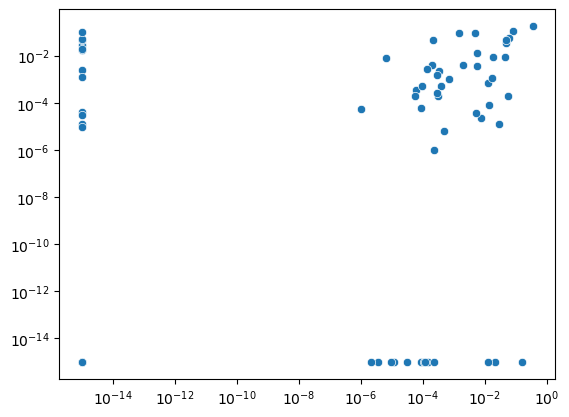

In [1067]:
x = df_tmp_noMicro['cluster_labels'].values
y = df_tmp_superAgar['cluster_labels'].values

Ri_x = np.zeros(df_tmp_noMicro.shape[0])
Ri_x[x] = df_tmp_noMicro['Ri'].values
Ri_x[Ri_x == 0] = 1e-15

Ri_y = np.zeros(df_tmp_superAgar.shape[0])
Ri_y[y] = df_tmp_superAgar['Ri'].values
Ri_y[Ri_y == 0] = 1e-15

id_ = np.where((Ri_x > 1e-15) & (Ri_y > 1e-15 ))

plt_ = sns.scatterplot(x=Ri_x, y=Ri_y)
plt_.set_xscale('log', base=10)
plt_.set_yscale('log', base=10)
scipy.stats.pearsonr(Ri_x, Ri_y)
# scipy.stats.pearsonr(Ri_x[id_], Ri_y[id_])

# Compare Ri clustered across different microcosm supernatant

In [25]:
date_ = '20230416'
date_ = '20230426'
dim_project = 20
distance_metric = 'euclidean'
metab_cluster_mean_func = 'geometric'
clustering_method = "hdbscan"
random_seed = 635
# random_seed = 9876
microcosm_type = "supernatantAgar"
date_vec = ["20230416", "20230416", "20230426"]
microcosm_type = ["noMicrocosm", "supernatantAgar", "mucin"]
microcosm_names = ["noMicrocosm", "agar", "mucin"]

date_vec = ["20230416", "20230426"]
microcosm_type = ["supernatantAgar", "mucin"]
microcosm_names = ["agar", "mucin"]

In [26]:
Ri_microcosm_fit_avg = {}

for count_, microcosm_ in enumerate(microcosm_type):
    date_ = date_vec[count_]
    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                            'predictions', 'leaveOneOut', \
                                            f'{date_}_predict_abundance_blind_growth_ratio' + \
                                            f'_Ri_fit_dynamic_all_passages' + \
                                            f'_cluster_metabolites_umap_{distance_metric}' + \
                                            f'_dim{dim_project}'+ \
                                            f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                            f'_clusterMethod_{clustering_method}_{microcosm_}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)
    file_save = os.path.abspath(os.path.join(save_dir, 
                                             f'{date_}_Ri_fit_dynamic_all_passages' + \
                                             f'_different_p_LeaveOneOutRi_cluster_metabolites' + \
                                             f'_umap_{distance_metric}' + \
                                             f'_dim{dim_project}'+ \
                                             f'_cluster_meanFunc_{metab_cluster_mean_func}' + \
                                             f'_clusterMethod_{clustering_method}_{microcosm_}.pickle'))

    with open(file_save, "rb") as file_:
        save_obj = pickle.load(file_)

    Ri_microcosm_fit_avg[microcosm_names[count_]] = save_obj["Ri_noMicrocosm_fit_avg"]

In [27]:
date_ = "20230426"
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.325, 0.35, \
             0.375, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
Ri_thresh = 1e-20
for count_1 in range(len(microcosm_names)):
    micro_1 = microcosm_names[count_1]
    for count_2 in range(count_1 + 1, len(microcosm_names)):
        micro_2 = microcosm_names[count_2]
        df_summary = pd.DataFrame()
        for count_p, p_tmp in enumerate(p_vec_new):
            x = Ri_microcosm_fit_avg[micro_1].copy()[p_tmp]
            y = Ri_microcosm_fit_avg[micro_2].copy()[p_tmp]

            print(np.min(x[x != 0]))
            print(np.min(y[y != 0]))

            print(f'# metabs with Ri == 0 for no-microcosm = {len(x[x == 0])}')
            print(f'# metabs with Ri == 0 for supernatant-agar = {len(y[y == 0])}')

            x[x == 0] = Ri_thresh
            y[y == 0] = Ri_thresh

            x_full = x.copy()
            y_full = y.copy()


            id_2 = np.where((x > Ri_thresh) & (y <= Ri_thresh))[0]
            print(f'# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_2)}')

            id_1 = np.where((x <= Ri_thresh) & (y > Ri_thresh))[0]
            print(f'# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = {len(id_1)}')

            id_rm = np.where((x == Ri_thresh) & (y == Ri_thresh))[0]
            print(f'# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_rm)}')


            # plots
            fig, axes = plt.subplots(1, 2, figsize=(40, 30), sharey="row", sharex="col")
            fig.suptitle(f'Ri fit comparison between {micro_1} and {micro_2} \n' + \
                         f'# metabs with Ri == 0 for {micro_1} = {len(x[x == Ri_thresh])}, ' + \
                         f'# metabs with Ri == 0 for {micro_2} = {len(y[y == Ri_thresh])}, ' + \
                         f'# metabs with Ri > 0 for {micro_1} and Ri == 0 ' + \
                         f'for {micro_2} = {len(id_2)} \n' + \
                         f'# metabs with Ri == 0 for {micro_1} and Ri > 0 for {micro_2} = {len(id_1)} \n' + \
                         f'# metabs with Ri == 0 for {micro_1} and Ri == 0 for {micro_2} = {len(id_rm)}', \
                         fontsize=25)
            fig.supxlabel(f'Ri {micro_1} (log-scale)', fontsize=50)
            fig.supylabel(f'Ri {micro_2} (log-scale)', fontsize=50)


            id_ = list(set(range(len(x_full))) - set(id_rm))
            # id_ = range(len(x))

            x = np.log10(x_full[id_])
            y = np.log10(y_full[id_])
            plt_ = sns.scatterplot(x=x, y=y, ax=axes[0], s=200)
            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", ax=axes[0])
            # plt_.plot([-15, 1], [-15, 1], c="red")
            plt_.plot([-15, 0], [-15, 0], c="red")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1])

            axes[0].set_title(title_, size=25)
            plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
            plt_.set_yticklabels(plt_.get_yticklabels(), size=30)


            id_ = np.where((x_full != Ri_thresh) & (y_full != Ri_thresh))[0]
            x = np.log10(x_full[id_])
            y = np.log10(y_full[id_])
            plt_ = sns.scatterplot(x=x, y=y, ax=axes[1], s=200)
            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", ax=axes[1])
            # plt_.plot([-15, 1], [-15, 1], c="red")
            plt_.plot([-10, 0], [-10, 0], c="red")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1])

            axes[1].set_title(title_, size=25)
            plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
            # plt_.set_yticklabels(plt_.get_yticklabels(), size=20)


            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_metabsClustered_Ri_compare_' + \
                                                    f'different_media', 
                                                    f'{micro_1}_vs_{micro_2}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, f'RiFit_comparison_p{p_tmp}_' + \
                                                     f'{micro_1}_vs_{micro_2}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


            df_tmp = \
                pd.DataFrame(data={"p" : [p_tmp] * 3, 
                                   "metric_type" : ["corr_pearson_linear", "corr_pearson_log", 
                                                    "corr_spearman"], 
                                   "metric" : [corr_val_pe[0], corr_val_pe_log[0], 
                                               corr_val_sp[0]],
                                   "pval" : [corr_val_pe[1], corr_val_pe_log[1], 
                                             corr_val_sp[1]]})
            df_summary = pd.concat([df_summary, df_tmp], ignore_index=True)
        
        
        fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
        fig.suptitle(f'corr, Ri {micro_1} vs {micro_1} \n', \
                     fontsize=20)
        fig.supxlabel('p', fontsize=20)
        fig.supylabel('correlation', fontsize=20)
        plt_ = sns.scatterplot(data=df_summary, x="p", y="metric", \
                               hue="metric_type", ax=axes)
        plt_ = sns.lineplot(data=df_summary, x="p", y="metric", \
                               hue="metric_type", ax=axes)
        plt_.set_xscale("log", base=10)

        save_file = os.path.abspath(os.path.join(save_dir, 
                                                 f'RiFit_comparison_summary.png'))
        fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
        plt.close(fig.figure)


1.1756266457312338e-05
3.7887953021404336e-06
# metabs with Ri == 0 for no-microcosm = 29
# metabs with Ri == 0 for supernatant-agar = 29
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 2
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 2
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 27


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


6.711398880612043e-06
2.7014383473189697e-06
# metabs with Ri == 0 for no-microcosm = 28
# metabs with Ri == 0 for supernatant-agar = 29
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 3
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 2
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 26


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1.1399550819954242e-05
9.125249973150404e-07
# metabs with Ri == 0 for no-microcosm = 28
# metabs with Ri == 0 for supernatant-agar = 28
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 3
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 3
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 25


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


2.4559702297147444e-06
1.0468784901731003e-05
# metabs with Ri == 0 for no-microcosm = 27
# metabs with Ri == 0 for supernatant-agar = 27
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 3
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 3
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 24


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


9.446388684175268e-06
6.295466099133254e-06
# metabs with Ri == 0 for no-microcosm = 27
# metabs with Ri == 0 for supernatant-agar = 25
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 3
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 5
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 22


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1.8793078879080255e-06
2.4286140965520984e-06
# metabs with Ri == 0 for no-microcosm = 26
# metabs with Ri == 0 for supernatant-agar = 24
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 3
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 5
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 21


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


9.373272474560602e-06
5.015907281866241e-06
# metabs with Ri == 0 for no-microcosm = 26
# metabs with Ri == 0 for supernatant-agar = 24
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 2
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 4
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 22


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1.78077567191836e-05
5.47017356933722e-06
# metabs with Ri == 0 for no-microcosm = 27
# metabs with Ri == 0 for supernatant-agar = 23
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 2
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 6
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 21


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


5.113701350219412e-06
4.5765689017274435e-07
# metabs with Ri == 0 for no-microcosm = 25
# metabs with Ri == 0 for supernatant-agar = 24
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 3
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 4
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 21


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1.3823667487208641e-05
2.4577698890936157e-05
# metabs with Ri == 0 for no-microcosm = 25
# metabs with Ri == 0 for supernatant-agar = 25
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 8
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 8
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 17


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1.620847648605837e-05
8.080985149077621e-06
# metabs with Ri == 0 for no-microcosm = 26
# metabs with Ri == 0 for supernatant-agar = 25
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 6
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 7
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 19


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


9.498939371812976e-06
1.529377312049068e-05
# metabs with Ri == 0 for no-microcosm = 28
# metabs with Ri == 0 for supernatant-agar = 26
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 6
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 8
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 20


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1.3390655687310623e-06
2.3988708105685512e-05
# metabs with Ri == 0 for no-microcosm = 29
# metabs with Ri == 0 for supernatant-agar = 28
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 7
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 8
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 21


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


9.747770987566138e-07
2.508748653512861e-05
# metabs with Ri == 0 for no-microcosm = 28
# metabs with Ri == 0 for supernatant-agar = 28
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 7
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 7
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 21


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


6.042115404134842e-06
8.17242449196429e-06
# metabs with Ri == 0 for no-microcosm = 31
# metabs with Ri == 0 for supernatant-agar = 32
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 9
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 8
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 23


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


3.0868632894764634e-06
2.5553289152734204e-05
# metabs with Ri == 0 for no-microcosm = 33
# metabs with Ri == 0 for supernatant-agar = 35
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 9
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 7
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 26


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


5.854625733192171e-07
6.2142839900324825e-06
# metabs with Ri == 0 for no-microcosm = 36
# metabs with Ri == 0 for supernatant-agar = 35
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 7
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 8
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 28


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


3.869350289014912e-06
1.3011231312336232e-05
# metabs with Ri == 0 for no-microcosm = 37
# metabs with Ri == 0 for supernatant-agar = 37
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 10
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 10
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 27


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1.7685357990512858e-06
9.02100515538309e-06
# metabs with Ri == 0 for no-microcosm = 35
# metabs with Ri == 0 for supernatant-agar = 36
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 9
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 8
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 27


/tmp/ipykernel_307014/881935859.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_307014/881935859.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


In [993]:
id_metab = 3
print(df_tmp.iloc[range(id_metab, id_metab + 1), 4].values)
df_tmp.iloc[range(id_metab, id_metab + 1), 3].values

[0.05980923]


array([list(["3'-CMP"])], dtype=object)

In [932]:
np.sum(x)

1.0

In [731]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_noMicrocosm_Ri_fit_dynamic_' + \
                                        'all_passages'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_noMicrocosm.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_noMicrocosm_fit_all = save_obj["Ri_noMicrocosm_fit_all"]
Ri_noMicrocosm_fit_avg = save_obj["Ri_noMicrocosm_fit_avg"]

In [655]:
p_tmp = 0.4
np.sum(Ri_noMicrocosm_fit_avg.copy()[p_tmp])

0.44996447268346595

# 18 April 2023: no-Microcosm fit Ri dynamic (all passages) with metabolite consumption matrix not clustered

In [971]:
date_ = '20230418'

In [972]:
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.325, 0.35, \
             0.375, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
num_passages = 6
Ri_noMicrocosm_fit_all = {}
Ri_noMicrocosm_fit_avg = {}
df_speciesMetab_tmp = df_speciesMetab.copy()
# df_speciesMetab_tmp = df_speciesMetab.copy()
num_metabs = df_speciesMetab_tmp.shape[1]
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}, p = {p_tmp}')
    Ri_noMicrocosm_fit_all[p_tmp] = np.zeros((num_species, num_metabs))
    Ri_noMicrocosm_fit_avg[p_tmp] = np.zeros((num_metabs))
    count_species = 0
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_noMicrocosm_fit_all[p_tmp][species_, :] = compute_Ri(df_speciesMetab_tmp.copy(), \
                                                                df_speciesAbun_prev.copy(), \
                                                                df_speciesAbun_next.copy(), \
                                                                df_speciesAbun_ratio.copy(), \
                                                                p_tmp, num_passages, \
                                                                id_species)
        if np.sum(Ri_noMicrocosm_fit_all[p_tmp][species_, :]) <= 5:
            Ri_noMicrocosm_fit_avg[p_tmp] += Ri_noMicrocosm_fit_all[p_tmp][species_, :]
            count_species += 1
            
        
    Ri_noMicrocosm_fit_avg[p_tmp] /= count_species
    Ri_noMicrocosm_fit_avg[p_tmp] /= np.sum(Ri_noMicrocosm_fit_avg[p_tmp])

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                        f'_noMicrocosm_' + \
                                        f'Ri_fit_dynamic_all_passages' + \
                                        f'_noCluster_metabolites'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_noMicrocosm_noCluster_metabolites' + \
                                         f'.pickle'))

save_obj = {"Ri_noMicrocosm_fit_all" : Ri_noMicrocosm_fit_all, \
            "Ri_noMicrocosm_fit_avg" : Ri_noMicrocosm_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, p = 0.001
count_p = 1, p = 0.01
count_p = 2, p = 0.05
count_p = 3, p = 0.06
count_p = 4, p = 0.07
count_p = 5, p = 0.08
count_p = 6, p = 0.09
count_p = 7, p = 0.1
count_p = 8, p = 0.2
count_p = 9, p = 0.3
count_p = 10, p = 0.325
count_p = 11, p = 0.35
count_p = 12, p = 0.375
count_p = 13, p = 0.4
count_p = 14, p = 0.5
count_p = 15, p = 0.55
count_p = 16, p = 0.6
count_p = 17, p = 0.65
count_p = 18, p = 0.7


In [ ]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                        f'_noMicrocosm_' + \
                                        f'Ri_fit_dynamic_all_passages' + \
                                        f'_noCluster_metabolites'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'{date_}_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_noMicrocosm_noCluster_metabolites' + \
                                         f'.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_noMicrocosm_fit_all = save_obj["Ri_noMicrocosm_fit_all"]
Ri_noMicrocosm_fit_avg = save_obj["Ri_noMicrocosm_fit_avg"]

## Fit abundance blindly

In [973]:
p_vec_new = list(Ri_noMicrocosm_fit_avg.keys())

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
df_speciesMetab_tmp = df_speciesMetab.copy()
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
#                     fac_ = 1 / np.sum(df_speciesAbun_prev_tmp_[col_].values)
#                     df_speciesAbun_prev_tmp_[col_] = fac_ * \
#                         df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_noMicrocosm_fit_avg[p_tmp].copy()
#             Ri_avg /= np.sum(Ri_avg)
#             Ri_avg = Ri_clust_to_all(Ri_noMicrocosm_fit_avg[p_tmp].copy(), \
#                                      df_metabs_clusters, df_speciesMetab.shape[1]) 
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri dynamical all passages noMicrocosm noCluster_metabolites', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, df_speciesMetab_tmp,
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_noMicrocosm_' + \
                                                    f'Ri_fit_dynamic_all_passages' + \
                                                    f'_noCluster_metabolites', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_dynamical' + \
                                                     f'_with_p{p_tmp}_noCluster_metabolites' + \
                                                     f'.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values
#                 fac_ = 1 / np.sum(df_tmp[col_].values)
#                 df_tmp[col_] = fac_ * \
#                     df_tmp[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where((x > 0) & (y > 0))[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, \
                                               std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                    f'_noMicrocosm_' + \
                                                    f'Ri_fit_dynamic_all_passages' + \
                                                    f'_noCluster_metabolites', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'{date_}_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_dynamic_all_passages' + \
                                                     f'_p{p_tmp}_{norm_status}_noMicrocosm' + \
                                                     f'_noCluster_metabolites' + \
                                                     f'.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [974]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                f'_noMicrocosm_' + \
                                                f'Ri_fit_dynamic_all_passages' + \
                                                f'_noCluster_metabolites', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'{date_}_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme_noMicrocosm' + \
                                             f'_Ri_fit_dynamic_all_passages_noCluster_metabolites' + \
                                             f'.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

In [975]:
num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
p_vec_new = list(Ri_noMicrocosm_fit_avg.keys())

df_speciesMetab_tmp = df_speciesMetab.copy()
for norm_status in norm_status_vec:
    for pass_ in [0]:
        df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

        df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})
    
        df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})

        for count_p, p_tmp in enumerate(p_vec_new):
            if count_p <= 200:
                growth_rate_all = {}
                growth_rate_all[0] = pd.DataFrame()
                Ri_avg = Ri_noMicrocosm_fit_avg[p_tmp].copy()

                fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
                fig.suptitle(f'predicted vs observed growth ratios passage {pass_ + 1}->{pass_ + 2}, \n' + 
                             f'Ri fit with p = {p_tmp}, no-Microcosm ' + \
                             f'noCluster_metabolites', \
                             fontsize=15)
                fig.supylabel('predicted growth ratio (log scale)', fontsize=15)
                fig.supxlabel('observed growth ratio (log scale)', fontsize=15)
                plt_rows = 2
                plt_cols = 4

                ratio_means_ = {}
                for col_ in df_speciesAbun_prev_tmp_.columns.values:
                    growth_rate_all[0][col_] = np.ones((num_species))
                    x = df_speciesAbun_ratio_tmp_[col_].values
                    ratio_means_[col_] = np.mean(np.log10(x[x != -1]))

                for iter_ in range(num_iter):
                    if iter_ == 0:
                        iter_id = iter_
                    else:
                        iter_id = iter_ - 1
                    if norm_status == "norm":    
                        iter_thresh = -1
                    else:
                        iter_thresh = -1

                    if norm_status == "norm":
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy())
                    else:
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy(), \
                                                                      df_speciesMetab_tmp.copy(),
                                                                      norm_=False)

                    growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                        f'_noMicrocosm_' + \
                                                        f'Ri_fit_dynamic_all_passages' + \
                                                        f'_noCluster_metabolites', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, \
                                                        'predicted_growth_ratios', \
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                    os.makedirs(save_dir)
                file_save = os.path.abspath(os.path.join(save_dir, 
                                                         f'predicted_growth_ratios_with_p{p_tmp}' + \
                                                         f'_noCluster_metabolites.pickle'))


                with open(file_save, "wb") as file_:
                    pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)

                b_ = range(3)
                x = np.array(df_speciesAbun_ratio_tmp_.copy())[:, b_].flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, b_].flatten()
                id_ = np.where(x > 0)[0]
                id_zero = np.where((x <= thresh_zero))[0]
                x = np.log10(x[id_])
                y = np.log10(y[id_])
                # y=np.random.permutation(x)
                y[y <= -5] = -5
                id_ = np.where((y > -100))[0]
                x = x[id_]
                y = y[id_]
                
#                 rolling mean
                id_order = np.argsort(x)
                x_order = (x.copy())[id_order]
                y_order = (y.copy())[id_order]
                df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
                window_size = 20
                rolling_avg = df_tmp['y'].rolling(window_size).mean().values
                id_not_nan = np.where(~np.isnan(rolling_avg))[0]
                id_nan = np.where(np.isnan(rolling_avg))[0]

                plt_ = sns.scatterplot(x=x, \
                                       y=y, ax=axes)

                plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                                   ax=axes)
                plt_.plot([-4, 2], [-4, 2], c="red")
#                 plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

                corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
                corr_val_pe_log = scipy.stats.pearsonr(x, y)
                corr_val_sp = scipy.stats.spearmanr(x, y)
                corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                           (y - np.mean(y)) / np.std(y))
                mean_error = np.abs(np.median(y - x))
                abs_mean_error = np.median(np.abs(y - x))
                cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
                std_error = np.std(np.abs(y - x))

                id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

                frac_zero = len(id_notzero_zero) / len(x)

                model = sm.OLS(y, x).fit()
                slope = model.params[0]
                slope_pval = model.pvalues[0]

                df_tmp = \
                    pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                       "passage" : [pass_] * 7, 
                                       "p" : [p_tmp] * 7, 
                                       "metric_type" : ["corr_pearson_log", 
                                                        "corr_spearman", "slope", "corr_pearson_linear", \
                                                        "abs_median_error", \
                                                        "std_error", "FNR"], 
                                       "metric" : [corr_val_pe_log[0], 
                                                   corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, std_error, \
                                                   frac_zero],
                                       "pval" : [corr_val_pe_log[1], 
                                                 corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
                df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


                plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

                title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe[1]) + \
                         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe_log[1]) + \
                         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_sp[1]) + \
                         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                                '{:.3e}'.format(slope_pval) + \
                         f'\n fit with p = {p_tmp}'

                axes.set_title(title_, size=10)

                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                        f'_noMicrocosm_' + \
                                                        f'Ri_fit_dynamic_all_passages' + \
                                                        f'_noCluster_metabolites', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, 
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                   os.makedirs(save_dir)

                save_file = os.path.abspath(os.path.join(save_dir, 
                                                         f'{date_}_predicted_vs_observed_growth_ratios_' + \
                                                         f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme_' + \
                                                         f'_Ri_fit_with_p{p_tmp}_{norm_status}' + \
                                                         f'_noCluster_metabolites.png'))
                fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
                plt.close(fig.figure)

In [976]:
for pass_ in [0]:    
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed growth ratios \n' + \
                 f' passage {pass_ + 1}->{pass_ + 2}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]

    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                   hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                f'{date_}_predict_abundance_blind_growth_ratio' + \
                                                f'_noMicrocosm_' + \
                                                f'Ri_fit_dynamic_all_passages' + \
                                                f'_noCluster_metabolites', \
                                                'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                norm_status, 
                                                f'passage_{pass_ + 1}to{pass_ + 2}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'{date_}_corr_slope_predicted_vs_observed_growth_ratios_' + \
                                             f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
                                             f'_noCluster_metabolites.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)